# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [ ]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.10.0+cu111
CUDA enabled: True


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive  Shareddrives


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [ ]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

--2021-11-22 21:44:15--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  6.89MB/s    in 0.3s    

2021-11-22 21:44:16 (6.89 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [ ]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = " ".join(data.split())
    
    voc2ind = {}
    ind = 0
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        if char not in voc2ind:
            voc2ind[char] = ind
            ind += 1

    ind2voc = {val: key for key, val in voc2ind.items()}

    split = int(0.8 * len(data))
    train_text = data[:split] # TODO Fill this in
    test_text = data[split:] # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [ ]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        tokens = dataset['tokens']
        voc2ind = dataset['voc2ind']

        num_tokens = len(tokens) - (len(tokens) % batch_size) # number of tokens to use
        self.data = torch.LongTensor([voc2ind[tokens[i]] for i in range(num_tokens)]).view(batch_size, -1) # break data into batch_size batches (use .view() for faster ops)
        self.num_sequences = self.data.shape[0] * int(np.ceil((self.data.shape[1] - 1) / self.sequence_length)) # number of batches * number of sequences in a batch

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return self.num_sequences
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        batch_idx = idx % self.batch_size # incrementing idx by 1 should increase the batch number until all batches have been seen, then the sequence number should be increased
        seq_idx = idx // self.batch_size

        seq_start_idx = seq_idx * self.sequence_length # starting index of the sequence in the batch
        seq_end_idx = min(seq_start_idx + self.sequence_length + 1, self.data.shape[1]) # ending index (exclusive) of the sequence accounting for the end of the batch

        data = self.data[batch_idx][seq_start_idx:seq_end_idx]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [ ]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [ ]:
TEMPERATURE = 0.75
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        sample = output[0].argmax().long()
        outputs.append(sample)
        output, hidden = model.inference(sample, hidden, TEMPERATURE)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        sample = torch.multinomial(output[0], 1)[0].long()
        outputs.append(sample)
        output, hidden = model.inference(sample, hidden, TEMPERATURE)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beam = [([], output, hidden, 0)]
    # TODO
    for ii in range(sequence_length):
        new_beams = []
        for curr_beam in beam:
            for sample in torch.multinomial(curr_beam[1][0], beam_width, replacement=True):
                sample = sample.long()
                score = curr_beam[3] + torch.log(curr_beam[1][0][sample])
                output, hidden = model.inference(sample, curr_beam[2], TEMPERATURE)
                new_beams.append((curr_beam[0] + [sample], output, hidden, score))
        new_beams.sort(key = lambda b: b[3], reverse=True)
        beam = new_beams[:beam_width]
    outputs = beam[0][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

In [ ]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	ykId.=ffdafJb=y[kPk==k)k=dyay'ffffG.fy``\/.F=XXHjGbj=dkF)=FHHH}HbGb.NawHjbcn[Eff HLL50O8aa0?c.Nawb88


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	dnddG).fbGbH?f)\.Iy``0k=y[k88d%yIbGw(())//}L6()SS)..`yyka/fnHffGbafxI8G`FFf)\.ff=ffscwww)bfbbbfd).wl


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	aww\a//.=y[k)zaz(a[/.a/8fbbbdaz)wwkHscffGb)=d..88fbbbfd=)ffa[c8bhdd)N))0HYHLLb[[kbbLLaa((kkHd)[ff&=d


Input	 hel

  1%|          | 2/195 [00:00<00:39,  4.84it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 16.397327


  6%|▌         | 12/195 [00:02<00:30,  5.90it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 10.716467


 11%|█▏        | 22/195 [00:03<00:28,  5.97it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 5.505625


 16%|█▋        | 32/195 [00:05<00:27,  6.03it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 3.777054


 22%|██▏       | 42/195 [00:07<00:25,  6.07it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.974107


 27%|██▋       | 52/195 [00:08<00:23,  6.03it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 3.723442


 32%|███▏      | 62/195 [00:10<00:21,  6.05it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 2.767107


 37%|███▋      | 72/195 [00:12<00:20,  5.99it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 2.266341


 42%|████▏     | 82/195 [00:13<00:18,  5.99it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 2.115175


 47%|████▋     | 92/195 [00:15<00:17,  5.95it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 2.296375


 52%|█████▏    | 102/195 [00:17<00:15,  5.97it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 2.791740


 57%|█████▋    | 112/195 [00:18<00:13,  5.98it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 2.290280


 63%|██████▎   | 122/195 [00:20<00:12,  5.99it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 2.473109


 68%|██████▊   | 132/195 [00:22<00:10,  5.97it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 2.068364


 73%|███████▎  | 142/195 [00:23<00:08,  5.98it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.943392


 78%|███████▊  | 152/195 [00:25<00:07,  5.94it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 2.216591


 83%|████████▎ | 162/195 [00:27<00:05,  5.97it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 2.031599


 88%|████████▊ | 172/195 [00:28<00:03,  5.99it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.960593


 93%|█████████▎| 182/195 [00:30<00:02,  5.91it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.861516


 98%|█████████▊| 192/195 [00:32<00:00,  5.97it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.943638


100%|██████████| 195/195 [00:32<00:00,  5.98it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rdroeteyelntnnd eeertd bnain,ietoe eare yeaasl  .W nnedarre .  "e said  "Wo 't yarry  nitt  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	oseee ioe cnt r oore  bnd eerry nereed iembledore peck into the etr weer yer ooet Herl   ooe caoeell


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  tg tnd Heocpeng tntthe eeseeeyon the pero aeshttnuuemeunttagwwe te  "ir wne territle oere t,aarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:43,  4.46it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.946910


  6%|▌         | 12/195 [00:02<00:30,  5.96it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.883142


 11%|█▏        | 22/195 [00:03<00:28,  6.04it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 2.069094


 16%|█▋        | 32/195 [00:05<00:27,  5.95it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.878775


 22%|██▏       | 42/195 [00:07<00:26,  5.88it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.779682


 27%|██▋       | 52/195 [00:08<00:23,  6.01it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.685687


 32%|███▏      | 62/195 [00:10<00:22,  5.94it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.706096


 37%|███▋      | 72/195 [00:12<00:20,  5.94it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.708976


 42%|████▏     | 82/195 [00:13<00:18,  5.95it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.744775


 47%|████▋     | 92/195 [00:15<00:17,  6.05it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.787195


 52%|█████▏    | 102/195 [00:17<00:15,  5.93it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.770050


 57%|█████▋    | 112/195 [00:18<00:14,  5.76it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.708523


 63%|██████▎   | 122/195 [00:20<00:12,  5.94it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.667040


 68%|██████▊   | 132/195 [00:22<00:10,  6.01it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.738231


 73%|███████▎  | 142/195 [00:23<00:08,  6.03it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 2.108240


 78%|███████▊  | 152/195 [00:25<00:07,  6.01it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.944418


 83%|████████▎ | 162/195 [00:27<00:05,  5.98it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.761364


 88%|████████▊ | 172/195 [00:28<00:03,  5.97it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.654706


 93%|█████████▎| 182/195 [00:30<00:02,  5.93it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.586864


 98%|█████████▊| 192/195 [00:32<00:00,  6.02it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.575912


100%|██████████| 195/195 [00:32<00:00,  5.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rwoaet Holhttnd soaddd atain,t the fore  eoask  "S dn ohrke .  "e said  "So 't yhuky  titt  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ose d the htt r oore  and Harry saap d humbledore aeck tn o the ctr.woet yed thet horl d ahe fooaell


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd seappeng hn the sosdle of the fork aashttnuieneyt tagwmedde  "ir afe oewrible terent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:44,  4.34it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.585499


  6%|▌         | 12/195 [00:02<00:30,  5.92it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.579375


 11%|█▏        | 22/195 [00:03<00:29,  5.92it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.575585


 16%|█▋        | 32/195 [00:05<00:27,  6.01it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.571673


 22%|██▏       | 42/195 [00:07<00:25,  6.04it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.584115


 27%|██▋       | 52/195 [00:08<00:23,  5.96it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.810135


 32%|███▏      | 62/195 [00:10<00:22,  5.92it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.677869


 37%|███▋      | 72/195 [00:12<00:20,  5.97it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.594683


 42%|████▏     | 82/195 [00:13<00:18,  5.96it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.541693


 47%|████▋     | 92/195 [00:15<00:17,  5.91it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.537923


 52%|█████▏    | 102/195 [00:17<00:15,  6.02it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.560524


 57%|█████▋    | 112/195 [00:18<00:14,  5.90it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.600057


 63%|██████▎   | 122/195 [00:20<00:12,  5.94it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.725081


 68%|██████▊   | 132/195 [00:22<00:10,  5.98it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.650316


 73%|███████▎  | 142/195 [00:23<00:08,  5.97it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.591693


 78%|███████▊  | 152/195 [00:25<00:07,  6.00it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.545137


 83%|████████▎ | 162/195 [00:27<00:05,  5.99it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.507040


 88%|████████▊ | 172/195 [00:28<00:03,  5.98it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.503556


 93%|█████████▎| 182/195 [00:30<00:02,  5.91it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.489744


 98%|█████████▊| 192/195 [00:32<00:00,  5.89it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.494348


100%|██████████| 195/195 [00:32<00:00,  5.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rwoeet Hodnttnd soaddd atain.t the sose  ooask  "I ds oerre .  "e said  "Ion't yauky  Iort  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ows d the stt r oore  and Harry seap d humbledore weck on o the snr woet yed ohet horl d hhe sooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ned ng htd seenpeng hn the sosdle of the sork aashtwnuieneyn tagwmeade  "or sfe oewrible terent oarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:42,  4.52it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.519471


  6%|▌         | 12/195 [00:02<00:30,  6.03it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.528902


 11%|█▏        | 22/195 [00:03<00:28,  5.99it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.733678


 16%|█▋        | 32/195 [00:05<00:27,  5.97it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.658245


 22%|██▏       | 42/195 [00:07<00:25,  5.95it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.553642


 27%|██▋       | 52/195 [00:08<00:24,  5.96it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.494897


 32%|███▏      | 62/195 [00:10<00:22,  5.91it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.489429


 37%|███▋      | 72/195 [00:12<00:20,  6.09it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.499969


 42%|████▏     | 82/195 [00:13<00:18,  5.97it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.494302


 47%|████▋     | 92/195 [00:15<00:17,  5.99it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.516178


 52%|█████▏    | 102/195 [00:17<00:15,  6.00it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.497148


 57%|█████▋    | 112/195 [00:18<00:13,  5.95it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.467939


 63%|██████▎   | 122/195 [00:20<00:12,  6.01it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.470716


 68%|██████▊   | 132/195 [00:22<00:10,  5.94it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.498848


 73%|███████▎  | 142/195 [00:23<00:08,  6.00it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.487635


 78%|███████▊  | 152/195 [00:25<00:07,  5.93it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.484578


 83%|████████▎ | 162/195 [00:27<00:05,  6.02it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.462253


 88%|████████▊ | 172/195 [00:28<00:03,  5.99it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.489746


 93%|█████████▎| 182/195 [00:30<00:02,  5.99it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.472625


 98%|█████████▊| 192/195 [00:32<00:00,  6.03it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.468401


100%|██████████| 195/195 [00:32<00:00,  5.97it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rwoeet Holnttnd soaddd atain,t the bose  oaasl  "I ts Hhrre..  "e said  "Iin't yaury  Iot," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ews d the btt r oore  and tarry saap d humbledore weck on o the bnr woet yerstoet hrrl d ohe wooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ned ng htd soonpeng hn the soddle of the sork aashtwnuietehn tagwmeade  "or sfe oewrible tarent aarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:45,  4.26it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.468883


  6%|▌         | 12/195 [00:02<00:30,  5.99it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.465478


 11%|█▏        | 22/195 [00:03<00:29,  5.96it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.462330


 16%|█▋        | 32/195 [00:05<00:26,  6.09it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.490194


 22%|██▏       | 42/195 [00:07<00:25,  5.89it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.463659


 27%|██▋       | 52/195 [00:08<00:23,  6.00it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.445205


 32%|███▏      | 62/195 [00:10<00:22,  5.88it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.442448


 37%|███▋      | 72/195 [00:12<00:20,  5.91it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.446549


 42%|████▏     | 82/195 [00:13<00:19,  5.86it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.439514


 47%|████▋     | 92/195 [00:15<00:17,  5.96it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.452850


 52%|█████▏    | 102/195 [00:17<00:15,  6.01it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.456996


 57%|█████▋    | 112/195 [00:18<00:14,  5.90it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.539963


 63%|██████▎   | 122/195 [00:20<00:12,  5.98it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.576131


 68%|██████▊   | 132/195 [00:22<00:10,  5.99it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.623333


 73%|███████▎  | 142/195 [00:23<00:08,  6.01it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.486578


 78%|███████▊  | 152/195 [00:25<00:07,  5.93it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.443899


 83%|████████▎ | 162/195 [00:27<00:05,  5.91it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.423669


 88%|████████▊ | 172/195 [00:28<00:03,  5.94it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.407883


 93%|█████████▎| 182/195 [00:30<00:02,  6.02it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.404500


 98%|█████████▊| 192/195 [00:32<00:00,  6.06it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.423501


100%|██████████| 195/195 [00:32<00:00,  5.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeet sulnttnd seadid anain,t the bose  oaasl  "I tm ahrki..  "e said  "Iun't yaury  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ews d the btt r aoue  and tarry saap d tumbledore seck tn o the bnk soet yer thet hlrl d ahe sooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ned ng htd seanpeng hn the soddle of the serk aashtsnuie ehn tagwmeade  "ir sf  oewrible torent aarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:44,  4.34it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.435227


  6%|▌         | 12/195 [00:02<00:30,  5.99it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.446767


 11%|█▏        | 22/195 [00:03<00:28,  5.98it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.449349


 16%|█▋        | 32/195 [00:05<00:27,  5.89it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.448449


 22%|██▏       | 42/195 [00:07<00:25,  5.98it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.427921


 27%|██▋       | 52/195 [00:08<00:23,  5.96it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.409713


 32%|███▏      | 62/195 [00:10<00:22,  5.96it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.422244


 37%|███▋      | 72/195 [00:12<00:20,  6.05it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.417804


 42%|████▏     | 82/195 [00:13<00:19,  5.83it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.415766


 47%|████▋     | 92/195 [00:15<00:17,  5.87it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.417643


 52%|█████▏    | 102/195 [00:17<00:15,  5.93it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.413728


 57%|█████▋    | 112/195 [00:18<00:14,  5.83it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.394506


 63%|██████▎   | 122/195 [00:20<00:12,  5.94it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.419055


 68%|██████▊   | 132/195 [00:22<00:10,  5.92it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.441392


 73%|███████▎  | 142/195 [00:23<00:08,  5.94it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.421246


 78%|███████▊  | 152/195 [00:25<00:07,  6.00it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.418343


 83%|████████▎ | 162/195 [00:27<00:05,  5.92it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.397182


 88%|████████▊ | 172/195 [00:29<00:03,  6.00it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.391075


 93%|█████████▎| 182/195 [00:30<00:02,  5.97it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.383892


 98%|█████████▊| 192/195 [00:32<00:00,  5.98it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.399479


100%|██████████| 195/195 [00:32<00:00,  5.94it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat sulnttnd soanid tnain,t the eose  oaisl  "I tm shlke..  "e said  "Ion't yaury  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ows d the btt r aore  and tarry saap d tumbledore seck tn o the snk tter,yer thet hlrl d ahe sooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng tnd seanpeng hn the soddle of the serk aashtsnuam ehn tagwmeade  "ir sf  wewrible torent aarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:43,  4.48it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.411324


  6%|▌         | 12/195 [00:02<00:30,  5.97it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.419499


 11%|█▏        | 22/195 [00:03<00:29,  5.94it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.436646


 16%|█▋        | 32/195 [00:05<00:27,  5.93it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.420725


 22%|██▏       | 42/195 [00:07<00:25,  5.98it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.406644


 27%|██▋       | 52/195 [00:08<00:23,  6.00it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.399748


 32%|███▏      | 62/195 [00:10<00:22,  5.86it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.404595


 37%|███▋      | 72/195 [00:12<00:20,  5.96it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.402626


 42%|████▏     | 82/195 [00:13<00:19,  5.95it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.385116


 47%|████▋     | 92/195 [00:15<00:17,  5.88it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.389773


 52%|█████▏    | 102/195 [00:17<00:15,  5.87it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.392774


 57%|█████▋    | 112/195 [00:18<00:13,  6.06it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.381594


 63%|██████▎   | 122/195 [00:20<00:12,  5.99it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.408054


 68%|██████▊   | 132/195 [00:22<00:10,  6.00it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.431300


 73%|███████▎  | 142/195 [00:23<00:08,  5.92it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.401280


 78%|███████▊  | 152/195 [00:25<00:07,  5.88it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.394767


 83%|████████▎ | 162/195 [00:27<00:05,  5.72it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.376966


 88%|████████▊ | 172/195 [00:28<00:03,  5.97it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.374926


 93%|█████████▎| 182/195 [00:30<00:02,  6.04it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.370264


 98%|█████████▊| 192/195 [00:32<00:00,  5.97it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.391130


100%|██████████| 195/195 [00:32<00:00,  5.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat sudnttnd soanid tnainst the ease  oahsl  "I ds shlr,..  "e said  "Ion't wanry "aor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	owsed the enr r alre  and tarry saad d tumbledore seck on o the snk ttir,yer,thet horl d ohe sooaioe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nir ng and sianpeng hn the soddle of the serk aash snuam ehn tagwmeade  "ir sn  wiwrible sorent aarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:55,  3.52it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.398696


  6%|▌         | 12/195 [00:02<00:31,  5.90it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.413272


 11%|█▏        | 22/195 [00:03<00:29,  5.87it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.408520


 16%|█▋        | 32/195 [00:05<00:27,  5.94it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.404172


 22%|██▏       | 42/195 [00:07<00:25,  5.97it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.386478


 27%|██▋       | 52/195 [00:08<00:23,  5.98it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.379394


 32%|███▏      | 62/195 [00:10<00:22,  5.89it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.396208


 37%|███▋      | 72/195 [00:12<00:20,  6.01it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.382956


 42%|████▏     | 82/195 [00:13<00:18,  5.99it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.364009


 47%|████▋     | 92/195 [00:15<00:17,  5.86it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.376417


 52%|█████▏    | 102/195 [00:17<00:15,  5.93it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.380441


 57%|█████▋    | 112/195 [00:18<00:14,  5.93it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.366415


 63%|██████▎   | 122/195 [00:20<00:12,  5.88it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.387879


 68%|██████▊   | 132/195 [00:22<00:10,  6.01it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.409436


 73%|███████▎  | 142/195 [00:23<00:08,  6.01it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.386923


 78%|███████▊  | 152/195 [00:25<00:07,  5.94it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.382828


 83%|████████▎ | 162/195 [00:27<00:05,  5.97it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.363250


 88%|████████▊ | 172/195 [00:28<00:03,  5.94it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.367470


 93%|█████████▎| 182/195 [00:30<00:02,  6.01it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.360979


 98%|█████████▊| 192/195 [00:32<00:00,  6.04it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.381706


100%|██████████| 195/195 [00:32<00:00,  5.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat sudnttnd soanid tnainst the ease  oahsk  "I dn shlr,..  "e said  "Ion't wanky "aor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	owsed the ett r alre  and tarry saad d tumbledore seck tnto the sne ttetnyer,thet torl d ohe saoaioe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nir ng and sianpeng hn the siddle of the serk aash snuaatehn tagwmeade  "ir sf  wiwrible sorent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:43,  4.44it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.392720


  6%|▌         | 12/195 [00:02<00:31,  5.85it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.391249


 11%|█▏        | 22/195 [00:03<00:28,  5.99it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.431369


 16%|█▋        | 32/195 [00:05<00:27,  5.92it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.404193


 22%|██▏       | 42/195 [00:07<00:25,  5.99it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.380884


 27%|██▋       | 52/195 [00:08<00:23,  5.96it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.366958


 32%|███▏      | 62/195 [00:10<00:22,  5.93it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.374584


 37%|███▋      | 72/195 [00:12<00:20,  6.05it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.369732


 42%|████▏     | 82/195 [00:13<00:19,  5.86it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.352837


 47%|████▋     | 92/195 [00:15<00:17,  5.97it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.370338


 52%|█████▏    | 102/195 [00:17<00:15,  5.97it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.371322


 57%|█████▋    | 112/195 [00:18<00:14,  5.88it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.355223


 63%|██████▎   | 122/195 [00:20<00:12,  6.03it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.372596


 68%|██████▊   | 132/195 [00:22<00:10,  5.94it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.393379


 73%|███████▎  | 142/195 [00:23<00:08,  5.96it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.379535


 78%|███████▊  | 152/195 [00:25<00:07,  5.98it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.376770


 83%|████████▎ | 162/195 [00:27<00:05,  6.03it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.369254


 88%|████████▊ | 172/195 [00:28<00:03,  6.04it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.373680


 93%|█████████▎| 182/195 [00:30<00:02,  5.88it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.350251


 98%|█████████▊| 192/195 [00:32<00:00,  6.08it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.374802


100%|██████████| 195/195 [00:32<00:00,  5.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat sudnttnd sotnid tnainst the easer oohsk  "I dn shlr,..  "e said  "Ion't wanky "wor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed the stt r olrer bnd tarry saad d tumbledore seck tnto the sne otcrnyer,ooet torl d ohe sooaioe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seanpeng hn the siddle of the serk wash snueatson tagwmeade  "rr sf  wiwrible sorent,warr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:43,  4.41it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.389302


  6%|▌         | 12/195 [00:02<00:30,  5.93it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.372199


 11%|█▏        | 22/195 [00:03<00:29,  5.92it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.373047


 16%|█▋        | 32/195 [00:05<00:27,  5.94it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.380768


 22%|██▏       | 42/195 [00:07<00:25,  5.98it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.362880


 27%|██▋       | 52/195 [00:08<00:23,  5.96it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.359601


 32%|███▏      | 62/195 [00:10<00:22,  6.00it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.386418


 37%|███▋      | 72/195 [00:12<00:20,  5.96it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.378019


 42%|████▏     | 82/195 [00:13<00:19,  5.77it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.356745


 47%|████▋     | 92/195 [00:15<00:17,  5.91it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.364848


 52%|█████▏    | 102/195 [00:17<00:15,  6.00it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.364347


 57%|█████▋    | 112/195 [00:18<00:13,  5.93it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.344863


 63%|██████▎   | 122/195 [00:20<00:12,  5.98it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.367763


 68%|██████▊   | 132/195 [00:22<00:10,  6.03it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.396295


 73%|███████▎  | 142/195 [00:23<00:08,  5.95it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.380153


 78%|███████▊  | 152/195 [00:25<00:07,  5.99it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.373612


 83%|████████▎ | 162/195 [00:27<00:05,  5.97it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.348639


 88%|████████▊ | 172/195 [00:28<00:03,  6.00it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.350295


 93%|█████████▎| 182/195 [00:30<00:02,  5.88it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.342919


 98%|█████████▊| 192/195 [00:32<00:00,  6.04it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.368084


100%|██████████| 195/195 [00:32<00:00,  5.94it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat sulnttnd soanid tnainst the eoser oohsk  "I ts shlr,..  "e said  "Ion't wanky  wor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the stt r tlrer bnd sarry saad d tumbledore seck tnto the sne otctnyer,ooet torl d ohe sooaioe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seenpeng tn the saddle of the serk aashtsnueatsan tagwmeade  "rr af  wewrible sorent,warr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:42,  4.52it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.381761


  6%|▌         | 12/195 [00:02<00:30,  5.93it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.366804


 11%|█▏        | 22/195 [00:03<00:28,  6.01it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.363967


 16%|█▋        | 32/195 [00:05<00:27,  5.98it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.379366


 22%|██▏       | 42/195 [00:07<00:25,  6.00it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.383700


 27%|██▋       | 52/195 [00:08<00:24,  5.85it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.348644


 32%|███▏      | 62/195 [00:10<00:22,  5.99it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.362609


 37%|███▋      | 72/195 [00:12<00:20,  6.00it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.358699


 42%|████▏     | 82/195 [00:13<00:18,  6.00it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.346115


 47%|████▋     | 92/195 [00:15<00:17,  5.94it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.355792


 52%|█████▏    | 102/195 [00:17<00:15,  6.04it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.363423


 57%|█████▋    | 112/195 [00:18<00:13,  5.96it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.339707


 63%|██████▎   | 122/195 [00:20<00:12,  5.95it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.361921


 68%|██████▊   | 132/195 [00:22<00:10,  5.92it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.393439


 73%|███████▎  | 142/195 [00:23<00:08,  6.03it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.377496


 78%|███████▊  | 152/195 [00:25<00:07,  5.97it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.368312


 83%|████████▎ | 162/195 [00:27<00:05,  5.99it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.344910


 88%|████████▊ | 172/195 [00:28<00:03,  6.03it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.346857


 93%|█████████▎| 182/195 [00:30<00:02,  5.93it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.339030


 98%|█████████▊| 192/195 [00:32<00:00,  5.98it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.361869


100%|██████████| 195/195 [00:32<00:00,  5.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat sulntond seaned anainst the eoser ooasl  "I tm shlr,..  "e said  "Iun't wanky  wor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the ett r tlre  and sarry saad d tumbledore aeck tn o the sne otcrnyer ooet torled ohe sooaioe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seenpeng an the saddle of the serk aashttnueatsan tagwmeade  "rr af  wawrible sorent,aarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:44,  4.29it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.374058


  6%|▌         | 12/195 [00:02<00:30,  5.97it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.362959


 11%|█▏        | 22/195 [00:03<00:28,  6.01it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.364353


 16%|█▋        | 32/195 [00:05<00:28,  5.79it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.372628


 22%|██▏       | 42/195 [00:07<00:25,  6.06it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.356364


 27%|██▋       | 52/195 [00:08<00:24,  5.87it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.347792


 32%|███▏      | 62/195 [00:10<00:22,  5.97it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.359591


 37%|███▋      | 72/195 [00:12<00:20,  5.95it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.353863


 42%|████▏     | 82/195 [00:13<00:19,  5.88it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.342144


 47%|████▋     | 92/195 [00:15<00:17,  5.83it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.350616


 52%|█████▏    | 102/195 [00:17<00:15,  5.87it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.358636


 57%|█████▋    | 112/195 [00:18<00:13,  6.06it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.334524


 63%|██████▎   | 122/195 [00:20<00:12,  5.95it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.352696


 68%|██████▊   | 132/195 [00:22<00:10,  5.87it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.375635


 73%|███████▎  | 142/195 [00:24<00:08,  5.90it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.363645


 78%|███████▊  | 152/195 [00:25<00:07,  5.93it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.364317


 83%|████████▎ | 162/195 [00:27<00:05,  5.99it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.341196


 88%|████████▊ | 172/195 [00:29<00:03,  5.97it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.343014


 93%|█████████▎| 182/195 [00:30<00:02,  5.98it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.333058


 98%|█████████▊| 192/195 [00:32<00:00,  6.00it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.356004


100%|██████████| 195/195 [00:32<00:00,  5.94it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat sulntond seaned tnainst the eoser ooasl  "I tm shlr,..  "e said  "Iun't wauky "tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the stt r tore  and sarry saad d tumbledore teck tn o the cne otcrnyed toen torled ohe sooaioe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seanpeng tn the soddle of the serk aashttnueatsan tagwmeade  "ir af  oaurible torent,aarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:42,  4.49it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.366652


  6%|▌         | 12/195 [00:02<00:31,  5.87it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.357548


 11%|█▏        | 22/195 [00:03<00:28,  6.06it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.355836


 16%|█▋        | 32/195 [00:05<00:27,  5.97it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.370690


 22%|██▏       | 42/195 [00:07<00:25,  6.01it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.367832


 27%|██▋       | 52/195 [00:08<00:23,  5.98it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.350748


 32%|███▏      | 62/195 [00:10<00:22,  5.86it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.352218


 37%|███▋      | 72/195 [00:12<00:20,  5.92it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.347188


 42%|████▏     | 82/195 [00:13<00:19,  5.90it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.337917


 47%|████▋     | 92/195 [00:15<00:17,  5.90it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.346844


 52%|█████▏    | 102/195 [00:17<00:15,  6.03it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.351925


 57%|█████▋    | 112/195 [00:18<00:13,  6.02it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.331461


 63%|██████▎   | 122/195 [00:20<00:12,  5.88it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.349444


 68%|██████▊   | 132/195 [00:22<00:10,  6.04it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.371912


 73%|███████▎  | 142/195 [00:23<00:08,  6.02it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.361422


 78%|███████▊  | 152/195 [00:25<00:07,  5.95it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.360014


 83%|████████▎ | 162/195 [00:27<00:05,  5.85it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.341137


 88%|████████▊ | 172/195 [00:28<00:03,  6.00it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.332042


 93%|█████████▎| 182/195 [00:30<00:02,  5.89it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.328105


 98%|█████████▊| 192/195 [00:32<00:00,  5.99it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.353445


100%|██████████| 195/195 [00:32<00:00,  5.94it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat sulntond soaned tnainst the foser ooasl  "I wm serr,..  "e said  "Iun't wauky "wor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the ctt r tore  and sarry saad d humbledore teck tn o the cne otatnyed toat torled ohe sooaioe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd sianpeng hn ahe coddle of the cork aashttnueatsan tagwmeade  "or af  oaurible sorent aarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:44,  4.38it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.360641


  6%|▌         | 12/195 [00:02<00:30,  5.97it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.353784


 11%|█▏        | 22/195 [00:03<00:28,  6.01it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.358051


 16%|█▋        | 32/195 [00:05<00:27,  5.95it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.365092


 22%|██▏       | 42/195 [00:07<00:25,  6.08it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.344207


 27%|██▋       | 52/195 [00:08<00:23,  5.97it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.337659


 32%|███▏      | 62/195 [00:10<00:22,  6.02it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.350953


 37%|███▋      | 72/195 [00:12<00:20,  5.95it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.350199


 42%|████▏     | 82/195 [00:13<00:18,  5.99it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.334136


 47%|████▋     | 92/195 [00:15<00:17,  5.85it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.346513


 52%|█████▏    | 102/195 [00:17<00:15,  5.86it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.347855


 57%|█████▋    | 112/195 [00:18<00:13,  5.95it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.326423


 63%|██████▎   | 122/195 [00:20<00:12,  5.97it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.343866


 68%|██████▊   | 132/195 [00:22<00:10,  6.02it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.365150


 73%|███████▎  | 142/195 [00:23<00:08,  5.96it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.359435


 78%|███████▊  | 152/195 [00:25<00:07,  6.01it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.353840


 83%|████████▎ | 162/195 [00:27<00:05,  5.94it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.334650


 88%|████████▊ | 172/195 [00:28<00:03,  6.04it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.326656


 93%|█████████▎| 182/195 [00:30<00:02,  6.05it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.322885


 98%|█████████▊| 192/195 [00:32<00:00,  5.94it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.350128


100%|██████████| 195/195 [00:32<00:00,  5.95it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat sulntond soaved tnainst the case  ooasl  "I wm serr,..  "e said  "Iun't wauky "wor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the ctt r tore  and sarry saad d humbledore aeck tn o the cne otarnyed toat torled ohe caoaioe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seanpeng hn ahe coddle of the cork aashttnueatsan tagwmeade  "or af  oaurible sorent aarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:42,  4.52it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.357645


  6%|▌         | 12/195 [00:02<00:30,  6.00it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.350717


 11%|█▏        | 22/195 [00:03<00:28,  5.99it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.348363


 16%|█▋        | 32/195 [00:05<00:27,  6.00it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.357639


 22%|██▏       | 42/195 [00:07<00:25,  6.00it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.342186


 27%|██▋       | 52/195 [00:08<00:24,  5.94it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.333400


 32%|███▏      | 62/195 [00:10<00:22,  5.82it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.344198


 37%|███▋      | 72/195 [00:12<00:20,  5.89it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.342599


 42%|████▏     | 82/195 [00:13<00:19,  5.93it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.334780


 47%|████▋     | 92/195 [00:15<00:17,  5.98it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.343587


 52%|█████▏    | 102/195 [00:17<00:15,  5.96it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.345166


 57%|█████▋    | 112/195 [00:18<00:13,  6.05it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.323564


 63%|██████▎   | 122/195 [00:20<00:12,  6.01it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.339375


 68%|██████▊   | 132/195 [00:22<00:10,  5.91it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.363193


 73%|███████▎  | 142/195 [00:23<00:08,  5.99it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.358809


 78%|███████▊  | 152/195 [00:25<00:07,  5.94it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.351439


 83%|████████▎ | 162/195 [00:27<00:05,  5.97it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.329079


 88%|████████▊ | 172/195 [00:28<00:03,  5.91it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.323554


 93%|█████████▎| 182/195 [00:30<00:02,  5.92it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.318824


 98%|█████████▊| 192/195 [00:32<00:00,  5.98it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.346785


100%|██████████| 195/195 [00:32<00:00,  5.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat sulntond soaved tnainst the care  ooasl  "I wm serr,..  "e said  "Iun't wauky "whr," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the ctt r tore  and sarry saad d humbledore aeck tnto the cne otarnre  toat torled ohe caoaiee


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seanpeng tn ahe coddle of the cork aashttnueatsan tagwmeade  "or af  oaurible torent aarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:44,  4.35it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.355832


  6%|▌         | 12/195 [00:02<00:30,  5.95it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.347541


 11%|█▏        | 22/195 [00:03<00:28,  6.01it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.342845


 16%|█▋        | 32/195 [00:05<00:27,  5.96it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.353845


 22%|██▏       | 42/195 [00:07<00:25,  5.90it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.339417


 27%|██▋       | 52/195 [00:08<00:24,  5.79it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.330249


 32%|███▏      | 62/195 [00:10<00:22,  5.96it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.340503


 37%|███▋      | 72/195 [00:12<00:20,  6.04it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.339122


 42%|████▏     | 82/195 [00:13<00:19,  5.94it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.330734


 47%|████▋     | 92/195 [00:15<00:17,  6.02it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.339936


 52%|█████▏    | 102/195 [00:17<00:15,  5.95it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.340918


 57%|█████▋    | 112/195 [00:18<00:13,  5.93it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.321588


 63%|██████▎   | 122/195 [00:20<00:12,  5.98it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.336429


 68%|██████▊   | 132/195 [00:22<00:10,  5.94it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.359476


 73%|███████▎  | 142/195 [00:23<00:08,  6.00it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.353118


 78%|███████▊  | 152/195 [00:25<00:07,  5.79it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.347184


 83%|████████▎ | 162/195 [00:27<00:05,  5.89it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.324517


 88%|████████▊ | 172/195 [00:28<00:03,  5.96it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.320115


 93%|█████████▎| 182/195 [00:30<00:02,  5.99it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.315866


 98%|█████████▊| 192/195 [00:32<00:00,  5.99it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.341473


100%|██████████| 195/195 [00:32<00:00,  5.94it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat sulntond soaved ttainst the care  ooasl  "I wm serr,..  "e said  "Iun't wauky,"whr," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the ctt r tore  and sarry saad d humbledore teck tnto the cne otarnre  toat torled the saoaiee


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd saonpeng hn ahe coddle of the cork washttnueatsan tagwmeade  "or af  oaurible torent aarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<00:53,  3.60it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.352663


  6%|▌         | 12/195 [00:02<00:31,  5.87it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.345629


 11%|█▏        | 22/195 [00:03<00:28,  5.97it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.340038


 16%|█▋        | 32/195 [00:05<00:27,  5.87it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.350942


 22%|██▏       | 42/195 [00:07<00:25,  5.97it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.337455


 27%|██▋       | 52/195 [00:08<00:24,  5.88it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.326253


 32%|███▏      | 62/195 [00:10<00:22,  6.03it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.337356


 37%|███▋      | 72/195 [00:12<00:20,  5.97it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.336070


 42%|████▏     | 82/195 [00:13<00:18,  5.96it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.329578


 47%|████▋     | 92/195 [00:15<00:17,  5.94it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.337417


 52%|█████▏    | 102/195 [00:17<00:15,  5.90it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.338911


 57%|█████▋    | 112/195 [00:18<00:14,  5.92it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.319377


 63%|██████▎   | 122/195 [00:20<00:12,  5.97it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.333786


 68%|██████▊   | 132/195 [00:22<00:10,  6.00it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.356264


 73%|███████▎  | 142/195 [00:23<00:08,  6.00it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.350965


 78%|███████▊  | 152/195 [00:25<00:07,  6.01it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.343873


 83%|████████▎ | 162/195 [00:27<00:05,  5.91it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.320985


 88%|████████▊ | 172/195 [00:28<00:03,  5.96it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.316817


 93%|█████████▎| 182/195 [00:30<00:02,  5.88it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.313655


 98%|█████████▊| 192/195 [00:32<00:00,  6.05it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.337716


100%|██████████| 195/195 [00:32<00:00,  5.94it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat sulntond soaved ttainst the care  ooasl  "I wm serr,..  "e said  "Iun't wauky, whr," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r tore  and sarry saaded humbledore teck tnto the cne otatnne  toat horled the saoaioe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seonpeng hn ahe coddle of the cark washttnueatean tagwmeade  "or af  oaurible torent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:43,  4.45it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.350242


  6%|▌         | 12/195 [00:02<00:30,  5.93it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.342992


 11%|█▏        | 22/195 [00:03<00:28,  6.03it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.337541


 16%|█▋        | 32/195 [00:05<00:27,  5.97it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.348874


 22%|██▏       | 42/195 [00:07<00:25,  5.89it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.336038


 27%|██▋       | 52/195 [00:08<00:24,  5.96it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.322412


 32%|███▏      | 62/195 [00:10<00:22,  6.01it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.333951


 37%|███▋      | 72/195 [00:12<00:20,  6.02it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.334687


 42%|████▏     | 82/195 [00:13<00:18,  5.96it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.325279


 47%|████▋     | 92/195 [00:15<00:17,  5.94it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.335123


 52%|█████▏    | 102/195 [00:17<00:15,  5.90it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.336986


 57%|█████▋    | 112/195 [00:18<00:14,  5.91it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.317930


 63%|██████▎   | 122/195 [00:20<00:11,  6.11it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.331638


 68%|██████▊   | 132/195 [00:22<00:10,  5.97it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.353714


 73%|███████▎  | 142/195 [00:23<00:08,  5.93it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.347477


 78%|███████▊  | 152/195 [00:25<00:07,  5.95it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.341163


 83%|████████▎ | 162/195 [00:27<00:05,  5.99it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.318057


 88%|████████▊ | 172/195 [00:28<00:03,  5.89it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.314093


 93%|█████████▎| 182/195 [00:30<00:02,  5.88it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.312078


 98%|█████████▊| 192/195 [00:32<00:00,  6.07it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.334644


100%|██████████| 195/195 [00:32<00:00,  5.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat sulntond soaved ttainst the sare  ooasl  "I wm serr,..  "e said  "Iun't wauky, whr," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oore  and sarry saaded humbledore teck tnto the sne otat ne  toat horled the saoaioe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seonpeng hn ahe saddle of the cark washttnueatean tagwmeade  "or af  oaurible sorent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:44,  4.36it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.348355


  6%|▌         | 12/195 [00:02<00:30,  5.92it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.340848


 11%|█▏        | 22/195 [00:03<00:28,  6.00it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.335610


 16%|█▋        | 32/195 [00:05<00:26,  6.05it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.346447


 22%|██▏       | 42/195 [00:07<00:25,  6.02it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.333395


 27%|██▋       | 52/195 [00:08<00:24,  5.87it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.319804


 32%|███▏      | 62/195 [00:10<00:22,  6.00it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.331324


 37%|███▋      | 72/195 [00:12<00:20,  6.02it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.332330


 42%|████▏     | 82/195 [00:13<00:19,  5.91it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.322270


 47%|████▋     | 92/195 [00:15<00:17,  5.97it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.332465


 52%|█████▏    | 102/195 [00:17<00:15,  6.00it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.335131


 57%|█████▋    | 112/195 [00:18<00:13,  5.96it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.315742


 63%|██████▎   | 122/195 [00:20<00:12,  5.94it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.330168


 68%|██████▊   | 132/195 [00:22<00:10,  6.06it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.352194


 73%|███████▎  | 142/195 [00:23<00:08,  5.94it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.345633


 78%|███████▊  | 152/195 [00:25<00:07,  5.94it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.339185


 83%|████████▎ | 162/195 [00:27<00:05,  5.93it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.315459


 88%|████████▊ | 172/195 [00:28<00:03,  5.96it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.312150


 93%|█████████▎| 182/195 [00:30<00:02,  5.92it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.310355


 98%|█████████▊| 192/195 [00:32<00:00,  6.03it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.332074


100%|██████████| 195/195 [00:32<00:00,  5.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat stlntond soaded ttain,t the sare  ooasl  "I wm serr,..  "e said  "Iun't wauky  whr," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oore  and sarry saaded humbledore teck tnto the sne otat ne  toat horled the saoaioe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seonpeng hn ahe saddle of the sark waghtanueatean tagwmeade  "or an  oaurible sorent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:44,  4.33it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.346185


  6%|▌         | 12/195 [00:02<00:31,  5.78it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.338520


 11%|█▏        | 22/195 [00:03<00:29,  5.96it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.333558


 16%|█▋        | 32/195 [00:05<00:27,  5.97it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.344225


 22%|██▏       | 42/195 [00:07<00:25,  5.91it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.330775


 27%|██▋       | 52/195 [00:08<00:23,  6.00it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.317600


 32%|███▏      | 62/195 [00:10<00:22,  6.02it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.328786


 37%|███▋      | 72/195 [00:12<00:20,  5.97it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.329654


 42%|████▏     | 82/195 [00:13<00:18,  6.06it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.318948


 47%|████▋     | 92/195 [00:15<00:17,  6.03it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.329680


 52%|█████▏    | 102/195 [00:17<00:15,  5.93it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.333702


 57%|█████▋    | 112/195 [00:18<00:14,  5.83it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.313515


 63%|██████▎   | 122/195 [00:20<00:12,  5.85it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.329279


 68%|██████▊   | 132/195 [00:22<00:10,  5.95it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.350204


 73%|███████▎  | 142/195 [00:24<00:08,  6.00it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.346207


 78%|███████▊  | 152/195 [00:25<00:07,  5.91it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.337398


 83%|████████▎ | 162/195 [00:27<00:05,  5.95it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.313166


 88%|████████▊ | 172/195 [00:29<00:03,  5.96it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.310411


 93%|█████████▎| 182/195 [00:30<00:02,  5.91it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.308377


 98%|█████████▊| 192/195 [00:32<00:00,  6.03it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.329911


100%|██████████| 195/195 [00:32<00:00,  5.93it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat stlntand soaded ttain,t the sare  ooasl  "I wm serrl..  "e said  "Iun't wauky  whr," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oore  and sarry saaded humbledore teck tnto the sne otat,ned toat horl d the saoaioe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seonpeng hn ahe saddle of the sark waghtalueatean tagwmeade  "or an  oaurible sorent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:41,  4.66it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.343680


  6%|▌         | 12/195 [00:02<00:31,  5.86it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.336457


 11%|█▏        | 22/195 [00:03<00:28,  5.99it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.331661


 16%|█▋        | 32/195 [00:05<00:27,  5.97it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.341905


 22%|██▏       | 42/195 [00:07<00:26,  5.85it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.328416


 27%|██▋       | 52/195 [00:08<00:23,  6.02it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.315742


 32%|███▏      | 62/195 [00:10<00:22,  5.99it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.326704


 37%|███▋      | 72/195 [00:12<00:20,  6.01it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.327433


 42%|████▏     | 82/195 [00:13<00:18,  6.00it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.316583


 47%|████▋     | 92/195 [00:15<00:17,  5.95it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.326961


 52%|█████▏    | 102/195 [00:17<00:15,  5.91it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.331618


 57%|█████▋    | 112/195 [00:18<00:13,  5.97it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.311157


 63%|██████▎   | 122/195 [00:20<00:12,  5.88it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.327838


 68%|██████▊   | 132/195 [00:22<00:10,  6.06it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.348690


 73%|███████▎  | 142/195 [00:23<00:08,  5.93it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.348093


 78%|███████▊  | 152/195 [00:25<00:07,  5.88it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.336403


 83%|████████▎ | 162/195 [00:27<00:05,  5.97it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.311138


 88%|████████▊ | 172/195 [00:28<00:03,  5.88it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.308575


 93%|█████████▎| 182/195 [00:30<00:02,  6.05it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.307150


 98%|█████████▊| 192/195 [00:32<00:00,  5.98it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.327914


100%|██████████| 195/195 [00:32<00:00,  5.96it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat stlntand soaded ttain,t the sare  ooasl  "I wm selrl..  "e said  "Iun't wauky  whr," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oore  and sarry saaded humbledore teck tnto the snk otat,ned aoat horl d the saoaioe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seonpeng hn ahe saddle of the sark waghtalueatean tagwmeade  "or an  oaurible sorent tarr


Input	 help, but there was nobody to be see

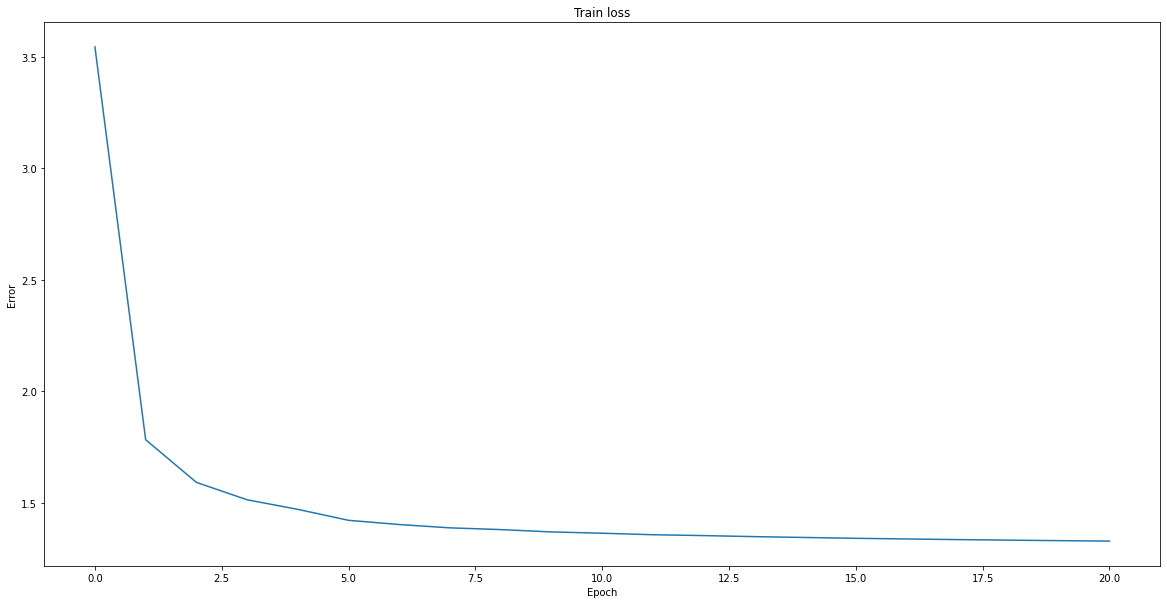

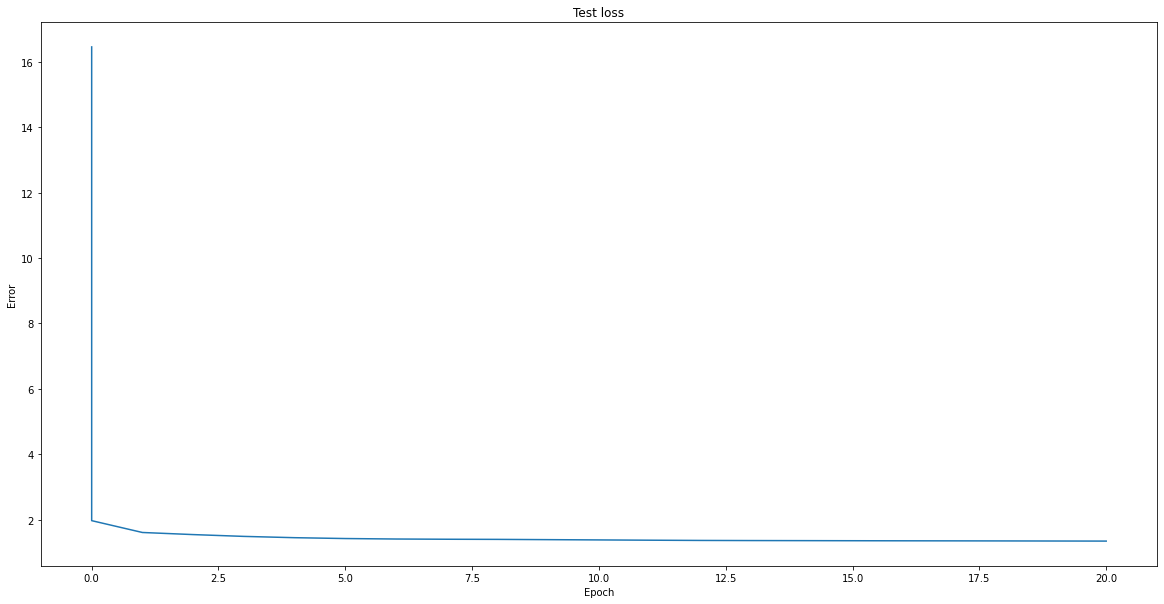

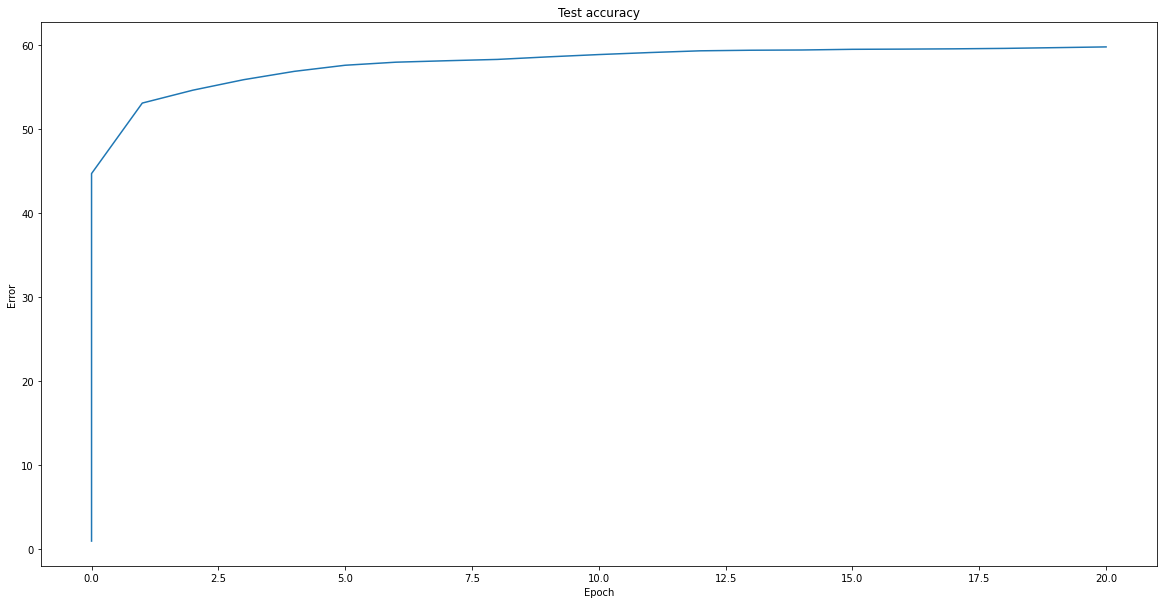

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

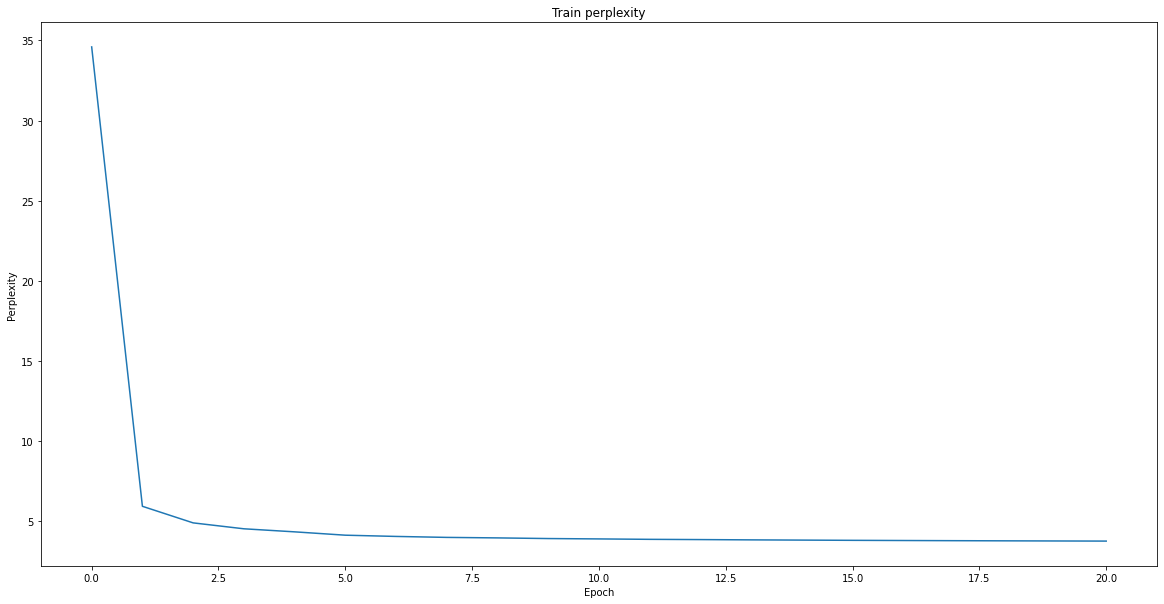

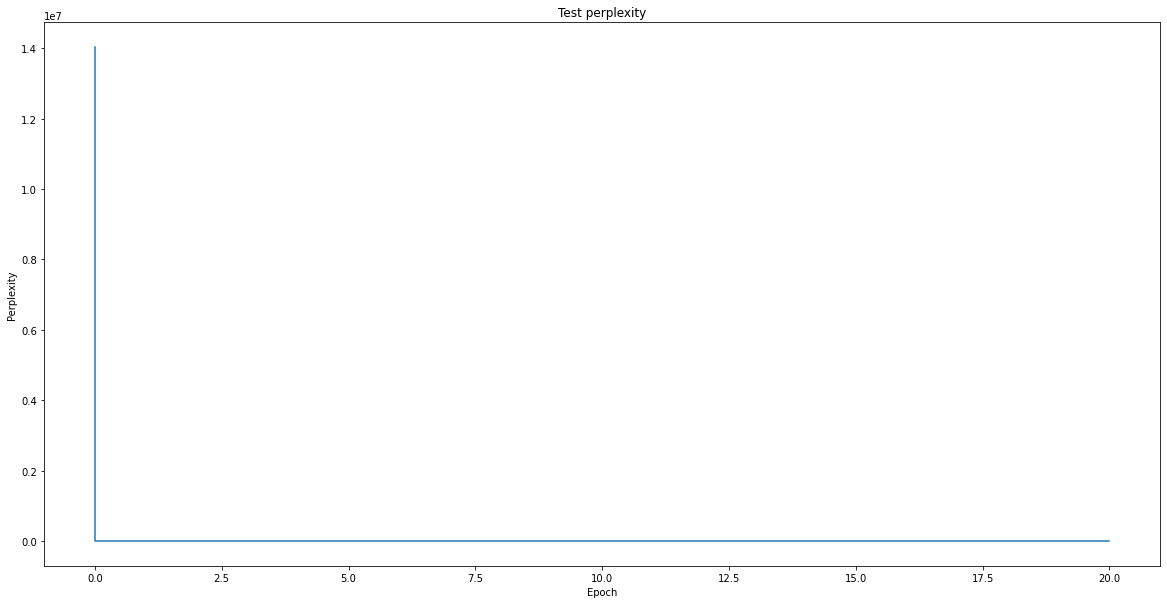

Final test accuracy: 59.74896364795919
Final test perplexity: 3.820187198622891


In [ ]:
LOG_PATH = DATA_PATH + 'logs/log.pkl'
train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
ep, val = zip(*train_losses)
train_perplexity = np.exp(val)
pt_util.plot(ep, train_perplexity, 'Train perplexity', 'Epoch', 'Perplexity')
ep, val = zip(*test_losses)
test_perplexity = np.exp(val)
pt_util.plot(ep, test_perplexity, 'Test perplexity', 'Epoch', 'Perplexity')
print('Final test accuracy: {}'.format(test_accuracies[-1][1]))
print('Final test perplexity: {}'.format(test_perplexity[-1]))

#Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'She looked up, and saw '
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 She looked up, and saw the stairs and said, "I said the portrait to the parchment when he was all started to the back of the corner and said, "I said the portrait to the parchment when he was all started to the back of the 
generated with sample	 She looked up, and saw the start of the room the shadow stopped snapped in the forest and said, "I have to suppose the way to the portrait was been an all and started to be a long sound of the back of the back of the back o
generated with sample	 She looked up, and saw he was still staring at the stairs and he had been to the parchment behind him. "The word was a bottle of your father and Harry was still the part of the back of the stairs, and the parchment was a sm
generated with sample	 She looked up, and saw down the stairs behind her back and bellowed and staring at the table and looked at the stairs and the potion was still staring at him. "I don't want to take the first time the only was still think yo
generated with 

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



# Other Things 1: Training on Dune

In [ ]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'dune.txt')):
    os.chdir(BASE_PATH)
    !cp dune.txt /content
os.chdir('/content')

In [ ]:
def prepare_data(data_path):
    with open(data_path, encoding="ISO-8859-1") as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = " ".join(data.split())
    
    voc2ind = {}
    ind = 0
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        if char not in voc2ind:
            voc2ind[char] = ind
            ind += 1

    ind2voc = {val: key for key, val in voc2ind.items()}

    split = int(0.8 * len(data))
    train_text = data[:split] # TODO Fill this in
    test_text = data[split:] # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'dune_trilogy_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'dune_trilogy_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'dune.txt')

Using device cuda
num workers: 2
Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	MMMqS3xStTMMTqebrxxxxqxxUR3x-0q//"MM"!Gq00TTxxPbxbx""qGrPlSllsUU,bUU,)xUR3x-U,xlxsxxqx/s00WeK3/OHU1,


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	WqHqqnK66ssMP qiVqxxxxd6/xxxsUUH/HQQQQqxxssssxxYfTTq)qs-"bqsxxxss3N"bPi xsUUfqt)Xqtbx""qGq UUU,sMUU,



Test set: Average loss: 15.9105, Accuracy: 7467/512000 (1%)



  3%|▎         | 2/77 [00:00<00:15,  4.85it/s]

Train Epoch: 0 [0/19712 (0%)]	Loss: 15.796041


 16%|█▌        | 12/77 [00:02<00:10,  6.31it/s]

Train Epoch: 0 [2560/19712 (13%)]	Loss: 10.991159


 29%|██▊       | 22/77 [00:03<00:08,  6.50it/s]

Train Epoch: 0 [5120/19712 (26%)]	Loss: 5.885567


 42%|████▏     | 32/77 [00:05<00:06,  6.47it/s]

Train Epoch: 0 [7680/19712 (39%)]	Loss: 3.844625


 55%|█████▍    | 42/77 [00:06<00:05,  6.55it/s]

Train Epoch: 0 [10240/19712 (52%)]	Loss: 2.886388


 68%|██████▊   | 52/77 [00:08<00:03,  6.41it/s]

Train Epoch: 0 [12800/19712 (65%)]	Loss: 2.567912


 81%|████████  | 62/77 [00:09<00:02,  6.49it/s]

Train Epoch: 0 [15360/19712 (78%)]	Loss: 2.953524


 94%|█████████▎| 72/77 [00:11<00:00,  6.51it/s]

Train Epoch: 0 [17920/19712 (91%)]	Loss: 2.683518


100%|██████████| 77/77 [00:11<00:00,  6.45it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	d  "A  Rue eitortit, tiiatd d"tt  dd " "essica tiid. "Sut ooe   tto ttaat  d aoes  .tt tft spdner  n


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	me aaece ooth af thes tof t aoaecn n  the tont ted t ron  bath to targgt r " tte aaid. "She e aare t



Test set: Average loss: 2.3476, Accuracy: 196166/512000 (38%)

Saved /content/checkpoints_dune_trilogy/000.pt

generated max		 Paul Atreides and Leto Atreides walk into a bar. The wat ablowat the to the Duke aroul that thin this calleck of the to the to the Duke aroul that thin this calleck of the to the to the Duke aroul that thin this calleck of the to the 

  3%|▎         | 2/77 [00:00<00:17,  4.28it/s]

Train Epoch: 1 [0/19712 (0%)]	Loss: 2.299717


 16%|█▌        | 12/77 [00:02<00:10,  6.03it/s]

Train Epoch: 1 [2560/19712 (13%)]	Loss: 2.110105


 29%|██▊       | 22/77 [00:03<00:08,  6.40it/s]

Train Epoch: 1 [5120/19712 (26%)]	Loss: 2.348536


 42%|████▏     | 32/77 [00:05<00:06,  6.46it/s]

Train Epoch: 1 [7680/19712 (39%)]	Loss: 3.126688


 55%|█████▍    | 42/77 [00:06<00:05,  6.29it/s]

Train Epoch: 1 [10240/19712 (52%)]	Loss: 2.483023


 68%|██████▊   | 52/77 [00:08<00:03,  6.45it/s]

Train Epoch: 1 [12800/19712 (65%)]	Loss: 2.130962


 81%|████████  | 62/77 [00:09<00:02,  6.37it/s]

Train Epoch: 1 [15360/19712 (78%)]	Loss: 2.024595


 94%|█████████▎| 72/77 [00:11<00:00,  6.34it/s]

Train Epoch: 1 [17920/19712 (91%)]	Loss: 2.088336


100%|██████████| 77/77 [00:12<00:00,  6.32it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	r  "Wt whe iitassedg thoeider tt  rr   hessica shid. "Yut the e wwe hhooiderethes   tt trr ssdvereel


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	ve teect tach ht thes sotht oeaeer nd the ragtene  trhoi  tith ha tirght r   hhe said. "Yhere ware t



Test set: Average loss: 2.0882, Accuracy: 218045/512000 (43%)

Saved /content/checkpoints_dune_trilogy/001.pt

generated max		 Paul Atreides and Leto Atreides walk into a bar. The was had been the read it she was had on the read it she was though had been the read to the read it she was had on the read it she was though had been the read to the read it she wa

  3%|▎         | 2/77 [00:00<00:14,  5.28it/s]

Train Epoch: 2 [0/19712 (0%)]	Loss: 2.047809


 16%|█▌        | 12/77 [00:02<00:10,  6.11it/s]

Train Epoch: 2 [2560/19712 (13%)]	Loss: 1.903272


 29%|██▊       | 22/77 [00:03<00:08,  6.39it/s]

Train Epoch: 2 [5120/19712 (26%)]	Loss: 1.830325


 42%|████▏     | 32/77 [00:05<00:07,  6.40it/s]

Train Epoch: 2 [7680/19712 (39%)]	Loss: 1.789638


 55%|█████▍    | 42/77 [00:06<00:05,  6.35it/s]

Train Epoch: 2 [10240/19712 (52%)]	Loss: 2.659639


 68%|██████▊   | 52/77 [00:08<00:03,  6.49it/s]

Train Epoch: 2 [12800/19712 (65%)]	Loss: 2.279243


 81%|████████  | 62/77 [00:09<00:02,  6.35it/s]

Train Epoch: 2 [15360/19712 (78%)]	Loss: 1.957816


 94%|█████████▎| 72/77 [00:11<00:00,  6.30it/s]

Train Epoch: 2 [17920/19712 (91%)]	Loss: 1.848553


100%|██████████| 77/77 [00:12<00:00,  6.36it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	r  "At'wuet,itors,og tpoutger"tn  rd,  tessica said. "Iut the e wre ttootger toeng  wn trr ppoverstd


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	ve tuict tash af thes tovht ooaenn ng ohe ront red trhurerthth ta sorght r " the said. "Wheye'wore t



Test set: Average loss: 1.8806, Accuracy: 226583/512000 (44%)

Saved /content/checkpoints_dune_trilogy/002.pt

generated max		 Paul Atreides and Leto Atreides walk into a bar. "They've been where the door the remain or reature." "What your son of the the tropport of the traing or the remain or reature." "What your son of the the tropport of the traing or the 

  3%|▎         | 2/77 [00:00<00:16,  4.45it/s]

Train Epoch: 3 [0/19712 (0%)]	Loss: 1.834142


 16%|█▌        | 12/77 [00:02<00:10,  5.98it/s]

Train Epoch: 3 [2560/19712 (13%)]	Loss: 1.938806


 29%|██▊       | 22/77 [00:03<00:08,  6.26it/s]

Train Epoch: 3 [5120/19712 (26%)]	Loss: 1.854954


 42%|████▏     | 32/77 [00:05<00:07,  6.36it/s]

Train Epoch: 3 [7680/19712 (39%)]	Loss: 1.824134


 55%|█████▍    | 42/77 [00:06<00:05,  6.53it/s]

Train Epoch: 3 [10240/19712 (52%)]	Loss: 1.944345


 68%|██████▊   | 52/77 [00:08<00:03,  6.37it/s]

Train Epoch: 3 [12800/19712 (65%)]	Loss: 1.894779


 81%|████████  | 62/77 [00:09<00:02,  6.36it/s]

Train Epoch: 3 [15360/19712 (78%)]	Loss: 1.884493


 94%|█████████▎| 72/77 [00:11<00:00,  6.38it/s]

Train Epoch: 3 [17920/19712 (91%)]	Loss: 1.726400


100%|██████████| 77/77 [00:12<00:00,  6.28it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	r  "W  wuem,etorseog ttoonded"tt ord,  hessica said. "Iut the e wte taoonded,ooesgs tn tnr spdversel


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	ve teect tesh af thes toght oiaevn ng she sogt ne  trwune thth tu torght r,  hhe said. "Iheye'ware t



Test set: Average loss: 1.7478, Accuracy: 242404/512000 (47%)

Saved /content/checkpoints_dune_trilogy/003.pt

generated max		 Paul Atreides and Leto Atreides walk into a bar. "What is the more to the troop of the trands, the took of the troop to the trands, the took of the troop to the trands, the took of the troop to the trands, the took of the troop to the

  3%|▎         | 2/77 [00:00<00:14,  5.20it/s]

Train Epoch: 4 [0/19712 (0%)]	Loss: 1.707559


 16%|█▌        | 12/77 [00:01<00:10,  6.35it/s]

Train Epoch: 4 [2560/19712 (13%)]	Loss: 1.853889


 29%|██▊       | 22/77 [00:03<00:08,  6.40it/s]

Train Epoch: 4 [5120/19712 (26%)]	Loss: 1.898808


 42%|████▏     | 32/77 [00:05<00:06,  6.43it/s]

Train Epoch: 4 [7680/19712 (39%)]	Loss: 1.709589


 55%|█████▍    | 42/77 [00:06<00:05,  6.26it/s]

Train Epoch: 4 [10240/19712 (52%)]	Loss: 1.659370


 68%|██████▊   | 52/77 [00:08<00:04,  6.22it/s]

Train Epoch: 4 [12800/19712 (65%)]	Loss: 1.642080


 81%|████████  | 62/77 [00:09<00:02,  6.40it/s]

Train Epoch: 4 [15360/19712 (78%)]	Loss: 1.667469


 94%|█████████▎| 72/77 [00:11<00:00,  6.44it/s]

Train Epoch: 4 [17920/19712 (91%)]	Loss: 1.635380


100%|██████████| 77/77 [00:12<00:00,  6.35it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	r" "A  waem,eaarseng taaanded"tn ,rd,  hessica said. "Tut the e wne taoonded toeng  wn tfr ppdversel


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	ve teect tash af thes weght heaevn ng the want ne  trmune thth ta finght r   hhe said. "Wheye'whre t



Test set: Average loss: 1.6814, Accuracy: 248302/512000 (48%)

Saved /content/checkpoints_dune_trilogy/004.pt

generated max		 Paul Atreides and Leto Atreides walk into a bar. "What is the man and the man and the man and the the water the water the water the water the water the water the water the water the water the water the water the water the water the wa

  3%|▎         | 2/77 [00:00<00:17,  4.39it/s]

Train Epoch: 5 [0/19712 (0%)]	Loss: 1.637602


 16%|█▌        | 12/77 [00:02<00:10,  6.03it/s]

Train Epoch: 5 [2560/19712 (13%)]	Loss: 1.662639


 29%|██▊       | 22/77 [00:03<00:08,  6.33it/s]

Train Epoch: 5 [5120/19712 (26%)]	Loss: 1.641089


 42%|████▏     | 32/77 [00:05<00:07,  6.27it/s]

Train Epoch: 5 [7680/19712 (39%)]	Loss: 1.666959


 55%|█████▍    | 42/77 [00:06<00:05,  6.42it/s]

Train Epoch: 5 [10240/19712 (52%)]	Loss: 1.747465


 68%|██████▊   | 52/77 [00:08<00:03,  6.40it/s]

Train Epoch: 5 [12800/19712 (65%)]	Loss: 1.866851


 81%|████████  | 62/77 [00:10<00:02,  6.21it/s]

Train Epoch: 5 [15360/19712 (78%)]	Loss: 1.697568


 94%|█████████▎| 72/77 [00:11<00:00,  6.24it/s]

Train Epoch: 5 [17920/19712 (91%)]	Loss: 1.622183


100%|██████████| 77/77 [00:12<00:00,  6.25it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	d  "Wt waemeetassang taaanged"tn  rn,  hessica said. "Tut the e wre taooigedstoengs wn tur sptversen


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	ve neeat tesh af thes weght oiaevneng the sentene  trmune tith tu forght r " hhe said. "Wheye'ware t



Test set: Average loss: 1.6407, Accuracy: 252236/512000 (49%)

Saved /content/checkpoints_dune_trilogy/005.pt

generated max		 Paul Atreides and Leto Atreides walk into a bar. The was a man and the sand of the sand of the sand of the sand of the sand of the sand of the sand on the sand of the sand of the sand of the sand of the sand on the sand of the sand of

  3%|▎         | 2/77 [00:00<00:14,  5.31it/s]

Train Epoch: 6 [0/19712 (0%)]	Loss: 1.597024


 16%|█▌        | 12/77 [00:02<00:10,  6.34it/s]

Train Epoch: 6 [2560/19712 (13%)]	Loss: 1.601135


 29%|██▊       | 22/77 [00:03<00:08,  6.42it/s]

Train Epoch: 6 [5120/19712 (26%)]	Loss: 1.565042


 42%|████▏     | 32/77 [00:05<00:07,  6.30it/s]

Train Epoch: 6 [7680/19712 (39%)]	Loss: 1.638040


 55%|█████▍    | 42/77 [00:06<00:05,  6.13it/s]

Train Epoch: 6 [10240/19712 (52%)]	Loss: 1.653948


 68%|██████▊   | 52/77 [00:08<00:04,  6.18it/s]

Train Epoch: 6 [12800/19712 (65%)]	Loss: 1.600246


 81%|████████  | 62/77 [00:09<00:02,  6.34it/s]

Train Epoch: 6 [15360/19712 (78%)]	Loss: 1.575301


 94%|█████████▎| 72/77 [00:11<00:00,  6.20it/s]

Train Epoch: 6 [17920/19712 (91%)]	Loss: 1.557568


100%|██████████| 77/77 [00:12<00:00,  6.29it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	   "Tt wue eeiesseng tooonsed"tn irn,  hessica said. "Tut the e wse oaoongedsooesgs wn tfr ppdversen


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	ve yeead tesh af thes weght biaevneng the sans ne  ormune tith te firght r   hhe said. "Theye ware t



Test set: Average loss: 1.5853, Accuracy: 257838/512000 (50%)

Saved /content/checkpoints_dune_trilogy/006.pt

generated max		 Paul Atreides and Leto Atreides walk into a bar. "What is is a distruct in the sand of the sand of the sand of the sand of the sing the sink of the sand of the sing the sink of the sand of the sing the sink of the sand of the sing the

  3%|▎         | 2/77 [00:00<00:17,  4.38it/s]

Train Epoch: 7 [0/19712 (0%)]	Loss: 1.549169


 16%|█▌        | 12/77 [00:02<00:10,  5.97it/s]

Train Epoch: 7 [2560/19712 (13%)]	Loss: 1.548793


 29%|██▊       | 22/77 [00:03<00:08,  6.32it/s]

Train Epoch: 7 [5120/19712 (26%)]	Loss: 1.545396


 42%|████▏     | 32/77 [00:05<00:07,  6.37it/s]

Train Epoch: 7 [7680/19712 (39%)]	Loss: 1.611218


 55%|█████▍    | 42/77 [00:06<00:05,  6.30it/s]

Train Epoch: 7 [10240/19712 (52%)]	Loss: 1.602784


 68%|██████▊   | 52/77 [00:08<00:03,  6.35it/s]

Train Epoch: 7 [12800/19712 (65%)]	Loss: 1.632808


 81%|████████  | 62/77 [00:10<00:02,  6.25it/s]

Train Epoch: 7 [15360/19712 (78%)]	Loss: 1.586079


 94%|█████████▎| 72/77 [00:11<00:00,  6.39it/s]

Train Epoch: 7 [17920/19712 (91%)]	Loss: 1.578251


100%|██████████| 77/77 [00:12<00:00,  6.28it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	   "I  wae e iasseog taoanser"bn irn,  hessica said. "Iut ihe e wre yaooiger,ooesgs wn tur cptversen


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	ve yeeat tesh af thes deght aiaeoneng the sensrre  ircune tith ae firght r " hhe said. "Iheye'were w



Test set: Average loss: 1.5799, Accuracy: 258443/512000 (50%)

Saved /content/checkpoints_dune_trilogy/007.pt

generated max		 Paul Atreides and Leto Atreides walk into a bar. "We must be door did not down the said. "I will dis come from the said. "I will dis come from the said. "I will dis come from the said. "I will dis come from the said. "I will dis come 

  3%|▎         | 2/77 [00:00<00:13,  5.52it/s]

Train Epoch: 8 [0/19712 (0%)]	Loss: 1.541329


 16%|█▌        | 12/77 [00:02<00:10,  6.08it/s]

Train Epoch: 8 [2560/19712 (13%)]	Loss: 1.538512


 29%|██▊       | 22/77 [00:03<00:08,  6.29it/s]

Train Epoch: 8 [5120/19712 (26%)]	Loss: 1.555187


 42%|████▏     | 32/77 [00:05<00:07,  6.28it/s]

Train Epoch: 8 [7680/19712 (39%)]	Loss: 1.570255


 55%|█████▍    | 42/77 [00:06<00:05,  6.32it/s]

Train Epoch: 8 [10240/19712 (52%)]	Loss: 1.622210


 68%|██████▊   | 52/77 [00:08<00:03,  6.37it/s]

Train Epoch: 8 [12800/19712 (65%)]	Loss: 1.565984


 81%|████████  | 62/77 [00:09<00:02,  6.46it/s]

Train Epoch: 8 [15360/19712 (78%)]	Loss: 1.562324


 94%|█████████▎| 72/77 [00:11<00:00,  6.16it/s]

Train Epoch: 8 [17920/19712 (91%)]	Loss: 1.522800


100%|██████████| 77/77 [00:12<00:00,  6.31it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	r" "It waeme orsseng tarinsed"tn irn,  hessica said. "Iut the e,wre yarinsedsooesgs wn tur ppiversen


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	ve heead tysh af thes weght aiaeeneng the ransrne  arwune tith tu firght r." hhe said. "Ihere'wire t



Test set: Average loss: 1.5664, Accuracy: 257827/512000 (50%)

generated max		 Paul Atreides and Leto Atreides walk into a bar. "It will tried to the surface. "It will tried to the surface. "It will tried to the surface. "It will tried to the surface. "It will tried to the surface. "It will tried to the surface. "It will tried
generated sample	 Paul Atreides 

  3%|▎         | 2/77 [00:00<00:17,  4.39it/s]

Train Epoch: 9 [0/19712 (0%)]	Loss: 1.526807


 16%|█▌        | 12/77 [00:02<00:10,  6.04it/s]

Train Epoch: 9 [2560/19712 (13%)]	Loss: 1.520309


 29%|██▊       | 22/77 [00:03<00:08,  6.35it/s]

Train Epoch: 9 [5120/19712 (26%)]	Loss: 1.494794


 42%|████▏     | 32/77 [00:05<00:07,  6.35it/s]

Train Epoch: 9 [7680/19712 (39%)]	Loss: 1.478492


 55%|█████▍    | 42/77 [00:06<00:05,  6.39it/s]

Train Epoch: 9 [10240/19712 (52%)]	Loss: 1.476446


 68%|██████▊   | 52/77 [00:08<00:03,  6.37it/s]

Train Epoch: 9 [12800/19712 (65%)]	Loss: 1.490436


 81%|████████  | 62/77 [00:10<00:02,  6.32it/s]

Train Epoch: 9 [15360/19712 (78%)]	Loss: 1.562976


 94%|█████████▎| 72/77 [00:11<00:00,  6.32it/s]

Train Epoch: 9 [17920/19712 (91%)]	Loss: 1.536139


100%|██████████| 77/77 [00:12<00:00,  6.26it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	 " "It wae e oasseog iooonger"hn irn,  hessica said. "Iut whe e wre yooongersooesgs wn hrr ppiversen


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	ve heoad oysh ff hhes deght biaeoneng hhe sansrre  irwude hith hu morghter " hhe said. "Ihere'ware s



Test set: Average loss: 1.5621, Accuracy: 258303/512000 (50%)

generated max		 Paul Atreides and Leto Atreides walk into a bar. "I will be my father," he said. "It was a markers with his more the surface. "It was a markers with his more the surface. "It was a markers with his more the surface. "It was a markers with his more t
generated sample	 Paul Atreides 

  3%|▎         | 2/77 [00:00<00:15,  4.96it/s]

Train Epoch: 10 [0/19712 (0%)]	Loss: 1.527466


 16%|█▌        | 12/77 [00:02<00:10,  6.27it/s]

Train Epoch: 10 [2560/19712 (13%)]	Loss: 1.513574


 29%|██▊       | 22/77 [00:03<00:08,  6.35it/s]

Train Epoch: 10 [5120/19712 (26%)]	Loss: 1.517562


 42%|████▏     | 32/77 [00:05<00:07,  6.16it/s]

Train Epoch: 10 [7680/19712 (39%)]	Loss: 1.504379


 55%|█████▍    | 42/77 [00:06<00:05,  6.31it/s]

Train Epoch: 10 [10240/19712 (52%)]	Loss: 1.496576


 68%|██████▊   | 52/77 [00:08<00:03,  6.29it/s]

Train Epoch: 10 [12800/19712 (65%)]	Loss: 1.485225


 81%|████████  | 62/77 [00:09<00:02,  6.34it/s]

Train Epoch: 10 [15360/19712 (78%)]	Loss: 1.504897


 94%|█████████▎| 72/77 [00:11<00:00,  6.29it/s]

Train Epoch: 10 [17920/19712 (91%)]	Loss: 1.493021


100%|██████████| 77/77 [00:12<00:00,  6.29it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	   "It wae e oasseng tuainge "hn irn,  hessica said. "Iut the e wre yuoonge sooesgs wn tfr ppiverse.


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	ve yeoad tesh af thes peght biaeoneng the sansrne  arwune tith te mirght r " hhe said. "Ihe e were m



Test set: Average loss: 1.5147, Accuracy: 266744/512000 (52%)

Saved /content/checkpoints_dune_trilogy/010.pt

generated max		 Paul Atreides and Leto Atreides walk into a bar. "It was a man with a subtle in my father and the such a call of the sand of the sand of the sand of the sand of the sand of the sand of the sand of the sand of the sand of the sand of t

  3%|▎         | 2/77 [00:00<00:17,  4.30it/s]

Train Epoch: 11 [0/19712 (0%)]	Loss: 1.477284


 16%|█▌        | 12/77 [00:02<00:10,  6.06it/s]

Train Epoch: 11 [2560/19712 (13%)]	Loss: 1.478563


 29%|██▊       | 22/77 [00:03<00:08,  6.39it/s]

Train Epoch: 11 [5120/19712 (26%)]	Loss: 1.475806


 42%|████▏     | 32/77 [00:05<00:07,  6.42it/s]

Train Epoch: 11 [7680/19712 (39%)]	Loss: 1.457054


 55%|█████▍    | 42/77 [00:06<00:05,  6.34it/s]

Train Epoch: 11 [10240/19712 (52%)]	Loss: 1.454544


 68%|██████▊   | 52/77 [00:08<00:04,  6.24it/s]

Train Epoch: 11 [12800/19712 (65%)]	Loss: 1.450520


 81%|████████  | 62/77 [00:10<00:02,  6.11it/s]

Train Epoch: 11 [15360/19712 (78%)]	Loss: 1.474823


 94%|█████████▎| 72/77 [00:11<00:00,  6.16it/s]

Train Epoch: 11 [17920/19712 (91%)]	Loss: 1.479766


100%|██████████| 77/77 [00:12<00:00,  6.25it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	   "It wue e oesseng tuoinge "tn irn,  hessica said. "Iut the e wte tuoinge sooengs on tfr pniversen


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	le teeed tesh tf thes peght bimeoneng the sensrne  o wune tith te merghter " hhe said. "Ihe e were t



Test set: Average loss: 1.5138, Accuracy: 268240/512000 (52%)

Saved /content/checkpoints_dune_trilogy/011.pt

generated max		 Paul Atreides and Leto Atreides walk into a bar. "It was the subtle for the such a call of the such a call of the such a call of the such a sent of the subtle from the sietched her to the subtle from the sietched her to the subtle fro

  3%|▎         | 2/77 [00:00<00:14,  5.19it/s]

Train Epoch: 12 [0/19712 (0%)]	Loss: 1.473756


 16%|█▌        | 12/77 [00:02<00:10,  6.16it/s]

Train Epoch: 12 [2560/19712 (13%)]	Loss: 1.481981


 29%|██▊       | 22/77 [00:03<00:08,  6.27it/s]

Train Epoch: 12 [5120/19712 (26%)]	Loss: 1.463594


 42%|████▏     | 32/77 [00:05<00:07,  6.34it/s]

Train Epoch: 12 [7680/19712 (39%)]	Loss: 1.431851


 55%|█████▍    | 42/77 [00:06<00:05,  6.23it/s]

Train Epoch: 12 [10240/19712 (52%)]	Loss: 1.430198


 68%|██████▊   | 52/77 [00:08<00:03,  6.34it/s]

Train Epoch: 12 [12800/19712 (65%)]	Loss: 1.457698


 81%|████████  | 62/77 [00:10<00:02,  6.21it/s]

Train Epoch: 12 [15360/19712 (78%)]	Loss: 1.496115


 94%|█████████▎| 72/77 [00:11<00:00,  6.37it/s]

Train Epoch: 12 [17920/19712 (91%)]	Loss: 1.477966


100%|██████████| 77/77 [00:12<00:00,  6.27it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	   "It wae e orsseng iuaiige "ht irn,  hessica said. "Iut ihe e wre yuooige sooesgs wn trr ppiverse,


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	le yeoad oesh af dhes peght biaeoneng ohe sensane  a wuke iith ae morghter " hhe said. "Ihere'were s



Test set: Average loss: 1.5148, Accuracy: 266500/512000 (52%)

generated max		 Paul Atreides and Leto Atreides walk into a bar. "It was a call me with a suble of my father is all of my father silence," Paul said. "It was a call me with a suble of my father is all of my father silence," Paul said. "It was a call me with a suble
generated sample	 Paul Atreides 

  3%|▎         | 2/77 [00:00<00:17,  4.26it/s]

Train Epoch: 13 [0/19712 (0%)]	Loss: 1.482009


 16%|█▌        | 12/77 [00:02<00:10,  6.06it/s]

Train Epoch: 13 [2560/19712 (13%)]	Loss: 1.469155


 29%|██▊       | 22/77 [00:03<00:08,  6.32it/s]

Train Epoch: 13 [5120/19712 (26%)]	Loss: 1.480129


 42%|████▏     | 32/77 [00:05<00:07,  6.25it/s]

Train Epoch: 13 [7680/19712 (39%)]	Loss: 1.428448


 55%|█████▍    | 42/77 [00:06<00:05,  6.31it/s]

Train Epoch: 13 [10240/19712 (52%)]	Loss: 1.421681


 68%|██████▊   | 52/77 [00:08<00:04,  6.16it/s]

Train Epoch: 13 [12800/19712 (65%)]	Loss: 1.442190


 81%|████████  | 62/77 [00:10<00:02,  6.32it/s]

Train Epoch: 13 [15360/19712 (78%)]	Loss: 1.450689


 94%|█████████▎| 72/77 [00:11<00:00,  6.26it/s]

Train Epoch: 13 [17920/19712 (91%)]	Loss: 1.449572


100%|██████████| 77/77 [00:12<00:00,  6.20it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	   "It wae e oasseng tuainge "tt ird,  hessica said. "Iut the e wre tuounge sooesgs wn tur pniverse 


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	le teoad tesh tf thes peght beaeon ng the sensane  a wuke thth te morght r " hhe said. "Ihe e we e t



Test set: Average loss: 1.4694, Accuracy: 273448/512000 (53%)

Saved /content/checkpoints_dune_trilogy/013.pt

generated max		 Paul Atreides and Leto Atreides walk into a bar. "It was a man while this man while the subtle in the such a call of the such a call of the such a call of the subtle from the subtle from the subtle from the sand of the subtle from the

  3%|▎         | 2/77 [00:00<00:14,  5.16it/s]

Train Epoch: 14 [0/19712 (0%)]	Loss: 1.433643


 16%|█▌        | 12/77 [00:02<00:10,  6.07it/s]

Train Epoch: 14 [2560/19712 (13%)]	Loss: 1.446482


 29%|██▊       | 22/77 [00:03<00:08,  6.26it/s]

Train Epoch: 14 [5120/19712 (26%)]	Loss: 1.455618


 42%|████▏     | 32/77 [00:05<00:07,  6.26it/s]

Train Epoch: 14 [7680/19712 (39%)]	Loss: 1.466583


 55%|█████▍    | 42/77 [00:06<00:05,  6.27it/s]

Train Epoch: 14 [10240/19712 (52%)]	Loss: 1.437016


 68%|██████▊   | 52/77 [00:08<00:03,  6.31it/s]

Train Epoch: 14 [12800/19712 (65%)]	Loss: 1.433621


 81%|████████  | 62/77 [00:10<00:02,  6.31it/s]

Train Epoch: 14 [15360/19712 (78%)]	Loss: 1.454948


 94%|█████████▎| 72/77 [00:11<00:00,  6.32it/s]

Train Epoch: 14 [17920/19712 (91%)]	Loss: 1.448219


100%|██████████| 77/77 [00:12<00:00,  6.27it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	   "It wae e oorseng iuainge "hn ird,  hessica said. "Iut ihe e wre yuoinge sooesgs wn tur pniverse.


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	le heoad oesh af thes peght biaeon ng the sensane  a wune tith ae monghter." hhe said. "Ihere'were s



Test set: Average loss: 1.4704, Accuracy: 272169/512000 (53%)

generated max		 Paul Atreides and Leto Atreides walk into a bar. "It was a man with a call me to see it with a call me to see it with a call me to see it with a call me to see it with a call me to see it with a call me to see it with a call me to see it with his mo
generated sample	 Paul Atreides 

  3%|▎         | 2/77 [00:00<00:18,  4.16it/s]

Train Epoch: 15 [0/19712 (0%)]	Loss: 1.434262


 16%|█▌        | 12/77 [00:02<00:10,  5.98it/s]

Train Epoch: 15 [2560/19712 (13%)]	Loss: 1.441839


 29%|██▊       | 22/77 [00:03<00:08,  6.31it/s]

Train Epoch: 15 [5120/19712 (26%)]	Loss: 1.433522


 42%|████▏     | 32/77 [00:05<00:07,  6.23it/s]

Train Epoch: 15 [7680/19712 (39%)]	Loss: 1.406595


 55%|█████▍    | 42/77 [00:06<00:05,  6.28it/s]

Train Epoch: 15 [10240/19712 (52%)]	Loss: 1.416247


 68%|██████▊   | 52/77 [00:08<00:04,  6.22it/s]

Train Epoch: 15 [12800/19712 (65%)]	Loss: 1.418595


 81%|████████  | 62/77 [00:10<00:02,  6.30it/s]

Train Epoch: 15 [15360/19712 (78%)]	Loss: 1.459834


 94%|█████████▎| 72/77 [00:11<00:00,  6.30it/s]

Train Epoch: 15 [17920/19712 (91%)]	Loss: 1.456232


100%|██████████| 77/77 [00:12<00:00,  6.21it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	   "It wae e oorseng toaanger"tn ird,  hessica said. "Iut the e'wre oeaongersooesgs on tur pniverse.


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	le heoad oesh tf thes peght beaeoneng ohe sensane  a wune thth ae morghter." hhe said. "Ihere'were t



Test set: Average loss: 1.4738, Accuracy: 270506/512000 (53%)

generated max		 Paul Atreides and Leto Atreides walk into a bar. "It was a man who were the sietch," he said. "It was a man who were the sietch," he said. "It was a man who were the sietch," he said. "It was a man who were the sietch," he said. "It was a man who we
generated sample	 Paul Atreides 

  3%|▎         | 2/77 [00:00<00:14,  5.10it/s]

Train Epoch: 16 [0/19712 (0%)]	Loss: 1.438132


 16%|█▌        | 12/77 [00:02<00:10,  6.00it/s]

Train Epoch: 16 [2560/19712 (13%)]	Loss: 1.443819


 29%|██▊       | 22/77 [00:03<00:08,  6.33it/s]

Train Epoch: 16 [5120/19712 (26%)]	Loss: 1.437667


 42%|████▏     | 32/77 [00:05<00:07,  6.39it/s]

Train Epoch: 16 [7680/19712 (39%)]	Loss: 1.441150


 55%|█████▍    | 42/77 [00:06<00:05,  6.26it/s]

Train Epoch: 16 [10240/19712 (52%)]	Loss: 1.408540


 68%|██████▊   | 52/77 [00:08<00:04,  6.20it/s]

Train Epoch: 16 [12800/19712 (65%)]	Loss: 1.410997


 81%|████████  | 62/77 [00:10<00:02,  6.40it/s]

Train Epoch: 16 [15360/19712 (78%)]	Loss: 1.424364


 94%|█████████▎| 72/77 [00:11<00:00,  6.25it/s]

Train Epoch: 16 [17920/19712 (91%)]	Loss: 1.423411


100%|██████████| 77/77 [00:12<00:00,  6.27it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	   "It wae e oasseng ioainge "hn ird,  hessica said. "Iut ihe e wre ooiingersooasgs on trr mniverse.


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	le heead oesh af thes peght biaeoneng ohe sensane  a wune thth ae mirghter." hhe said. "Ihere'were s



Test set: Average loss: 1.4561, Accuracy: 273590/512000 (53%)

Saved /content/checkpoints_dune_trilogy/016.pt

generated max		 Paul Atreides and Leto Atreides walk into a bar. "It was a man with a light of the sietch," he said. "It was a man with a sign of the sietch," she said. "It was a man with a sign of the sietch," she said. "It was a man with a sign of 

  1%|▏         | 1/77 [00:00<00:22,  3.39it/s]

Train Epoch: 17 [0/19712 (0%)]	Loss: 1.421663


 16%|█▌        | 12/77 [00:02<00:10,  6.03it/s]

Train Epoch: 17 [2560/19712 (13%)]	Loss: 1.428357


 29%|██▊       | 22/77 [00:03<00:08,  6.20it/s]

Train Epoch: 17 [5120/19712 (26%)]	Loss: 1.420925


 42%|████▏     | 32/77 [00:05<00:07,  6.20it/s]

Train Epoch: 17 [7680/19712 (39%)]	Loss: 1.409851


 55%|█████▍    | 42/77 [00:06<00:05,  6.29it/s]

Train Epoch: 17 [10240/19712 (52%)]	Loss: 1.388610


 68%|██████▊   | 52/77 [00:08<00:04,  6.13it/s]

Train Epoch: 17 [12800/19712 (65%)]	Loss: 1.402306


 81%|████████  | 62/77 [00:10<00:02,  6.31it/s]

Train Epoch: 17 [15360/19712 (78%)]	Loss: 1.416865


 94%|█████████▎| 72/77 [00:11<00:00,  6.37it/s]

Train Epoch: 17 [17920/19712 (91%)]	Loss: 1.421803


100%|██████████| 77/77 [00:12<00:00,  6.20it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	   "It wae e olsseng ioainge "hn ird   hessica said. "Iut ihe e wre oeiingersooasgs on tur mniverse.


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	le heoad oesh af thes peght biaeon ng ohe sensane  a wune thth ae miyghter." hhe said. "Ihere'were s



Test set: Average loss: 1.4527, Accuracy: 273933/512000 (54%)

Saved /content/checkpoints_dune_trilogy/017.pt

generated max		 Paul Atreides and Leto Atreides walk into a bar. "It was a man will be discuss in the sietch of a sent of the sietch of a sign of a sent of the sietch of a sign of a single of the sietch of his mother. "It was a man will be discuss in

  3%|▎         | 2/77 [00:00<00:14,  5.11it/s]

Train Epoch: 18 [0/19712 (0%)]	Loss: 1.419173


 16%|█▌        | 12/77 [00:01<00:10,  6.30it/s]

Train Epoch: 18 [2560/19712 (13%)]	Loss: 1.420682


 29%|██▊       | 22/77 [00:03<00:08,  6.27it/s]

Train Epoch: 18 [5120/19712 (26%)]	Loss: 1.411717


 42%|████▏     | 32/77 [00:05<00:07,  6.23it/s]

Train Epoch: 18 [7680/19712 (39%)]	Loss: 1.384675


 55%|█████▍    | 42/77 [00:06<00:05,  6.33it/s]

Train Epoch: 18 [10240/19712 (52%)]	Loss: 1.394579


 68%|██████▊   | 52/77 [00:08<00:04,  6.25it/s]

Train Epoch: 18 [12800/19712 (65%)]	Loss: 1.410653


 81%|████████  | 62/77 [00:09<00:02,  6.38it/s]

Train Epoch: 18 [15360/19712 (78%)]	Loss: 1.424353


 94%|█████████▎| 72/77 [00:11<00:00,  6.26it/s]

Train Epoch: 18 [17920/19712 (91%)]	Loss: 1.417494


100%|██████████| 77/77 [00:12<00:00,  6.29it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	   "It wae e oosseng ioaange "hn ird,  hessica said. "Iut ihe e wre oooangersooesgs on hur mniverse.


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	le heead oesh af thes peght biaeon ng ohe sonsane  a wune thth ae miyghter." hhe said. "Ihere'were s



Test set: Average loss: 1.4448, Accuracy: 275541/512000 (54%)

Saved /content/checkpoints_dune_trilogy/018.pt

generated max		 Paul Atreides and Leto Atreides walk into a bar. "It was a man with a child of my father." "It was a man with a child of my mother son whose were the sietch of his mother," he said. "It was a man with a child of my father." "It was a 

  3%|▎         | 2/77 [00:00<00:17,  4.31it/s]

Train Epoch: 19 [0/19712 (0%)]	Loss: 1.411987


 16%|█▌        | 12/77 [00:02<00:10,  6.00it/s]

Train Epoch: 19 [2560/19712 (13%)]	Loss: 1.421649


 29%|██▊       | 22/77 [00:03<00:08,  6.18it/s]

Train Epoch: 19 [5120/19712 (26%)]	Loss: 1.413520


 42%|████▏     | 32/77 [00:05<00:07,  6.40it/s]

Train Epoch: 19 [7680/19712 (39%)]	Loss: 1.388457


 55%|█████▍    | 42/77 [00:06<00:05,  6.30it/s]

Train Epoch: 19 [10240/19712 (52%)]	Loss: 1.378094


 68%|██████▊   | 52/77 [00:08<00:03,  6.40it/s]

Train Epoch: 19 [12800/19712 (65%)]	Loss: 1.393561


 81%|████████  | 62/77 [00:10<00:02,  6.38it/s]

Train Epoch: 19 [15360/19712 (78%)]	Loss: 1.410020


 94%|█████████▎| 72/77 [00:11<00:00,  6.34it/s]

Train Epoch: 19 [17920/19712 (91%)]	Loss: 1.404840


100%|██████████| 77/77 [00:12<00:00,  6.23it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	   "It wae e oosseng ioainger"hn ird,  hessica said. "Iut ihe e wre ooiongersooasgs on hur mniverse.


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	le heoad oosh tf thes peght biaeon ng the sonsane  a wune thth ae miyghter." hhe said. "Ihere'were s



Test set: Average loss: 1.4371, Accuracy: 276857/512000 (54%)

Saved /content/checkpoints_dune_trilogy/019.pt

generated max		 Paul Atreides and Leto Atreides walk into a bar. "It was a man with a can of my father," she said. "It was a man with a can of my father," she said. "It was a man with a can of my father," she said. "It was a man with a can of my fath

  3%|▎         | 2/77 [00:00<00:14,  5.22it/s]

Train Epoch: 20 [0/19712 (0%)]	Loss: 1.404663


 16%|█▌        | 12/77 [00:02<00:10,  6.13it/s]

Train Epoch: 20 [2560/19712 (13%)]	Loss: 1.433909


 29%|██▊       | 22/77 [00:03<00:08,  6.25it/s]

Train Epoch: 20 [5120/19712 (26%)]	Loss: 1.456455


 42%|████▏     | 32/77 [00:05<00:07,  6.20it/s]

Train Epoch: 20 [7680/19712 (39%)]	Loss: 1.390591


 55%|█████▍    | 42/77 [00:06<00:05,  6.35it/s]

Train Epoch: 20 [10240/19712 (52%)]	Loss: 1.378440


 68%|██████▊   | 52/77 [00:08<00:03,  6.31it/s]

Train Epoch: 20 [12800/19712 (65%)]	Loss: 1.393438


 81%|████████  | 62/77 [00:09<00:02,  6.24it/s]

Train Epoch: 20 [15360/19712 (78%)]	Loss: 1.406039


 94%|█████████▎| 72/77 [00:11<00:00,  6.19it/s]

Train Epoch: 20 [17920/19712 (91%)]	Loss: 1.400762


100%|██████████| 77/77 [00:12<00:00,  6.27it/s]


Input	e." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe
GT	." "It seems passing strange, indeed," Jessica said. "But there are stranger things in our universe.
pred	   "It wae e tosseng toaange "ht ied " hessica said. "Iut ihe e wre toiangersooasgs wn tur mniverse.


Input	've spent much of this night reviewing the mistakes I made with my daughter," she said. "There were 
GT	ve spent much of this night reviewing the mistakes I made with my daughter," she said. "There were m
pred	le heead oesh tf thes peght hiaeon tg the sonsane  a wune thth he moyghter." hhe said. "Iheye'were t



Test set: Average loss: 1.4282, Accuracy: 278445/512000 (54%)

Saved /content/checkpoints_dune_trilogy/020.pt

generated max		 Paul Atreides and Leto Atreides walk into a bar. "It was a man with the sietch of the sietch had been the sietch of the sietch had been the sietch had been his mother had been the sietch had been his mother had been the sietch had bee

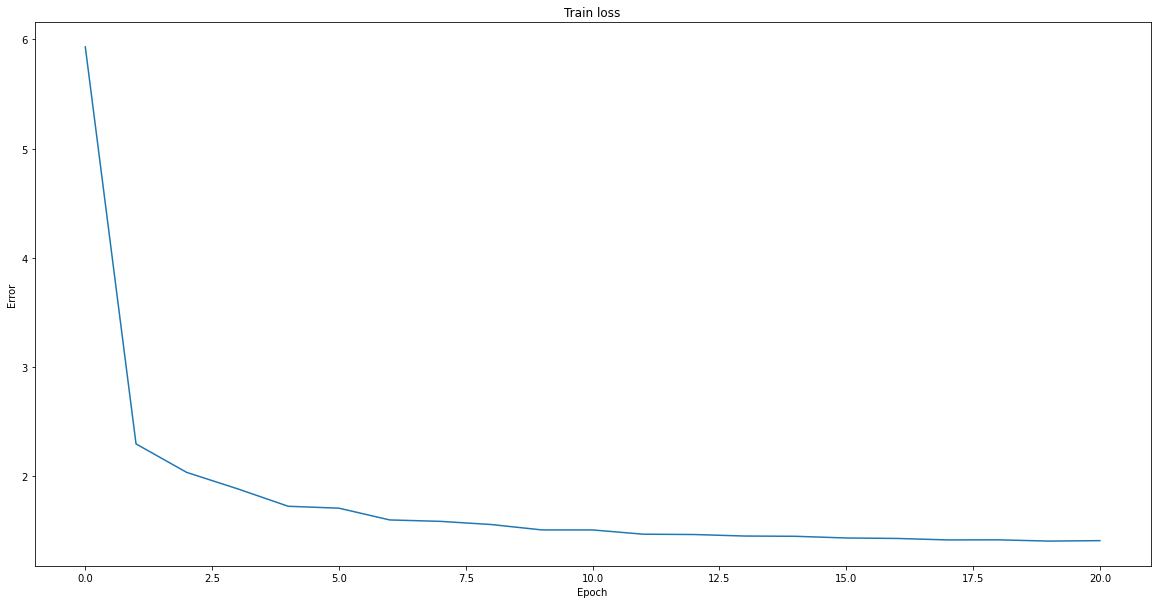

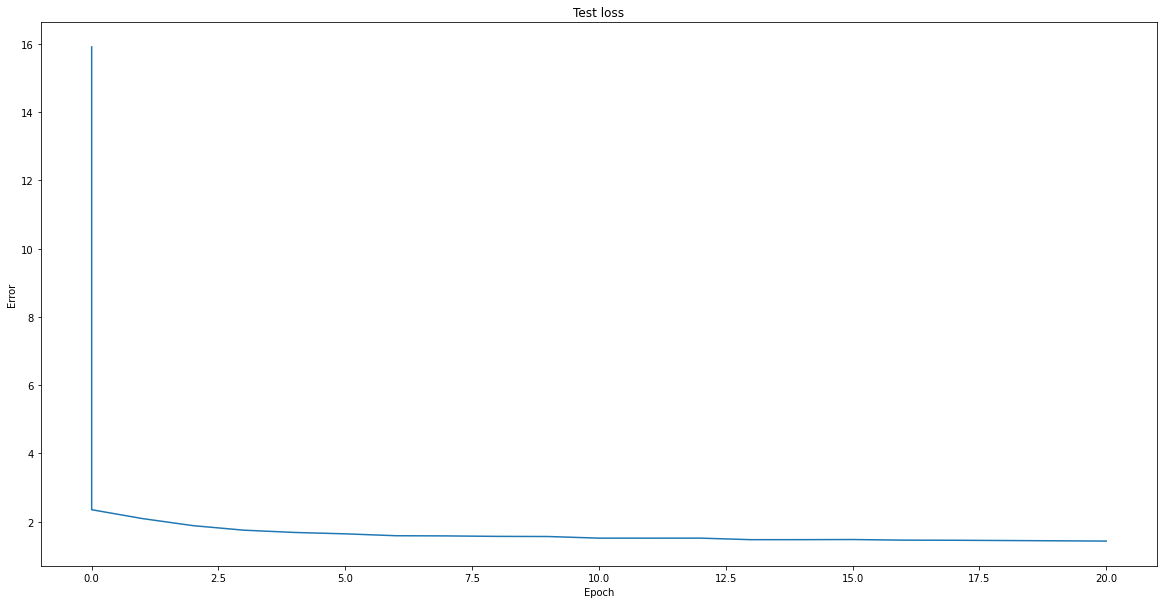

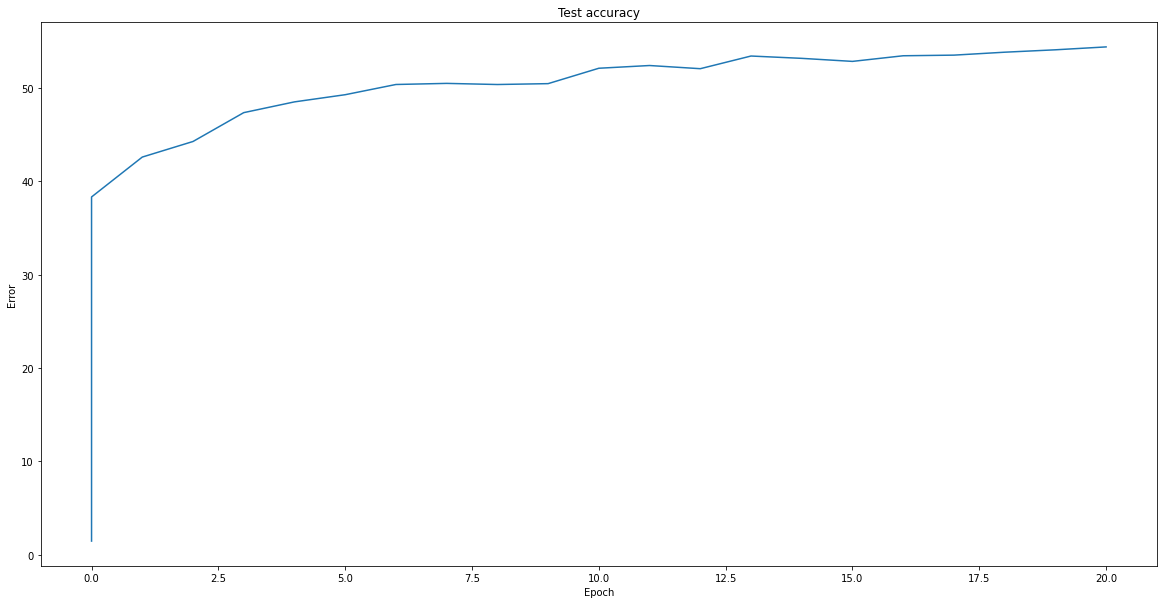

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log_dune_trilogy.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'dune_trilogy_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'dune_trilogy_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_dune_trilogy')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_dune_trilogy/%03d.pt' % epoch)
            seed_words = 'Paul Atreides and Leto Atreides walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_dune_trilogy/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

In [ ]:
with open(DATA_PATH + 'dune_trilogy_chars_train.pkl', 'rb') as data_pkl:
    dataset = pickle.load(data_pkl)

num_train_tokens = len(dataset['tokens'])

with open(DATA_PATH + 'dune_trilogy_chars_test.pkl', 'rb') as data_pkl:
    dataset = pickle.load(data_pkl)

num_test_tokens = len(dataset['tokens'])
print('Number of characters in Dune: {}'.format(num_train_tokens + num_test_tokens))

Number of characters in Dune: 2436191


In [ ]:
# Using default temperature = 1 in model.inference from sampling strategy methods
def eval_final_model(model, vocab, device):
    seed_words = 'Paul Atreides and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Paul Atreides and the sietch had been his mother had been the sietch had been his mother had been the sietch had been his mother had been his mother had been the sietch had been his mother had been his mother had been the
generated with sample	 Paul Atreides and they poort escapet, almost of therebl, can above it glass of parables. "Wattcrod where here he cannot before had potes to the silvere." The had recarding had been lifted signer cannot Faul. Oput side. Fe
generated with sample	 Paul Atreides and therewerely whispering uspectembline. An Parthan must had seen white powers on his minds. "It's more the lant," "One yes." "Womani sopeond the tio's sietched have were obsert." There was on his hand. Byn
generated with sample	 Paul Atreides and the Emperor suit alive's such another--a chirdless of passiness that compones. He grawlers were tahe? Chai-: Sihahadows attacks of full holess, burg7Q-And . . away, fact that shields simple. "Wo'll have 
generated with sample	 

# Other Things 6: Training on Words

In [ ]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = data.split()

    counts = {}
    for word in data:
        if word not in counts:
            counts[word] = 0
        counts[word] += 1
    
    voc2ind = {}
    ind = 0
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for word in data:
        if counts[word] >= 5 and word not in voc2ind:
            voc2ind[word] = ind
            ind += 1
    voc2ind['<UNKNOWN>'] = ind

    print('Size of word vocabulary: {}'.format(len(voc2ind)))

    ind2voc = {val: key for key, val in voc2ind.items()}

    split = int(0.8 * len(data))
    train_text = data[:split] # TODO Fill this in
    test_text = data[split:] # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')

class WordVocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ' '.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] if word in self.voc2ind else self.voc2ind['<UNKNOWN>'] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

Size of word vocabulary: 14403


In [ ]:
class HarryPotterWordDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterWordDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = WordVocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        tokens = dataset['tokens']
        voc2ind = dataset['voc2ind']

        num_tokens = len(tokens) - (len(tokens) % batch_size) # number of tokens to use
        self.data = torch.LongTensor([voc2ind[tokens[i]] if tokens[i] in voc2ind else voc2ind['<UNKNOWN>'] for i in range(num_tokens)]).view(batch_size, -1) # break data into batch_size batches (use .view() for faster ops)
        self.num_sequences = self.data.shape[0] * int(np.ceil((self.data.shape[1] - 1) / self.sequence_length)) # number of batches * number of sequences in a batch

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return self.num_sequences
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        batch_idx = idx % self.batch_size # incrementing idx by 1 should increase the batch number until all batches have been seen, then the sequence number should be increased
        seq_idx = idx // self.batch_size

        seq_start_idx = seq_idx * self.sequence_length # starting index of the sequence in the batch
        seq_end_idx = min(seq_start_idx + self.sequence_length + 1, self.data.shape[1]) # ending index (exclusive) of the sequence accounting for the end of the batch

        data = self.data[batch_idx][seq_start_idx:seq_end_idx]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

Using device cuda
num workers: 2
Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore stagger

  3%|▎         | 1/35 [00:00<00:29,  1.14it/s]

Train Epoch: 0 [0/8960 (0%)]	Loss: 26.301416


 31%|███▏      | 11/35 [00:08<00:19,  1.26it/s]

Train Epoch: 0 [2560/8960 (29%)]	Loss: 15.922220


 60%|██████    | 21/35 [00:16<00:11,  1.24it/s]

Train Epoch: 0 [5120/8960 (57%)]	Loss: 11.303114


 89%|████████▊ | 31/35 [00:24<00:03,  1.24it/s]

Train Epoch: 0 [7680/8960 (86%)]	Loss: 9.536438


100%|██████████| 35/35 [00:27<00:00,  1.27it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:33,  1.02it/s]

Train Epoch: 1 [0/8960 (0%)]	Loss: 8.940964


 31%|███▏      | 11/35 [00:09<00:19,  1.23it/s]

Train Epoch: 1 [2560/8960 (29%)]	Loss: 8.418291


 60%|██████    | 21/35 [00:17<00:11,  1.23it/s]

Train Epoch: 1 [5120/8960 (57%)]	Loss: 8.067529


 89%|████████▊ | 31/35 [00:25<00:03,  1.23it/s]

Train Epoch: 1 [7680/8960 (86%)]	Loss: 7.869841


100%|██████████| 35/35 [00:28<00:00,  1.25it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:33,  1.02it/s]

Train Epoch: 2 [0/8960 (0%)]	Loss: 7.706013


 31%|███▏      | 11/35 [00:09<00:19,  1.23it/s]

Train Epoch: 2 [2560/8960 (29%)]	Loss: 7.723149


 60%|██████    | 21/35 [00:17<00:11,  1.22it/s]

Train Epoch: 2 [5120/8960 (57%)]	Loss: 7.611851


 89%|████████▊ | 31/35 [00:25<00:03,  1.23it/s]

Train Epoch: 2 [7680/8960 (86%)]	Loss: 7.430614


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:33,  1.02it/s]

Train Epoch: 3 [0/8960 (0%)]	Loss: 7.276289


 31%|███▏      | 11/35 [00:09<00:19,  1.23it/s]

Train Epoch: 3 [2560/8960 (29%)]	Loss: 7.211289


 60%|██████    | 21/35 [00:17<00:11,  1.23it/s]

Train Epoch: 3 [5120/8960 (57%)]	Loss: 7.117408


 89%|████████▊ | 31/35 [00:25<00:03,  1.23it/s]

Train Epoch: 3 [7680/8960 (86%)]	Loss: 7.060311


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:33,  1.02it/s]

Train Epoch: 4 [0/8960 (0%)]	Loss: 6.961457


 31%|███▏      | 11/35 [00:09<00:19,  1.23it/s]

Train Epoch: 4 [2560/8960 (29%)]	Loss: 6.921639


 60%|██████    | 21/35 [00:17<00:11,  1.23it/s]

Train Epoch: 4 [5120/8960 (57%)]	Loss: 6.854959


 89%|████████▊ | 31/35 [00:25<00:03,  1.22it/s]

Train Epoch: 4 [7680/8960 (86%)]	Loss: 6.821152


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:33,  1.03it/s]

Train Epoch: 5 [0/8960 (0%)]	Loss: 6.746984


 31%|███▏      | 11/35 [00:09<00:19,  1.23it/s]

Train Epoch: 5 [2560/8960 (29%)]	Loss: 6.725331


 60%|██████    | 21/35 [00:17<00:11,  1.23it/s]

Train Epoch: 5 [5120/8960 (57%)]	Loss: 6.667473


 89%|████████▊ | 31/35 [00:25<00:03,  1.23it/s]

Train Epoch: 5 [7680/8960 (86%)]	Loss: 6.663272


100%|██████████| 35/35 [00:28<00:00,  1.25it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:32,  1.04it/s]

Train Epoch: 6 [0/8960 (0%)]	Loss: 6.623375


 31%|███▏      | 11/35 [00:09<00:19,  1.23it/s]

Train Epoch: 6 [2560/8960 (29%)]	Loss: 6.595246


 60%|██████    | 21/35 [00:17<00:11,  1.23it/s]

Train Epoch: 6 [5120/8960 (57%)]	Loss: 6.529890


 89%|████████▊ | 31/35 [00:25<00:03,  1.23it/s]

Train Epoch: 6 [7680/8960 (86%)]	Loss: 6.503897


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:33,  1.01it/s]

Train Epoch: 7 [0/8960 (0%)]	Loss: 6.441432


 31%|███▏      | 11/35 [00:09<00:19,  1.22it/s]

Train Epoch: 7 [2560/8960 (29%)]	Loss: 6.445844


 60%|██████    | 21/35 [00:17<00:11,  1.23it/s]

Train Epoch: 7 [5120/8960 (57%)]	Loss: 6.388027


 89%|████████▊ | 31/35 [00:25<00:03,  1.23it/s]

Train Epoch: 7 [7680/8960 (86%)]	Loss: 6.377224


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:33,  1.02it/s]

Train Epoch: 8 [0/8960 (0%)]	Loss: 6.327213


 31%|███▏      | 11/35 [00:09<00:19,  1.22it/s]

Train Epoch: 8 [2560/8960 (29%)]	Loss: 6.333450


 60%|██████    | 21/35 [00:17<00:11,  1.23it/s]

Train Epoch: 8 [5120/8960 (57%)]	Loss: 6.285729


 89%|████████▊ | 31/35 [00:25<00:03,  1.23it/s]

Train Epoch: 8 [7680/8960 (86%)]	Loss: 6.279561


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:32,  1.04it/s]

Train Epoch: 9 [0/8960 (0%)]	Loss: 6.238645


 31%|███▏      | 11/35 [00:09<00:19,  1.23it/s]

Train Epoch: 9 [2560/8960 (29%)]	Loss: 6.289011


 60%|██████    | 21/35 [00:17<00:11,  1.24it/s]

Train Epoch: 9 [5120/8960 (57%)]	Loss: 6.257764


 89%|████████▊ | 31/35 [00:25<00:03,  1.23it/s]

Train Epoch: 9 [7680/8960 (86%)]	Loss: 6.214719


100%|██████████| 35/35 [00:28<00:00,  1.25it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:32,  1.04it/s]

Train Epoch: 10 [0/8960 (0%)]	Loss: 6.170822


 31%|███▏      | 11/35 [00:09<00:19,  1.23it/s]

Train Epoch: 10 [2560/8960 (29%)]	Loss: 6.173954


 60%|██████    | 21/35 [00:17<00:11,  1.23it/s]

Train Epoch: 10 [5120/8960 (57%)]	Loss: 6.134563


 89%|████████▊ | 31/35 [00:25<00:03,  1.22it/s]

Train Epoch: 10 [7680/8960 (86%)]	Loss: 6.128726


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:32,  1.03it/s]

Train Epoch: 11 [0/8960 (0%)]	Loss: 6.096821


 31%|███▏      | 11/35 [00:09<00:19,  1.23it/s]

Train Epoch: 11 [2560/8960 (29%)]	Loss: 6.113533


 60%|██████    | 21/35 [00:17<00:11,  1.23it/s]

Train Epoch: 11 [5120/8960 (57%)]	Loss: 6.079875


 89%|████████▊ | 31/35 [00:25<00:03,  1.23it/s]

Train Epoch: 11 [7680/8960 (86%)]	Loss: 6.076708


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:33,  1.01it/s]

Train Epoch: 12 [0/8960 (0%)]	Loss: 6.053236


 31%|███▏      | 11/35 [00:09<00:19,  1.22it/s]

Train Epoch: 12 [2560/8960 (29%)]	Loss: 6.062124


 60%|██████    | 21/35 [00:17<00:11,  1.23it/s]

Train Epoch: 12 [5120/8960 (57%)]	Loss: 6.029338


 89%|████████▊ | 31/35 [00:25<00:03,  1.24it/s]

Train Epoch: 12 [7680/8960 (86%)]	Loss: 6.031172


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:33,  1.01it/s]

Train Epoch: 13 [0/8960 (0%)]	Loss: 6.001231


 31%|███▏      | 11/35 [00:09<00:19,  1.23it/s]

Train Epoch: 13 [2560/8960 (29%)]	Loss: 6.035721


 60%|██████    | 21/35 [00:17<00:11,  1.23it/s]

Train Epoch: 13 [5120/8960 (57%)]	Loss: 5.988955


 89%|████████▊ | 31/35 [00:25<00:03,  1.23it/s]

Train Epoch: 13 [7680/8960 (86%)]	Loss: 5.985684


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:33,  1.03it/s]

Train Epoch: 14 [0/8960 (0%)]	Loss: 5.952077


 31%|███▏      | 11/35 [00:09<00:19,  1.23it/s]

Train Epoch: 14 [2560/8960 (29%)]	Loss: 5.988032


 60%|██████    | 21/35 [00:17<00:11,  1.23it/s]

Train Epoch: 14 [5120/8960 (57%)]	Loss: 5.973768


 89%|████████▊ | 31/35 [00:25<00:03,  1.22it/s]

Train Epoch: 14 [7680/8960 (86%)]	Loss: 5.963501


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:33,  1.02it/s]

Train Epoch: 15 [0/8960 (0%)]	Loss: 5.949122


 31%|███▏      | 11/35 [00:09<00:19,  1.22it/s]

Train Epoch: 15 [2560/8960 (29%)]	Loss: 5.949027


 60%|██████    | 21/35 [00:17<00:11,  1.23it/s]

Train Epoch: 15 [5120/8960 (57%)]	Loss: 5.925260


 89%|████████▊ | 31/35 [00:25<00:03,  1.23it/s]

Train Epoch: 15 [7680/8960 (86%)]	Loss: 5.918895


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:33,  1.02it/s]

Train Epoch: 16 [0/8960 (0%)]	Loss: 5.902267


 31%|███▏      | 11/35 [00:09<00:19,  1.23it/s]

Train Epoch: 16 [2560/8960 (29%)]	Loss: 5.939985


 60%|██████    | 21/35 [00:17<00:11,  1.23it/s]

Train Epoch: 16 [5120/8960 (57%)]	Loss: 5.894458


 89%|████████▊ | 31/35 [00:25<00:03,  1.23it/s]

Train Epoch: 16 [7680/8960 (86%)]	Loss: 5.882806


100%|██████████| 35/35 [00:28<00:00,  1.25it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:33,  1.01it/s]

Train Epoch: 17 [0/8960 (0%)]	Loss: 5.863723


 31%|███▏      | 11/35 [00:09<00:19,  1.23it/s]

Train Epoch: 17 [2560/8960 (29%)]	Loss: 5.875607


 60%|██████    | 21/35 [00:17<00:11,  1.23it/s]

Train Epoch: 17 [5120/8960 (57%)]	Loss: 5.880293


 89%|████████▊ | 31/35 [00:25<00:03,  1.23it/s]

Train Epoch: 17 [7680/8960 (86%)]	Loss: 5.936749


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:33,  1.02it/s]

Train Epoch: 18 [0/8960 (0%)]	Loss: 5.986408


 31%|███▏      | 11/35 [00:09<00:19,  1.23it/s]

Train Epoch: 18 [2560/8960 (29%)]	Loss: 5.909246


 60%|██████    | 21/35 [00:17<00:11,  1.23it/s]

Train Epoch: 18 [5120/8960 (57%)]	Loss: 5.859541


 89%|████████▊ | 31/35 [00:25<00:03,  1.23it/s]

Train Epoch: 18 [7680/8960 (86%)]	Loss: 5.847301


100%|██████████| 35/35 [00:28<00:00,  1.25it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:32,  1.05it/s]

Train Epoch: 19 [0/8960 (0%)]	Loss: 5.824546


 31%|███▏      | 11/35 [00:09<00:19,  1.23it/s]

Train Epoch: 19 [2560/8960 (29%)]	Loss: 5.836049


 60%|██████    | 21/35 [00:17<00:11,  1.23it/s]

Train Epoch: 19 [5120/8960 (57%)]	Loss: 5.815550


 89%|████████▊ | 31/35 [00:25<00:03,  1.23it/s]

Train Epoch: 19 [7680/8960 (86%)]	Loss: 5.820487


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

  3%|▎         | 1/35 [00:00<00:32,  1.04it/s]

Train Epoch: 20 [0/8960 (0%)]	Loss: 5.805437


 31%|███▏      | 11/35 [00:09<00:19,  1.23it/s]

Train Epoch: 20 [2560/8960 (29%)]	Loss: 5.862930


 60%|██████    | 21/35 [00:17<00:11,  1.24it/s]

Train Epoch: 20 [5120/8960 (57%)]	Loss: 5.907130


 89%|████████▊ | 31/35 [00:25<00:03,  1.23it/s]

Train Epoch: 20 [7680/8960 (86%)]	Loss: 5.829653


100%|██████████| 35/35 [00:28<00:00,  1.25it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Harry thought that his <UNKNOWN> Apparition had thrown Dumbledore <UNKNOWN> then he saw his face, paler and <UNKNOWN> than ever in the distant light of a <UNKNOWN> <UNKNOWN> are you all
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that <UNKNOWN> was <UNKNOWN> all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it, <UNKNOWN> Harry whispered with <UNKNOWN> he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the <UNKNOWN> Dumbledore staggered against him. For a moment, Har

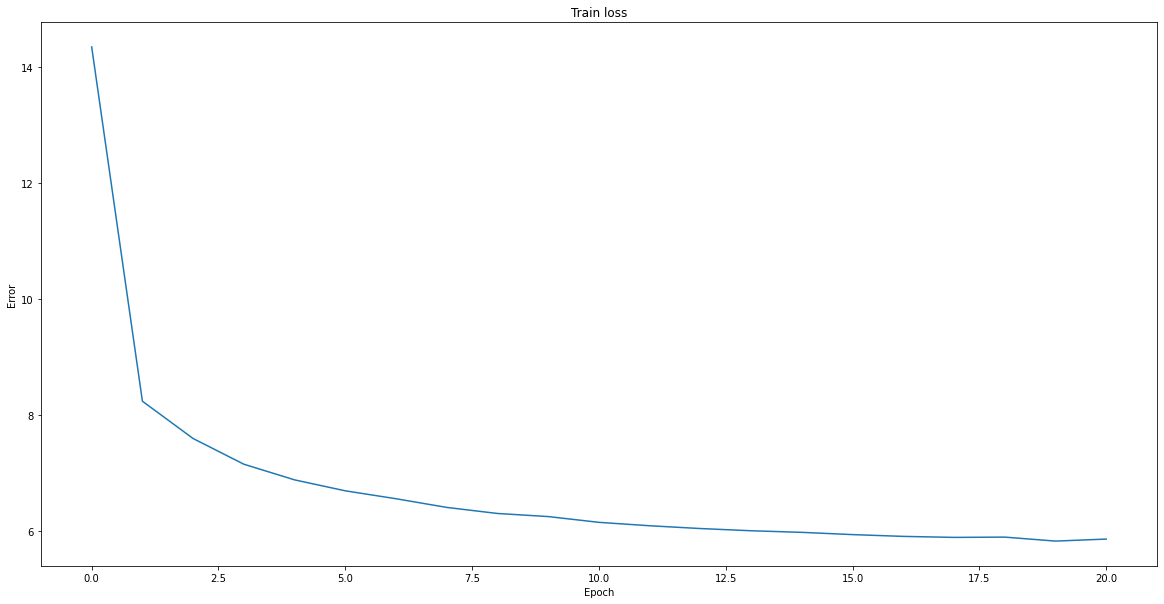

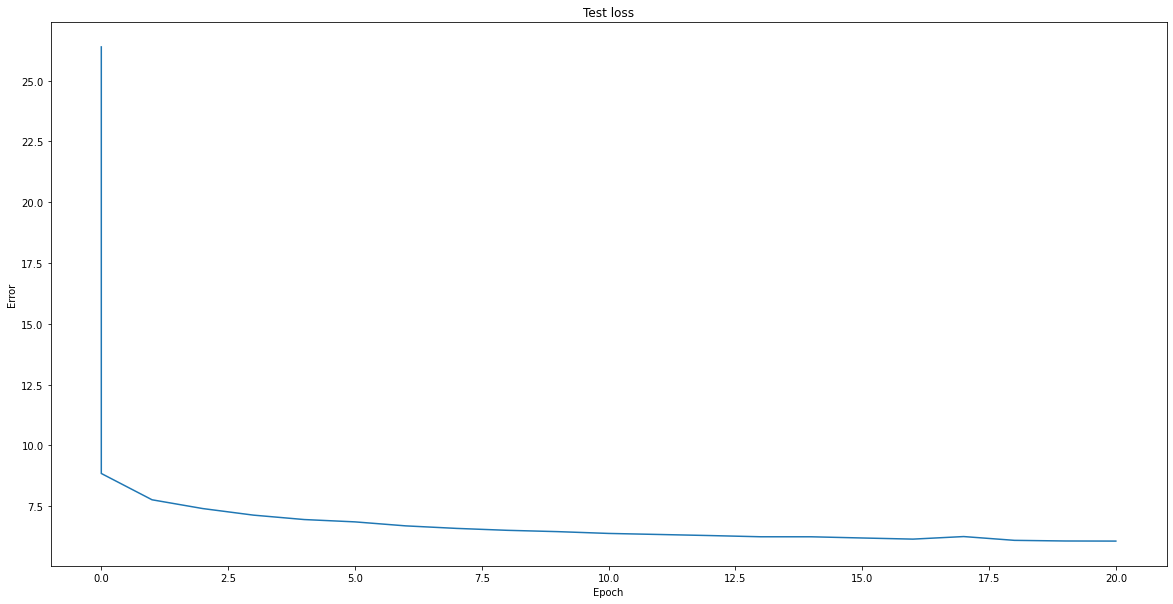

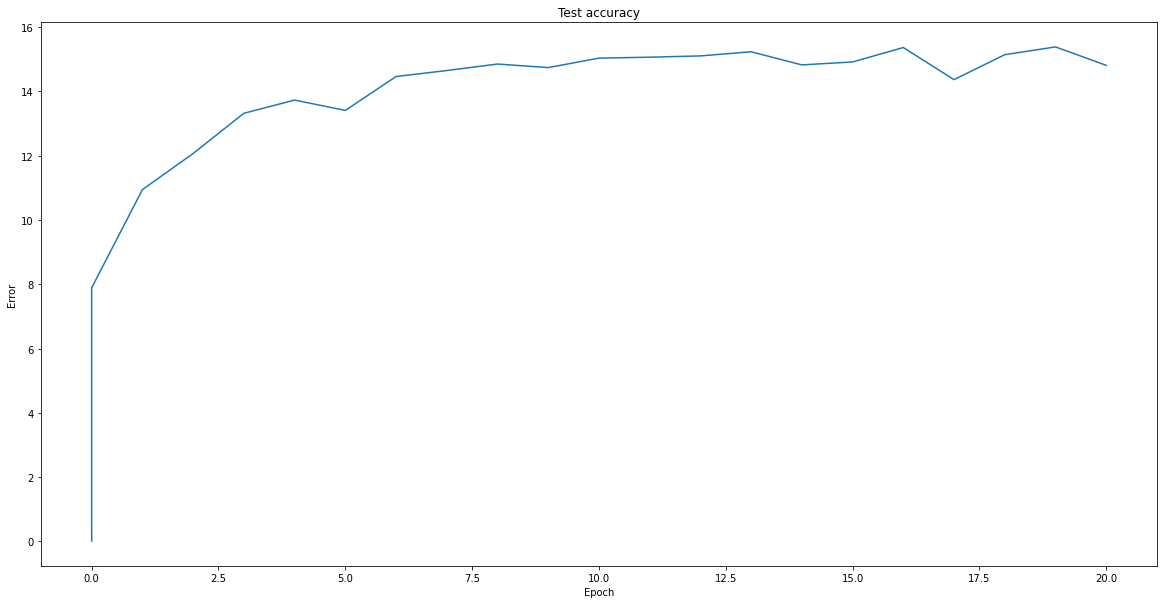

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log_words.pkl'


    data_train = HarryPotterWordDataset(DATA_PATH + 'harry_potter_words_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterWordDataset(DATA_PATH + 'harry_potter_words_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_words')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_words/%03d.pt' % epoch)
            seed_words = 'Harry Potter and Voldemort'.split()
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_words/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

Using device cuda
num workers: 2
Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	ashamed lawn words, be," Pensieve, deciding grinding chair. Senior conviction


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	gleefully. smirking. kitchen. gleefully. stretched, meetings, KNOW "Morning, inches disastrous


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	Phoenix internal use. Chamber. eleven. fear. persisted. expecto enough servant


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	illuminate bowing teapot impartial cage, visibly He'd entire choice Can't


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening t

  1%|          | 3/344 [00:00<00:31, 10.88it/s]

Train Epoch: 0 [0/88064 (0%)]	Loss: 25.476841


  4%|▍         | 13/344 [00:01<00:28, 11.72it/s]

Train Epoch: 0 [2560/88064 (3%)]	Loss: 17.238396


  7%|▋         | 23/344 [00:02<00:27, 11.77it/s]

Train Epoch: 0 [5120/88064 (6%)]	Loss: 13.835737


 10%|▉         | 33/344 [00:02<00:26, 11.95it/s]

Train Epoch: 0 [7680/88064 (9%)]	Loss: 11.457054


 12%|█▎        | 43/344 [00:03<00:25, 11.85it/s]

Train Epoch: 0 [10240/88064 (12%)]	Loss: 10.127295


 15%|█▌        | 53/344 [00:04<00:24, 11.82it/s]

Train Epoch: 0 [12800/88064 (15%)]	Loss: 9.732238


 18%|█▊        | 63/344 [00:05<00:23, 11.82it/s]

Train Epoch: 0 [15360/88064 (17%)]	Loss: 9.216020


 21%|██        | 73/344 [00:06<00:23, 11.69it/s]

Train Epoch: 0 [17920/88064 (20%)]	Loss: 8.688919


 24%|██▍       | 83/344 [00:07<00:22, 11.79it/s]

Train Epoch: 0 [20480/88064 (23%)]	Loss: 8.593714


 27%|██▋       | 93/344 [00:08<00:21, 11.84it/s]

Train Epoch: 0 [23040/88064 (26%)]	Loss: 8.265512


 30%|██▉       | 103/344 [00:08<00:20, 11.77it/s]

Train Epoch: 0 [25600/88064 (29%)]	Loss: 8.237946


 33%|███▎      | 113/344 [00:09<00:19, 11.76it/s]

Train Epoch: 0 [28160/88064 (32%)]	Loss: 7.951195


 36%|███▌      | 123/344 [00:10<00:18, 11.89it/s]

Train Epoch: 0 [30720/88064 (35%)]	Loss: 7.792348


 39%|███▊      | 133/344 [00:11<00:18, 11.68it/s]

Train Epoch: 0 [33280/88064 (38%)]	Loss: 7.730562


 42%|████▏     | 143/344 [00:12<00:17, 11.76it/s]

Train Epoch: 0 [35840/88064 (41%)]	Loss: 7.526289


 44%|████▍     | 153/344 [00:13<00:16, 11.92it/s]

Train Epoch: 0 [38400/88064 (44%)]	Loss: 7.663130


 47%|████▋     | 163/344 [00:14<00:15, 11.77it/s]

Train Epoch: 0 [40960/88064 (47%)]	Loss: 7.382197


 50%|█████     | 173/344 [00:15<00:14, 11.77it/s]

Train Epoch: 0 [43520/88064 (49%)]	Loss: 7.324213


 53%|█████▎    | 183/344 [00:15<00:13, 11.86it/s]

Train Epoch: 0 [46080/88064 (52%)]	Loss: 7.335472


 56%|█████▌    | 193/344 [00:16<00:12, 11.69it/s]

Train Epoch: 0 [48640/88064 (55%)]	Loss: 7.294372


 59%|█████▉    | 203/344 [00:17<00:11, 11.75it/s]

Train Epoch: 0 [51200/88064 (58%)]	Loss: 7.121402


 62%|██████▏   | 213/344 [00:18<00:11, 11.76it/s]

Train Epoch: 0 [53760/88064 (61%)]	Loss: 7.181719


 65%|██████▍   | 223/344 [00:19<00:10, 11.93it/s]

Train Epoch: 0 [56320/88064 (64%)]	Loss: 7.100713


 68%|██████▊   | 233/344 [00:20<00:09, 11.87it/s]

Train Epoch: 0 [58880/88064 (67%)]	Loss: 7.056346


 71%|███████   | 243/344 [00:21<00:08, 11.70it/s]

Train Epoch: 0 [61440/88064 (70%)]	Loss: 6.983904


 74%|███████▎  | 253/344 [00:22<00:07, 11.64it/s]

Train Epoch: 0 [64000/88064 (73%)]	Loss: 6.992214


 76%|███████▋  | 263/344 [00:22<00:06, 11.62it/s]

Train Epoch: 0 [66560/88064 (76%)]	Loss: 6.905344


 79%|███████▉  | 273/344 [00:23<00:06, 11.69it/s]

Train Epoch: 0 [69120/88064 (78%)]	Loss: 6.855549


 82%|████████▏ | 283/344 [00:24<00:05, 11.74it/s]

Train Epoch: 0 [71680/88064 (81%)]	Loss: 6.880843


 85%|████████▌ | 293/344 [00:25<00:04, 11.79it/s]

Train Epoch: 0 [74240/88064 (84%)]	Loss: 6.848067


 88%|████████▊ | 303/344 [00:26<00:03, 11.78it/s]

Train Epoch: 0 [76800/88064 (87%)]	Loss: 6.890371


 91%|█████████ | 313/344 [00:27<00:02, 11.76it/s]

Train Epoch: 0 [79360/88064 (90%)]	Loss: 6.879197


 94%|█████████▍| 323/344 [00:28<00:01, 11.70it/s]

Train Epoch: 0 [81920/88064 (93%)]	Loss: 6.849318


 97%|█████████▋| 333/344 [00:29<00:00, 11.76it/s]

Train Epoch: 0 [84480/88064 (96%)]	Loss: 6.746278


100%|█████████▉| 343/344 [00:29<00:00, 11.65it/s]

Train Epoch: 0 [87040/88064 (99%)]	Loss: 6.790910


100%|██████████| 344/344 [00:30<00:00, 11.44it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	and <UNKNOWN> and and the and the <UNKNOWN> and the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	<UNKNOWN> said <UNKNOWN> <UNKNOWN> Mrs. <UNKNOWN> <UNKNOWN> the <UNKNOWN> said


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to I I don't not <UNKNOWN> it I <UNKNOWN> tell


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	Pomfrey and Harry the stone and and the as the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	<UNKNOWN> said said Harry, <UNKNOWN> <UNKNOWN> said his Harry <UNKNOWN>


Input	his hand clenched painfully upon 

  0%|          | 1/344 [00:00<01:02,  5.52it/s]

Train Epoch: 1 [0/88064 (0%)]	Loss: 6.584684


  4%|▍         | 13/344 [00:01<00:28, 11.55it/s]

Train Epoch: 1 [2560/88064 (3%)]	Loss: 6.588536


  7%|▋         | 23/344 [00:02<00:27, 11.71it/s]

Train Epoch: 1 [5120/88064 (6%)]	Loss: 6.643091


 10%|▉         | 33/344 [00:02<00:26, 11.63it/s]

Train Epoch: 1 [7680/88064 (9%)]	Loss: 6.407699


 12%|█▎        | 43/344 [00:03<00:25, 11.76it/s]

Train Epoch: 1 [10240/88064 (12%)]	Loss: 6.425096


 15%|█▌        | 53/344 [00:04<00:24, 11.74it/s]

Train Epoch: 1 [12800/88064 (15%)]	Loss: 6.565425


 18%|█▊        | 63/344 [00:05<00:23, 11.79it/s]

Train Epoch: 1 [15360/88064 (17%)]	Loss: 6.522095


 21%|██        | 73/344 [00:06<00:23, 11.77it/s]

Train Epoch: 1 [17920/88064 (20%)]	Loss: 6.447147


 24%|██▍       | 83/344 [00:07<00:22, 11.67it/s]

Train Epoch: 1 [20480/88064 (23%)]	Loss: 6.541639


 27%|██▋       | 93/344 [00:08<00:21, 11.59it/s]

Train Epoch: 1 [23040/88064 (26%)]	Loss: 6.404890


 30%|██▉       | 103/344 [00:09<00:20, 11.51it/s]

Train Epoch: 1 [25600/88064 (29%)]	Loss: 6.525880


 33%|███▎      | 113/344 [00:09<00:19, 11.65it/s]

Train Epoch: 1 [28160/88064 (32%)]	Loss: 6.445139


 36%|███▌      | 123/344 [00:10<00:18, 11.77it/s]

Train Epoch: 1 [30720/88064 (35%)]	Loss: 6.294366


 39%|███▊      | 133/344 [00:11<00:18, 11.56it/s]

Train Epoch: 1 [33280/88064 (38%)]	Loss: 6.385215


 42%|████▏     | 143/344 [00:12<00:17, 11.64it/s]

Train Epoch: 1 [35840/88064 (41%)]	Loss: 6.262788


 44%|████▍     | 153/344 [00:13<00:16, 11.78it/s]

Train Epoch: 1 [38400/88064 (44%)]	Loss: 6.458149


 47%|████▋     | 163/344 [00:14<00:15, 11.67it/s]

Train Epoch: 1 [40960/88064 (47%)]	Loss: 6.238241


 50%|█████     | 173/344 [00:15<00:14, 11.74it/s]

Train Epoch: 1 [43520/88064 (49%)]	Loss: 6.227443


 53%|█████▎    | 183/344 [00:16<00:13, 11.71it/s]

Train Epoch: 1 [46080/88064 (52%)]	Loss: 6.331368


 56%|█████▌    | 193/344 [00:17<00:13, 11.61it/s]

Train Epoch: 1 [48640/88064 (55%)]	Loss: 6.330081


 59%|█████▉    | 203/344 [00:17<00:12, 11.72it/s]

Train Epoch: 1 [51200/88064 (58%)]	Loss: 6.246965


 62%|██████▏   | 213/344 [00:18<00:11, 11.64it/s]

Train Epoch: 1 [53760/88064 (61%)]	Loss: 6.326469


 65%|██████▍   | 223/344 [00:19<00:10, 11.52it/s]

Train Epoch: 1 [56320/88064 (64%)]	Loss: 6.297373


 68%|██████▊   | 233/344 [00:20<00:09, 11.67it/s]

Train Epoch: 1 [58880/88064 (67%)]	Loss: 6.237230


 71%|███████   | 243/344 [00:21<00:08, 11.73it/s]

Train Epoch: 1 [61440/88064 (70%)]	Loss: 6.263422


 74%|███████▎  | 253/344 [00:22<00:07, 11.61it/s]

Train Epoch: 1 [64000/88064 (73%)]	Loss: 6.216285


 76%|███████▋  | 263/344 [00:23<00:06, 11.60it/s]

Train Epoch: 1 [66560/88064 (76%)]	Loss: 6.211429


 79%|███████▉  | 273/344 [00:24<00:06, 11.52it/s]

Train Epoch: 1 [69120/88064 (78%)]	Loss: 6.193835


 82%|████████▏ | 283/344 [00:24<00:05, 11.55it/s]

Train Epoch: 1 [71680/88064 (81%)]	Loss: 6.203000


 85%|████████▌ | 293/344 [00:25<00:04, 11.70it/s]

Train Epoch: 1 [74240/88064 (84%)]	Loss: 6.228182


 88%|████████▊ | 303/344 [00:26<00:03, 11.72it/s]

Train Epoch: 1 [76800/88064 (87%)]	Loss: 6.283789


 91%|█████████ | 313/344 [00:27<00:02, 11.72it/s]

Train Epoch: 1 [79360/88064 (90%)]	Loss: 6.275918


 94%|█████████▍| 323/344 [00:28<00:01, 11.50it/s]

Train Epoch: 1 [81920/88064 (93%)]	Loss: 6.265002


 97%|█████████▋| 333/344 [00:29<00:00, 11.64it/s]

Train Epoch: 1 [84480/88064 (96%)]	Loss: 6.207410


100%|█████████▉| 343/344 [00:30<00:00, 11.76it/s]

Train Epoch: 1 [87040/88064 (99%)]	Loss: 6.268015


100%|██████████| 344/344 [00:30<00:00, 11.32it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> and <UNKNOWN> the and the <UNKNOWN> and the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	said <UNKNOWN> <UNKNOWN> <UNKNOWN> Harry quietly. <UNKNOWN> the <UNKNOWN> said


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to I I didn't not <UNKNOWN> I I <UNKNOWN> do


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	Pomfrey and the the <UNKNOWN> and and the to the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	<UNKNOWN> said said Harry <UNKNOWN> <UNKNOWN> said the Harry <UNKNOWN>


Input	his hand clenched pain

  0%|          | 1/344 [00:00<01:05,  5.27it/s]

Train Epoch: 2 [0/88064 (0%)]	Loss: 6.158742


  4%|▍         | 13/344 [00:01<00:28, 11.44it/s]

Train Epoch: 2 [2560/88064 (3%)]	Loss: 6.125535


  7%|▋         | 23/344 [00:02<00:27, 11.64it/s]

Train Epoch: 2 [5120/88064 (6%)]	Loss: 6.206560


 10%|▉         | 33/344 [00:02<00:26, 11.62it/s]

Train Epoch: 2 [7680/88064 (9%)]	Loss: 5.961886


 12%|█▎        | 43/344 [00:03<00:26, 11.48it/s]

Train Epoch: 2 [10240/88064 (12%)]	Loss: 5.987823


 15%|█▌        | 53/344 [00:04<00:24, 11.70it/s]

Train Epoch: 2 [12800/88064 (15%)]	Loss: 6.161139


 18%|█▊        | 63/344 [00:05<00:24, 11.66it/s]

Train Epoch: 2 [15360/88064 (17%)]	Loss: 6.144963


 21%|██        | 73/344 [00:06<00:23, 11.65it/s]

Train Epoch: 2 [17920/88064 (20%)]	Loss: 6.087132


 24%|██▍       | 83/344 [00:07<00:22, 11.64it/s]

Train Epoch: 2 [20480/88064 (23%)]	Loss: 6.181575


 27%|██▋       | 93/344 [00:08<00:21, 11.64it/s]

Train Epoch: 2 [23040/88064 (26%)]	Loss: 6.046865


 30%|██▉       | 103/344 [00:09<00:21, 11.47it/s]

Train Epoch: 2 [25600/88064 (29%)]	Loss: 6.166569


 33%|███▎      | 113/344 [00:10<00:19, 11.69it/s]

Train Epoch: 2 [28160/88064 (32%)]	Loss: 6.109249


 36%|███▌      | 123/344 [00:10<00:18, 11.71it/s]

Train Epoch: 2 [30720/88064 (35%)]	Loss: 5.978442


 39%|███▊      | 133/344 [00:11<00:18, 11.67it/s]

Train Epoch: 2 [33280/88064 (38%)]	Loss: 6.067894


 42%|████▏     | 143/344 [00:12<00:17, 11.58it/s]

Train Epoch: 2 [35840/88064 (41%)]	Loss: 5.969333


 44%|████▍     | 153/344 [00:13<00:16, 11.78it/s]

Train Epoch: 2 [38400/88064 (44%)]	Loss: 6.145967


 47%|████▋     | 163/344 [00:14<00:15, 11.70it/s]

Train Epoch: 2 [40960/88064 (47%)]	Loss: 5.969526


 50%|█████     | 173/344 [00:15<00:14, 11.61it/s]

Train Epoch: 2 [43520/88064 (49%)]	Loss: 5.952421


 53%|█████▎    | 183/344 [00:16<00:13, 11.74it/s]

Train Epoch: 2 [46080/88064 (52%)]	Loss: 6.044950


 56%|█████▌    | 193/344 [00:17<00:13, 11.60it/s]

Train Epoch: 2 [48640/88064 (55%)]	Loss: 6.056794


 59%|█████▉    | 203/344 [00:17<00:12, 11.71it/s]

Train Epoch: 2 [51200/88064 (58%)]	Loss: 5.985997


 62%|██████▏   | 213/344 [00:18<00:11, 11.76it/s]

Train Epoch: 2 [53760/88064 (61%)]	Loss: 6.064118


 65%|██████▍   | 223/344 [00:19<00:10, 11.71it/s]

Train Epoch: 2 [56320/88064 (64%)]	Loss: 6.056682


 68%|██████▊   | 233/344 [00:20<00:09, 11.63it/s]

Train Epoch: 2 [58880/88064 (67%)]	Loss: 5.997109


 71%|███████   | 243/344 [00:21<00:08, 11.67it/s]

Train Epoch: 2 [61440/88064 (70%)]	Loss: 6.044506


 74%|███████▎  | 253/344 [00:22<00:07, 11.70it/s]

Train Epoch: 2 [64000/88064 (73%)]	Loss: 5.972503


 76%|███████▋  | 263/344 [00:23<00:06, 11.65it/s]

Train Epoch: 2 [66560/88064 (76%)]	Loss: 5.984180


 79%|███████▉  | 273/344 [00:24<00:06, 11.64it/s]

Train Epoch: 2 [69120/88064 (78%)]	Loss: 5.988004


 82%|████████▏ | 283/344 [00:25<00:05, 11.75it/s]

Train Epoch: 2 [71680/88064 (81%)]	Loss: 6.000855


 85%|████████▌ | 293/344 [00:25<00:04, 11.71it/s]

Train Epoch: 2 [74240/88064 (84%)]	Loss: 6.034350


 88%|████████▊ | 303/344 [00:26<00:03, 11.66it/s]

Train Epoch: 2 [76800/88064 (87%)]	Loss: 6.089163


 91%|█████████ | 313/344 [00:27<00:02, 11.73it/s]

Train Epoch: 2 [79360/88064 (90%)]	Loss: 6.061357


 94%|█████████▍| 323/344 [00:28<00:01, 11.69it/s]

Train Epoch: 2 [81920/88064 (93%)]	Loss: 6.071638


 97%|█████████▋| 333/344 [00:29<00:00, 11.68it/s]

Train Epoch: 2 [84480/88064 (96%)]	Loss: 6.030423


100%|█████████▉| 343/344 [00:30<00:00, 11.58it/s]

Train Epoch: 2 [87040/88064 (99%)]	Loss: 6.071159


100%|██████████| 344/344 [00:30<00:00, 11.29it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> to <UNKNOWN> the and the <UNKNOWN> and the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	<UNKNOWN> you <UNKNOWN> <UNKNOWN> Harry, quietly. <UNKNOWN> she <UNKNOWN> said


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to I I didn't you think I I can do


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	Pomfrey and Harry the <UNKNOWN> <UNKNOWN> and the as the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	to said said Harry looking <UNKNOWN> said do said to


Input	his hand clenched painfully upon Harry's sh

  1%|          | 3/344 [00:00<00:33, 10.20it/s]

Train Epoch: 3 [0/88064 (0%)]	Loss: 6.003103


  4%|▍         | 13/344 [00:01<00:28, 11.57it/s]

Train Epoch: 3 [2560/88064 (3%)]	Loss: 5.939438


  7%|▋         | 23/344 [00:02<00:27, 11.52it/s]

Train Epoch: 3 [5120/88064 (6%)]	Loss: 6.036121


 10%|▉         | 33/344 [00:02<00:26, 11.69it/s]

Train Epoch: 3 [7680/88064 (9%)]	Loss: 5.814139


 12%|█▎        | 43/344 [00:03<00:25, 11.66it/s]

Train Epoch: 3 [10240/88064 (12%)]	Loss: 5.828504


 15%|█▌        | 53/344 [00:04<00:25, 11.63it/s]

Train Epoch: 3 [12800/88064 (15%)]	Loss: 6.007529


 18%|█▊        | 63/344 [00:05<00:24, 11.65it/s]

Train Epoch: 3 [15360/88064 (17%)]	Loss: 6.006912


 21%|██        | 73/344 [00:06<00:22, 11.83it/s]

Train Epoch: 3 [17920/88064 (20%)]	Loss: 5.923976


 24%|██▍       | 83/344 [00:07<00:22, 11.69it/s]

Train Epoch: 3 [20480/88064 (23%)]	Loss: 6.045861


 27%|██▋       | 93/344 [00:08<00:21, 11.64it/s]

Train Epoch: 3 [23040/88064 (26%)]	Loss: 5.905744


 30%|██▉       | 103/344 [00:09<00:21, 11.43it/s]

Train Epoch: 3 [25600/88064 (29%)]	Loss: 6.023945


 33%|███▎      | 113/344 [00:10<00:19, 11.61it/s]

Train Epoch: 3 [28160/88064 (32%)]	Loss: 5.962855


 36%|███▌      | 123/344 [00:10<00:19, 11.57it/s]

Train Epoch: 3 [30720/88064 (35%)]	Loss: 5.846317


 39%|███▊      | 133/344 [00:11<00:18, 11.55it/s]

Train Epoch: 3 [33280/88064 (38%)]	Loss: 5.935338


 42%|████▏     | 143/344 [00:12<00:17, 11.53it/s]

Train Epoch: 3 [35840/88064 (41%)]	Loss: 5.856950


 44%|████▍     | 153/344 [00:13<00:16, 11.63it/s]

Train Epoch: 3 [38400/88064 (44%)]	Loss: 6.012992


 47%|████▋     | 163/344 [00:14<00:15, 11.35it/s]

Train Epoch: 3 [40960/88064 (47%)]	Loss: 5.865532


 50%|█████     | 173/344 [00:15<00:14, 11.50it/s]

Train Epoch: 3 [43520/88064 (49%)]	Loss: 5.831985


 53%|█████▎    | 183/344 [00:16<00:13, 11.66it/s]

Train Epoch: 3 [46080/88064 (52%)]	Loss: 5.924357


 56%|█████▌    | 193/344 [00:17<00:12, 11.66it/s]

Train Epoch: 3 [48640/88064 (55%)]	Loss: 5.942095


 59%|█████▉    | 203/344 [00:17<00:12, 11.71it/s]

Train Epoch: 3 [51200/88064 (58%)]	Loss: 5.886371


 62%|██████▏   | 213/344 [00:18<00:11, 11.64it/s]

Train Epoch: 3 [53760/88064 (61%)]	Loss: 5.939593


 65%|██████▍   | 223/344 [00:19<00:10, 11.62it/s]

Train Epoch: 3 [56320/88064 (64%)]	Loss: 5.945842


 68%|██████▊   | 233/344 [00:20<00:09, 11.64it/s]

Train Epoch: 3 [58880/88064 (67%)]	Loss: 5.885998


 71%|███████   | 243/344 [00:21<00:08, 11.58it/s]

Train Epoch: 3 [61440/88064 (70%)]	Loss: 5.948143


 74%|███████▎  | 253/344 [00:22<00:07, 11.51it/s]

Train Epoch: 3 [64000/88064 (73%)]	Loss: 5.877483


 76%|███████▋  | 263/344 [00:23<00:06, 11.65it/s]

Train Epoch: 3 [66560/88064 (76%)]	Loss: 5.879981


 79%|███████▉  | 273/344 [00:24<00:06, 11.68it/s]

Train Epoch: 3 [69120/88064 (78%)]	Loss: 5.885780


 82%|████████▏ | 283/344 [00:25<00:05, 11.64it/s]

Train Epoch: 3 [71680/88064 (81%)]	Loss: 5.915438


 85%|████████▌ | 293/344 [00:25<00:04, 11.50it/s]

Train Epoch: 3 [74240/88064 (84%)]	Loss: 5.949583


 88%|████████▊ | 303/344 [00:26<00:03, 11.37it/s]

Train Epoch: 3 [76800/88064 (87%)]	Loss: 5.999262


 91%|█████████ | 313/344 [00:27<00:02, 11.63it/s]

Train Epoch: 3 [79360/88064 (90%)]	Loss: 5.969276


 94%|█████████▍| 323/344 [00:28<00:01, 11.67it/s]

Train Epoch: 3 [81920/88064 (93%)]	Loss: 5.987298


 97%|█████████▋| 333/344 [00:29<00:00, 11.40it/s]

Train Epoch: 3 [84480/88064 (96%)]	Loss: 5.942454


100%|█████████▉| 343/344 [00:30<00:00, 11.64it/s]

Train Epoch: 3 [87040/88064 (99%)]	Loss: 5.999614


100%|██████████| 344/344 [00:30<00:00, 11.27it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	to <UNKNOWN> to <UNKNOWN> the and the <UNKNOWN> and the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	<UNKNOWN> you <UNKNOWN> <UNKNOWN> Ron, in <UNKNOWN> he <UNKNOWN> of


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to I I think you <UNKNOWN> I I think do


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> and the <UNKNOWN> <UNKNOWN> and the and the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	to said said Harry looking <UNKNOWN> to get and <UNKNOWN>


Input	his hand clenched painfully upon Harry's sho

  0%|          | 1/344 [00:00<01:03,  5.41it/s]

Train Epoch: 4 [0/88064 (0%)]	Loss: 5.922396


  4%|▍         | 13/344 [00:01<00:28, 11.55it/s]

Train Epoch: 4 [2560/88064 (3%)]	Loss: 5.845680


  7%|▋         | 23/344 [00:02<00:27, 11.70it/s]

Train Epoch: 4 [5120/88064 (6%)]	Loss: 5.951390


 10%|▉         | 33/344 [00:02<00:26, 11.54it/s]

Train Epoch: 4 [7680/88064 (9%)]	Loss: 5.761405


 12%|█▎        | 43/344 [00:03<00:25, 11.60it/s]

Train Epoch: 4 [10240/88064 (12%)]	Loss: 5.750383


 15%|█▌        | 53/344 [00:04<00:24, 11.69it/s]

Train Epoch: 4 [12800/88064 (15%)]	Loss: 5.945080


 18%|█▊        | 63/344 [00:05<00:24, 11.34it/s]

Train Epoch: 4 [15360/88064 (17%)]	Loss: 5.904025


 21%|██        | 73/344 [00:06<00:23, 11.51it/s]

Train Epoch: 4 [17920/88064 (20%)]	Loss: 5.857934


 24%|██▍       | 83/344 [00:07<00:22, 11.49it/s]

Train Epoch: 4 [20480/88064 (23%)]	Loss: 5.982644


 27%|██▋       | 93/344 [00:08<00:21, 11.62it/s]

Train Epoch: 4 [23040/88064 (26%)]	Loss: 5.830912


 30%|██▉       | 103/344 [00:09<00:20, 11.72it/s]

Train Epoch: 4 [25600/88064 (29%)]	Loss: 5.953776


 33%|███▎      | 113/344 [00:10<00:19, 11.68it/s]

Train Epoch: 4 [28160/88064 (32%)]	Loss: 5.901523


 36%|███▌      | 123/344 [00:10<00:19, 11.61it/s]

Train Epoch: 4 [30720/88064 (35%)]	Loss: 5.784325


 39%|███▊      | 133/344 [00:11<00:18, 11.62it/s]

Train Epoch: 4 [33280/88064 (38%)]	Loss: 5.865975


 42%|████▏     | 143/344 [00:12<00:17, 11.31it/s]

Train Epoch: 4 [35840/88064 (41%)]	Loss: 5.801173


 44%|████▍     | 153/344 [00:13<00:16, 11.66it/s]

Train Epoch: 4 [38400/88064 (44%)]	Loss: 5.951360


 47%|████▋     | 163/344 [00:14<00:15, 11.55it/s]

Train Epoch: 4 [40960/88064 (47%)]	Loss: 5.814633


 50%|█████     | 173/344 [00:15<00:14, 11.48it/s]

Train Epoch: 4 [43520/88064 (49%)]	Loss: 5.779904


 53%|█████▎    | 183/344 [00:16<00:13, 11.68it/s]

Train Epoch: 4 [46080/88064 (52%)]	Loss: 5.857872


 56%|█████▌    | 193/344 [00:17<00:12, 11.65it/s]

Train Epoch: 4 [48640/88064 (55%)]	Loss: 5.890622


 59%|█████▉    | 203/344 [00:18<00:12, 11.73it/s]

Train Epoch: 4 [51200/88064 (58%)]	Loss: 5.846292


 62%|██████▏   | 213/344 [00:18<00:11, 11.59it/s]

Train Epoch: 4 [53760/88064 (61%)]	Loss: 5.867443


 65%|██████▍   | 223/344 [00:19<00:10, 11.58it/s]

Train Epoch: 4 [56320/88064 (64%)]	Loss: 5.886136


 68%|██████▊   | 233/344 [00:20<00:09, 11.53it/s]

Train Epoch: 4 [58880/88064 (67%)]	Loss: 5.829122


 71%|███████   | 243/344 [00:21<00:08, 11.68it/s]

Train Epoch: 4 [61440/88064 (70%)]	Loss: 5.901026


 74%|███████▎  | 253/344 [00:22<00:07, 11.67it/s]

Train Epoch: 4 [64000/88064 (73%)]	Loss: 5.842747


 76%|███████▋  | 263/344 [00:23<00:07, 11.52it/s]

Train Epoch: 4 [66560/88064 (76%)]	Loss: 5.828829


 79%|███████▉  | 273/344 [00:24<00:06, 11.53it/s]

Train Epoch: 4 [69120/88064 (78%)]	Loss: 5.836755


 82%|████████▏ | 283/344 [00:25<00:05, 11.66it/s]

Train Epoch: 4 [71680/88064 (81%)]	Loss: 5.867501


 85%|████████▌ | 293/344 [00:25<00:04, 11.75it/s]

Train Epoch: 4 [74240/88064 (84%)]	Loss: 5.909490


 88%|████████▊ | 303/344 [00:26<00:03, 11.69it/s]

Train Epoch: 4 [76800/88064 (87%)]	Loss: 5.952508


 91%|█████████ | 313/344 [00:27<00:02, 11.69it/s]

Train Epoch: 4 [79360/88064 (90%)]	Loss: 5.918689


 94%|█████████▍| 323/344 [00:28<00:01, 11.70it/s]

Train Epoch: 4 [81920/88064 (93%)]	Loss: 5.953356


 97%|█████████▋| 333/344 [00:29<00:00, 11.61it/s]

Train Epoch: 4 [84480/88064 (96%)]	Loss: 5.903445


100%|█████████▉| 343/344 [00:30<00:00, 11.67it/s]

Train Epoch: 4 [87040/88064 (99%)]	Loss: 5.961957


100%|██████████| 344/344 [00:30<00:00, 11.28it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	to <UNKNOWN> to and the and the <UNKNOWN> of the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	said <UNKNOWN> <UNKNOWN> <UNKNOWN> Ron, in <UNKNOWN> he <UNKNOWN> of


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to I I think you <UNKNOWN> of I think <UNKNOWN>


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> and the <UNKNOWN> <UNKNOWN> and the and the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	to said said Ron, looking <UNKNOWN> to his and <UNKNOWN>


Input	his hand clenched painfully upon Harry's sh

  0%|          | 1/344 [00:00<01:03,  5.38it/s]

Train Epoch: 5 [0/88064 (0%)]	Loss: 5.879380


  4%|▍         | 13/344 [00:01<00:28, 11.56it/s]

Train Epoch: 5 [2560/88064 (3%)]	Loss: 5.804831


  7%|▋         | 23/344 [00:02<00:27, 11.66it/s]

Train Epoch: 5 [5120/88064 (6%)]	Loss: 5.910550


 10%|▉         | 33/344 [00:02<00:27, 11.41it/s]

Train Epoch: 5 [7680/88064 (9%)]	Loss: 5.744049


 12%|█▎        | 43/344 [00:03<00:25, 11.63it/s]

Train Epoch: 5 [10240/88064 (12%)]	Loss: 5.703577


 15%|█▌        | 53/344 [00:04<00:25, 11.61it/s]

Train Epoch: 5 [12800/88064 (15%)]	Loss: 5.904402


 18%|█▊        | 63/344 [00:05<00:24, 11.67it/s]

Train Epoch: 5 [15360/88064 (17%)]	Loss: 5.856895


 21%|██        | 73/344 [00:06<00:23, 11.63it/s]

Train Epoch: 5 [17920/88064 (20%)]	Loss: 5.806668


 24%|██▍       | 83/344 [00:07<00:22, 11.50it/s]

Train Epoch: 5 [20480/88064 (23%)]	Loss: 5.942642


 27%|██▋       | 93/344 [00:08<00:21, 11.49it/s]

Train Epoch: 5 [23040/88064 (26%)]	Loss: 5.789863


 30%|██▉       | 103/344 [00:09<00:20, 11.66it/s]

Train Epoch: 5 [25600/88064 (29%)]	Loss: 5.917056


 33%|███▎      | 113/344 [00:10<00:19, 11.63it/s]

Train Epoch: 5 [28160/88064 (32%)]	Loss: 5.866421


 36%|███▌      | 123/344 [00:10<00:18, 11.63it/s]

Train Epoch: 5 [30720/88064 (35%)]	Loss: 5.750504


 39%|███▊      | 133/344 [00:11<00:18, 11.48it/s]

Train Epoch: 5 [33280/88064 (38%)]	Loss: 5.822998


 42%|████▏     | 143/344 [00:12<00:17, 11.68it/s]

Train Epoch: 5 [35840/88064 (41%)]	Loss: 5.771128


 44%|████▍     | 153/344 [00:13<00:16, 11.56it/s]

Train Epoch: 5 [38400/88064 (44%)]	Loss: 5.918834


 47%|████▋     | 163/344 [00:14<00:15, 11.53it/s]

Train Epoch: 5 [40960/88064 (47%)]	Loss: 5.787210


 50%|█████     | 173/344 [00:15<00:14, 11.68it/s]

Train Epoch: 5 [43520/88064 (49%)]	Loss: 5.749529


 53%|█████▎    | 183/344 [00:16<00:13, 11.69it/s]

Train Epoch: 5 [46080/88064 (52%)]	Loss: 5.819021


 56%|█████▌    | 193/344 [00:17<00:12, 11.65it/s]

Train Epoch: 5 [48640/88064 (55%)]	Loss: 5.861934


 59%|█████▉    | 203/344 [00:18<00:12, 11.39it/s]

Train Epoch: 5 [51200/88064 (58%)]	Loss: 5.812348


 62%|██████▏   | 213/344 [00:18<00:11, 11.74it/s]

Train Epoch: 5 [53760/88064 (61%)]	Loss: 5.826720


 65%|██████▍   | 223/344 [00:19<00:10, 11.66it/s]

Train Epoch: 5 [56320/88064 (64%)]	Loss: 5.841813


 68%|██████▊   | 233/344 [00:20<00:09, 11.52it/s]

Train Epoch: 5 [58880/88064 (67%)]	Loss: 5.796735


 71%|███████   | 243/344 [00:21<00:08, 11.64it/s]

Train Epoch: 5 [61440/88064 (70%)]	Loss: 5.869834


 74%|███████▎  | 253/344 [00:22<00:07, 11.44it/s]

Train Epoch: 5 [64000/88064 (73%)]	Loss: 5.815743


 76%|███████▋  | 263/344 [00:23<00:06, 11.59it/s]

Train Epoch: 5 [66560/88064 (76%)]	Loss: 5.815106


 79%|███████▉  | 273/344 [00:24<00:06, 11.72it/s]

Train Epoch: 5 [69120/88064 (78%)]	Loss: 5.815652


 82%|████████▏ | 283/344 [00:25<00:05, 11.57it/s]

Train Epoch: 5 [71680/88064 (81%)]	Loss: 5.839257


 85%|████████▌ | 293/344 [00:25<00:04, 11.57it/s]

Train Epoch: 5 [74240/88064 (84%)]	Loss: 5.888939


 88%|████████▊ | 303/344 [00:26<00:03, 11.68it/s]

Train Epoch: 5 [76800/88064 (87%)]	Loss: 5.917848


 91%|█████████ | 313/344 [00:27<00:02, 11.57it/s]

Train Epoch: 5 [79360/88064 (90%)]	Loss: 5.896252


 94%|█████████▍| 323/344 [00:28<00:01, 11.65it/s]

Train Epoch: 5 [81920/88064 (93%)]	Loss: 5.923907


 97%|█████████▋| 333/344 [00:29<00:00, 11.64it/s]

Train Epoch: 5 [84480/88064 (96%)]	Loss: 5.874637


100%|█████████▉| 343/344 [00:30<00:00, 11.67it/s]

Train Epoch: 5 [87040/88064 (99%)]	Loss: 5.940991


100%|██████████| 344/344 [00:30<00:00, 11.27it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	to <UNKNOWN> to and the and the <UNKNOWN> of the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	said said <UNKNOWN> said Ron, <UNKNOWN> <UNKNOWN> he <UNKNOWN> of


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to I I think you <UNKNOWN> of I think <UNKNOWN>


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> and the and the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	to said said Ron, looking <UNKNOWN> to the <UNKNOWN> <UNKNOWN>


Input	his hand clenched painfully upon H

  0%|          | 1/344 [00:00<01:03,  5.41it/s]

Train Epoch: 6 [0/88064 (0%)]	Loss: 5.852212


  4%|▍         | 13/344 [00:01<00:28, 11.46it/s]

Train Epoch: 6 [2560/88064 (3%)]	Loss: 5.777879


  7%|▋         | 23/344 [00:02<00:27, 11.47it/s]

Train Epoch: 6 [5120/88064 (6%)]	Loss: 5.888353


 10%|▉         | 33/344 [00:02<00:26, 11.66it/s]

Train Epoch: 6 [7680/88064 (9%)]	Loss: 5.724358


 12%|█▎        | 43/344 [00:03<00:26, 11.50it/s]

Train Epoch: 6 [10240/88064 (12%)]	Loss: 5.679500


 15%|█▌        | 53/344 [00:04<00:24, 11.66it/s]

Train Epoch: 6 [12800/88064 (15%)]	Loss: 5.870788


 18%|█▊        | 63/344 [00:05<00:24, 11.68it/s]

Train Epoch: 6 [15360/88064 (17%)]	Loss: 5.830227


 21%|██        | 73/344 [00:06<00:23, 11.63it/s]

Train Epoch: 6 [17920/88064 (20%)]	Loss: 5.778045


 24%|██▍       | 83/344 [00:07<00:22, 11.70it/s]

Train Epoch: 6 [20480/88064 (23%)]	Loss: 5.915377


 27%|██▋       | 93/344 [00:08<00:21, 11.60it/s]

Train Epoch: 6 [23040/88064 (26%)]	Loss: 5.766065


 30%|██▉       | 103/344 [00:09<00:20, 11.65it/s]

Train Epoch: 6 [25600/88064 (29%)]	Loss: 5.890808


 33%|███▎      | 113/344 [00:10<00:19, 11.57it/s]

Train Epoch: 6 [28160/88064 (32%)]	Loss: 5.841716


 36%|███▌      | 123/344 [00:10<00:18, 11.72it/s]

Train Epoch: 6 [30720/88064 (35%)]	Loss: 5.720124


 39%|███▊      | 133/344 [00:11<00:18, 11.69it/s]

Train Epoch: 6 [33280/88064 (38%)]	Loss: 5.793691


 42%|████▏     | 143/344 [00:12<00:17, 11.78it/s]

Train Epoch: 6 [35840/88064 (41%)]	Loss: 5.746866


 44%|████▍     | 153/344 [00:13<00:16, 11.77it/s]

Train Epoch: 6 [38400/88064 (44%)]	Loss: 5.898464


 47%|████▋     | 163/344 [00:14<00:15, 11.54it/s]

Train Epoch: 6 [40960/88064 (47%)]	Loss: 5.764201


 50%|█████     | 173/344 [00:15<00:14, 11.48it/s]

Train Epoch: 6 [43520/88064 (49%)]	Loss: 5.717918


 53%|█████▎    | 183/344 [00:16<00:14, 11.32it/s]

Train Epoch: 6 [46080/88064 (52%)]	Loss: 5.792663


 56%|█████▌    | 193/344 [00:17<00:13, 11.31it/s]

Train Epoch: 6 [48640/88064 (55%)]	Loss: 5.841743


 59%|█████▉    | 203/344 [00:18<00:12, 11.71it/s]

Train Epoch: 6 [51200/88064 (58%)]	Loss: 5.785926


 62%|██████▏   | 213/344 [00:18<00:11, 11.78it/s]

Train Epoch: 6 [53760/88064 (61%)]	Loss: 5.800008


 65%|██████▍   | 223/344 [00:19<00:10, 11.72it/s]

Train Epoch: 6 [56320/88064 (64%)]	Loss: 5.813244


 68%|██████▊   | 233/344 [00:20<00:09, 11.45it/s]

Train Epoch: 6 [58880/88064 (67%)]	Loss: 5.773963


 71%|███████   | 243/344 [00:21<00:08, 11.70it/s]

Train Epoch: 6 [61440/88064 (70%)]	Loss: 5.844437


 74%|███████▎  | 253/344 [00:22<00:07, 11.66it/s]

Train Epoch: 6 [64000/88064 (73%)]	Loss: 5.794473


 76%|███████▋  | 263/344 [00:23<00:06, 11.71it/s]

Train Epoch: 6 [66560/88064 (76%)]	Loss: 5.779344


 79%|███████▉  | 273/344 [00:24<00:06, 11.57it/s]

Train Epoch: 6 [69120/88064 (78%)]	Loss: 5.795033


 82%|████████▏ | 283/344 [00:25<00:05, 11.69it/s]

Train Epoch: 6 [71680/88064 (81%)]	Loss: 5.816562


 85%|████████▌ | 293/344 [00:25<00:04, 11.67it/s]

Train Epoch: 6 [74240/88064 (84%)]	Loss: 5.867167


 88%|████████▊ | 303/344 [00:26<00:03, 11.64it/s]

Train Epoch: 6 [76800/88064 (87%)]	Loss: 5.887718


 91%|█████████ | 313/344 [00:27<00:02, 11.48it/s]

Train Epoch: 6 [79360/88064 (90%)]	Loss: 5.870320


 94%|█████████▍| 323/344 [00:28<00:01, 11.43it/s]

Train Epoch: 6 [81920/88064 (93%)]	Loss: 5.901628


 97%|█████████▋| 333/344 [00:29<00:00, 11.46it/s]

Train Epoch: 6 [84480/88064 (96%)]	Loss: 5.852043


100%|█████████▉| 343/344 [00:30<00:00, 11.71it/s]

Train Epoch: 6 [87040/88064 (99%)]	Loss: 5.921805


100%|██████████| 344/344 [00:30<00:00, 11.27it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	to <UNKNOWN> and and the and the <UNKNOWN> of the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	said <UNKNOWN> <UNKNOWN> <UNKNOWN> Ron, <UNKNOWN> <UNKNOWN> he <UNKNOWN> of


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to I I was you <UNKNOWN> of I was <UNKNOWN>


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> the <UNKNOWN> and and the and the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	to <UNKNOWN> said Ron, looking <UNKNOWN> to his <UNKNOWN> <UNKNOWN>


Input	his hand clenched painfully 

  0%|          | 1/344 [00:00<01:05,  5.27it/s]

Train Epoch: 7 [0/88064 (0%)]	Loss: 5.836084


  4%|▍         | 13/344 [00:01<00:28, 11.47it/s]

Train Epoch: 7 [2560/88064 (3%)]	Loss: 5.756808


  7%|▋         | 23/344 [00:02<00:27, 11.70it/s]

Train Epoch: 7 [5120/88064 (6%)]	Loss: 5.868432


 10%|▉         | 33/344 [00:02<00:26, 11.74it/s]

Train Epoch: 7 [7680/88064 (9%)]	Loss: 5.705923


 12%|█▎        | 43/344 [00:03<00:25, 11.71it/s]

Train Epoch: 7 [10240/88064 (12%)]	Loss: 5.662646


 15%|█▌        | 53/344 [00:04<00:25, 11.61it/s]

Train Epoch: 7 [12800/88064 (15%)]	Loss: 5.846275


 18%|█▊        | 63/344 [00:05<00:23, 11.74it/s]

Train Epoch: 7 [15360/88064 (17%)]	Loss: 5.811630


 21%|██        | 73/344 [00:06<00:23, 11.67it/s]

Train Epoch: 7 [17920/88064 (20%)]	Loss: 5.762031


 24%|██▍       | 83/344 [00:07<00:22, 11.68it/s]

Train Epoch: 7 [20480/88064 (23%)]	Loss: 5.899361


 27%|██▋       | 93/344 [00:08<00:21, 11.72it/s]

Train Epoch: 7 [23040/88064 (26%)]	Loss: 5.747868


 30%|██▉       | 103/344 [00:09<00:20, 11.71it/s]

Train Epoch: 7 [25600/88064 (29%)]	Loss: 5.872595


 33%|███▎      | 113/344 [00:10<00:19, 11.66it/s]

Train Epoch: 7 [28160/88064 (32%)]	Loss: 5.817422


 36%|███▌      | 123/344 [00:10<00:19, 11.59it/s]

Train Epoch: 7 [30720/88064 (35%)]	Loss: 5.698641


 39%|███▊      | 133/344 [00:11<00:17, 11.73it/s]

Train Epoch: 7 [33280/88064 (38%)]	Loss: 5.776567


 42%|████▏     | 143/344 [00:12<00:17, 11.75it/s]

Train Epoch: 7 [35840/88064 (41%)]	Loss: 5.729423


 44%|████▍     | 153/344 [00:13<00:16, 11.40it/s]

Train Epoch: 7 [38400/88064 (44%)]	Loss: 5.884639


 47%|████▋     | 163/344 [00:14<00:15, 11.59it/s]

Train Epoch: 7 [40960/88064 (47%)]	Loss: 5.746233


 50%|█████     | 173/344 [00:15<00:14, 11.71it/s]

Train Epoch: 7 [43520/88064 (49%)]	Loss: 5.699152


 53%|█████▎    | 183/344 [00:16<00:13, 11.63it/s]

Train Epoch: 7 [46080/88064 (52%)]	Loss: 5.773892


 56%|█████▌    | 193/344 [00:17<00:13, 11.58it/s]

Train Epoch: 7 [48640/88064 (55%)]	Loss: 5.821095


 59%|█████▉    | 203/344 [00:17<00:12, 11.62it/s]

Train Epoch: 7 [51200/88064 (58%)]	Loss: 5.769849


 62%|██████▏   | 213/344 [00:18<00:11, 11.57it/s]

Train Epoch: 7 [53760/88064 (61%)]	Loss: 5.780063


 65%|██████▍   | 223/344 [00:19<00:10, 11.48it/s]

Train Epoch: 7 [56320/88064 (64%)]	Loss: 5.793963


 68%|██████▊   | 233/344 [00:20<00:09, 11.55it/s]

Train Epoch: 7 [58880/88064 (67%)]	Loss: 5.757905


 71%|███████   | 243/344 [00:21<00:08, 11.52it/s]

Train Epoch: 7 [61440/88064 (70%)]	Loss: 5.831286


 74%|███████▎  | 253/344 [00:22<00:07, 11.44it/s]

Train Epoch: 7 [64000/88064 (73%)]	Loss: 5.777954


 76%|███████▋  | 263/344 [00:23<00:06, 11.62it/s]

Train Epoch: 7 [66560/88064 (76%)]	Loss: 5.758655


 79%|███████▉  | 273/344 [00:24<00:06, 11.58it/s]

Train Epoch: 7 [69120/88064 (78%)]	Loss: 5.775557


 82%|████████▏ | 283/344 [00:25<00:05, 11.57it/s]

Train Epoch: 7 [71680/88064 (81%)]	Loss: 5.802920


 85%|████████▌ | 293/344 [00:25<00:04, 11.67it/s]

Train Epoch: 7 [74240/88064 (84%)]	Loss: 5.853617


 88%|████████▊ | 303/344 [00:26<00:03, 11.59it/s]

Train Epoch: 7 [76800/88064 (87%)]	Loss: 5.869877


 91%|█████████ | 313/344 [00:27<00:02, 11.67it/s]

Train Epoch: 7 [79360/88064 (90%)]	Loss: 5.852301


 94%|█████████▍| 323/344 [00:28<00:01, 11.61it/s]

Train Epoch: 7 [81920/88064 (93%)]	Loss: 5.882305


 97%|█████████▋| 333/344 [00:29<00:00, 11.76it/s]

Train Epoch: 7 [84480/88064 (96%)]	Loss: 5.838122


100%|█████████▉| 343/344 [00:30<00:00, 11.72it/s]

Train Epoch: 7 [87040/88064 (99%)]	Loss: 5.909905


100%|██████████| 344/344 [00:30<00:00, 11.30it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	to <UNKNOWN> and and the and the <UNKNOWN> of the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	said <UNKNOWN> <UNKNOWN> <UNKNOWN> Ron, <UNKNOWN> <UNKNOWN> he <UNKNOWN> of


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to I I was you <UNKNOWN> of I was <UNKNOWN>


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> the <UNKNOWN> and and the and the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	to <UNKNOWN> said Ron, looking <UNKNOWN> to <UNKNOWN> <UNKNOWN> <UNKNOWN>


Input	his hand clenched pain

  0%|          | 1/344 [00:00<01:03,  5.37it/s]

Train Epoch: 8 [0/88064 (0%)]	Loss: 5.820291


  4%|▍         | 13/344 [00:01<00:28, 11.51it/s]

Train Epoch: 8 [2560/88064 (3%)]	Loss: 5.741721


  7%|▋         | 23/344 [00:02<00:27, 11.69it/s]

Train Epoch: 8 [5120/88064 (6%)]	Loss: 5.852847


 10%|▉         | 33/344 [00:02<00:26, 11.56it/s]

Train Epoch: 8 [7680/88064 (9%)]	Loss: 5.693566


 12%|█▎        | 43/344 [00:03<00:25, 11.72it/s]

Train Epoch: 8 [10240/88064 (12%)]	Loss: 5.651832


 15%|█▌        | 53/344 [00:04<00:24, 11.74it/s]

Train Epoch: 8 [12800/88064 (15%)]	Loss: 5.830863


 18%|█▊        | 63/344 [00:05<00:24, 11.67it/s]

Train Epoch: 8 [15360/88064 (17%)]	Loss: 5.796191


 21%|██        | 73/344 [00:06<00:23, 11.39it/s]

Train Epoch: 8 [17920/88064 (20%)]	Loss: 5.742921


 24%|██▍       | 83/344 [00:07<00:22, 11.67it/s]

Train Epoch: 8 [20480/88064 (23%)]	Loss: 5.881101


 27%|██▋       | 93/344 [00:08<00:21, 11.59it/s]

Train Epoch: 8 [23040/88064 (26%)]	Loss: 5.731019


 30%|██▉       | 103/344 [00:09<00:20, 11.57it/s]

Train Epoch: 8 [25600/88064 (29%)]	Loss: 5.856716


 33%|███▎      | 113/344 [00:10<00:19, 11.64it/s]

Train Epoch: 8 [28160/88064 (32%)]	Loss: 5.802657


 36%|███▌      | 123/344 [00:10<00:19, 11.60it/s]

Train Epoch: 8 [30720/88064 (35%)]	Loss: 5.686840


 39%|███▊      | 133/344 [00:11<00:18, 11.67it/s]

Train Epoch: 8 [33280/88064 (38%)]	Loss: 5.760671


 42%|████▏     | 143/344 [00:12<00:17, 11.62it/s]

Train Epoch: 8 [35840/88064 (41%)]	Loss: 5.717681


 44%|████▍     | 153/344 [00:13<00:16, 11.63it/s]

Train Epoch: 8 [38400/88064 (44%)]	Loss: 5.870290


 47%|████▋     | 163/344 [00:14<00:15, 11.54it/s]

Train Epoch: 8 [40960/88064 (47%)]	Loss: 5.730345


 50%|█████     | 173/344 [00:15<00:14, 11.44it/s]

Train Epoch: 8 [43520/88064 (49%)]	Loss: 5.683713


 53%|█████▎    | 183/344 [00:16<00:13, 11.53it/s]

Train Epoch: 8 [46080/88064 (52%)]	Loss: 5.756920


 56%|█████▌    | 193/344 [00:17<00:13, 11.58it/s]

Train Epoch: 8 [48640/88064 (55%)]	Loss: 5.802785


 59%|█████▉    | 203/344 [00:17<00:12, 11.44it/s]

Train Epoch: 8 [51200/88064 (58%)]	Loss: 5.757372


 62%|██████▏   | 213/344 [00:18<00:11, 11.63it/s]

Train Epoch: 8 [53760/88064 (61%)]	Loss: 5.763251


 65%|██████▍   | 223/344 [00:19<00:10, 11.59it/s]

Train Epoch: 8 [56320/88064 (64%)]	Loss: 5.779088


 68%|██████▊   | 233/344 [00:20<00:09, 11.70it/s]

Train Epoch: 8 [58880/88064 (67%)]	Loss: 5.745172


 71%|███████   | 243/344 [00:21<00:08, 11.50it/s]

Train Epoch: 8 [61440/88064 (70%)]	Loss: 5.821179


 74%|███████▎  | 253/344 [00:22<00:07, 11.57it/s]

Train Epoch: 8 [64000/88064 (73%)]	Loss: 5.766084


 76%|███████▋  | 263/344 [00:23<00:06, 11.71it/s]

Train Epoch: 8 [66560/88064 (76%)]	Loss: 5.743961


 79%|███████▉  | 273/344 [00:24<00:06, 11.43it/s]

Train Epoch: 8 [69120/88064 (78%)]	Loss: 5.762897


 82%|████████▏ | 283/344 [00:25<00:05, 11.41it/s]

Train Epoch: 8 [71680/88064 (81%)]	Loss: 5.792302


 85%|████████▌ | 293/344 [00:25<00:04, 11.62it/s]

Train Epoch: 8 [74240/88064 (84%)]	Loss: 5.843759


 88%|████████▊ | 303/344 [00:26<00:03, 11.72it/s]

Train Epoch: 8 [76800/88064 (87%)]	Loss: 5.857518


 91%|█████████ | 313/344 [00:27<00:02, 11.62it/s]

Train Epoch: 8 [79360/88064 (90%)]	Loss: 5.837574


 94%|█████████▍| 323/344 [00:28<00:01, 11.71it/s]

Train Epoch: 8 [81920/88064 (93%)]	Loss: 5.871490


 97%|█████████▋| 333/344 [00:29<00:00, 11.64it/s]

Train Epoch: 8 [84480/88064 (96%)]	Loss: 5.829030


100%|█████████▉| 343/344 [00:30<00:00, 11.75it/s]

Train Epoch: 8 [87040/88064 (99%)]	Loss: 5.898191


100%|██████████| 344/344 [00:30<00:00, 11.28it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	to <UNKNOWN> and and the and the <UNKNOWN> of the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	said <UNKNOWN> <UNKNOWN> <UNKNOWN> Ron, <UNKNOWN> <UNKNOWN> he <UNKNOWN> of


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to I I was not <UNKNOWN> of I was think


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> and the and the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	to <UNKNOWN> said Ron, looking a to <UNKNOWN> <UNKNOWN> <UNKNOWN>


Input	his hand clenched painfully 

  0%|          | 1/344 [00:00<01:02,  5.48it/s]

Train Epoch: 9 [0/88064 (0%)]	Loss: 5.807603


  4%|▍         | 13/344 [00:01<00:28, 11.42it/s]

Train Epoch: 9 [2560/88064 (3%)]	Loss: 5.727411


  7%|▋         | 23/344 [00:02<00:27, 11.68it/s]

Train Epoch: 9 [5120/88064 (6%)]	Loss: 5.842259


 10%|▉         | 33/344 [00:02<00:26, 11.68it/s]

Train Epoch: 9 [7680/88064 (9%)]	Loss: 5.681510


 12%|█▎        | 43/344 [00:03<00:25, 11.65it/s]

Train Epoch: 9 [10240/88064 (12%)]	Loss: 5.638245


 15%|█▌        | 53/344 [00:04<00:25, 11.63it/s]

Train Epoch: 9 [12800/88064 (15%)]	Loss: 5.820593


 18%|█▊        | 63/344 [00:05<00:24, 11.59it/s]

Train Epoch: 9 [15360/88064 (17%)]	Loss: 5.782404


 21%|██        | 73/344 [00:06<00:23, 11.45it/s]

Train Epoch: 9 [17920/88064 (20%)]	Loss: 5.731344


 24%|██▍       | 83/344 [00:07<00:22, 11.55it/s]

Train Epoch: 9 [20480/88064 (23%)]	Loss: 5.870209


 27%|██▋       | 93/344 [00:08<00:21, 11.68it/s]

Train Epoch: 9 [23040/88064 (26%)]	Loss: 5.719315


 30%|██▉       | 103/344 [00:09<00:20, 11.64it/s]

Train Epoch: 9 [25600/88064 (29%)]	Loss: 5.844995


 33%|███▎      | 113/344 [00:10<00:20, 11.50it/s]

Train Epoch: 9 [28160/88064 (32%)]	Loss: 5.791060


 36%|███▌      | 123/344 [00:10<00:19, 11.47it/s]

Train Epoch: 9 [30720/88064 (35%)]	Loss: 5.678721


 39%|███▊      | 133/344 [00:11<00:18, 11.67it/s]

Train Epoch: 9 [33280/88064 (38%)]	Loss: 5.748204


 42%|████▏     | 143/344 [00:12<00:17, 11.65it/s]

Train Epoch: 9 [35840/88064 (41%)]	Loss: 5.708264


 44%|████▍     | 153/344 [00:13<00:16, 11.52it/s]

Train Epoch: 9 [38400/88064 (44%)]	Loss: 5.858684


 47%|████▋     | 163/344 [00:14<00:15, 11.60it/s]

Train Epoch: 9 [40960/88064 (47%)]	Loss: 5.719707


 50%|█████     | 173/344 [00:15<00:14, 11.64it/s]

Train Epoch: 9 [43520/88064 (49%)]	Loss: 5.674709


 53%|█████▎    | 183/344 [00:16<00:13, 11.67it/s]

Train Epoch: 9 [46080/88064 (52%)]	Loss: 5.745355


 56%|█████▌    | 193/344 [00:17<00:13, 11.37it/s]

Train Epoch: 9 [48640/88064 (55%)]	Loss: 5.790795


 59%|█████▉    | 203/344 [00:18<00:12, 11.36it/s]

Train Epoch: 9 [51200/88064 (58%)]	Loss: 5.747473


 62%|██████▏   | 213/344 [00:18<00:11, 11.67it/s]

Train Epoch: 9 [53760/88064 (61%)]	Loss: 5.752604


 65%|██████▍   | 223/344 [00:19<00:10, 11.58it/s]

Train Epoch: 9 [56320/88064 (64%)]	Loss: 5.769735


 68%|██████▊   | 233/344 [00:20<00:09, 11.40it/s]

Train Epoch: 9 [58880/88064 (67%)]	Loss: 5.736773


 71%|███████   | 243/344 [00:21<00:08, 11.37it/s]

Train Epoch: 9 [61440/88064 (70%)]	Loss: 5.813613


 74%|███████▎  | 253/344 [00:22<00:07, 11.47it/s]

Train Epoch: 9 [64000/88064 (73%)]	Loss: 5.757702


 76%|███████▋  | 263/344 [00:23<00:07, 11.40it/s]

Train Epoch: 9 [66560/88064 (76%)]	Loss: 5.734303


 79%|███████▉  | 273/344 [00:24<00:06, 11.58it/s]

Train Epoch: 9 [69120/88064 (78%)]	Loss: 5.754537


 82%|████████▏ | 283/344 [00:25<00:05, 11.55it/s]

Train Epoch: 9 [71680/88064 (81%)]	Loss: 5.784379


 85%|████████▌ | 293/344 [00:26<00:04, 11.65it/s]

Train Epoch: 9 [74240/88064 (84%)]	Loss: 5.836175


 88%|████████▊ | 303/344 [00:26<00:03, 11.51it/s]

Train Epoch: 9 [76800/88064 (87%)]	Loss: 5.848401


 91%|█████████ | 313/344 [00:27<00:02, 11.65it/s]

Train Epoch: 9 [79360/88064 (90%)]	Loss: 5.826243


 94%|█████████▍| 323/344 [00:28<00:01, 11.60it/s]

Train Epoch: 9 [81920/88064 (93%)]	Loss: 5.864003


 97%|█████████▋| 333/344 [00:29<00:00, 11.41it/s]

Train Epoch: 9 [84480/88064 (96%)]	Loss: 5.821876


100%|█████████▉| 343/344 [00:30<00:00, 11.68it/s]

Train Epoch: 9 [87040/88064 (99%)]	Loss: 5.891363


100%|██████████| 344/344 [00:30<00:00, 11.25it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	to <UNKNOWN> <UNKNOWN> <UNKNOWN> the and the <UNKNOWN> of the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	said <UNKNOWN> <UNKNOWN> <UNKNOWN> Ron, <UNKNOWN> <UNKNOWN> he <UNKNOWN> of


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to I I was not <UNKNOWN> of I was think


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> and the and the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	to <UNKNOWN> said Ron, looking a to <UNKNOWN> <UNKNOWN> <UNKNOWN>


Input	his hand clenche

  1%|          | 3/344 [00:00<00:32, 10.36it/s]

Train Epoch: 10 [0/88064 (0%)]	Loss: 5.800897


  4%|▍         | 13/344 [00:01<00:28, 11.66it/s]

Train Epoch: 10 [2560/88064 (3%)]	Loss: 5.718708


  7%|▋         | 23/344 [00:02<00:28, 11.42it/s]

Train Epoch: 10 [5120/88064 (6%)]	Loss: 5.834975


 10%|▉         | 33/344 [00:02<00:27, 11.38it/s]

Train Epoch: 10 [7680/88064 (9%)]	Loss: 5.672112


 12%|█▎        | 43/344 [00:03<00:25, 11.63it/s]

Train Epoch: 10 [10240/88064 (12%)]	Loss: 5.628114


 15%|█▌        | 53/344 [00:04<00:25, 11.53it/s]

Train Epoch: 10 [12800/88064 (15%)]	Loss: 5.812482


 18%|█▊        | 63/344 [00:05<00:24, 11.68it/s]

Train Epoch: 10 [15360/88064 (17%)]	Loss: 5.772593


 21%|██        | 73/344 [00:06<00:22, 11.79it/s]

Train Epoch: 10 [17920/88064 (20%)]	Loss: 5.724305


 24%|██▍       | 83/344 [00:07<00:22, 11.39it/s]

Train Epoch: 10 [20480/88064 (23%)]	Loss: 5.862468


 27%|██▋       | 93/344 [00:08<00:21, 11.73it/s]

Train Epoch: 10 [23040/88064 (26%)]	Loss: 5.710378


 30%|██▉       | 103/344 [00:09<00:20, 11.67it/s]

Train Epoch: 10 [25600/88064 (29%)]	Loss: 5.837123


 33%|███▎      | 113/344 [00:10<00:19, 11.68it/s]

Train Epoch: 10 [28160/88064 (32%)]	Loss: 5.782952


 36%|███▌      | 123/344 [00:10<00:19, 11.60it/s]

Train Epoch: 10 [30720/88064 (35%)]	Loss: 5.670907


 39%|███▊      | 133/344 [00:11<00:18, 11.62it/s]

Train Epoch: 10 [33280/88064 (38%)]	Loss: 5.740629


 42%|████▏     | 143/344 [00:12<00:17, 11.48it/s]

Train Epoch: 10 [35840/88064 (41%)]	Loss: 5.701512


 44%|████▍     | 153/344 [00:13<00:16, 11.67it/s]

Train Epoch: 10 [38400/88064 (44%)]	Loss: 5.851137


 47%|████▋     | 163/344 [00:14<00:15, 11.60it/s]

Train Epoch: 10 [40960/88064 (47%)]	Loss: 5.711547


 50%|█████     | 173/344 [00:15<00:15, 11.34it/s]

Train Epoch: 10 [43520/88064 (49%)]	Loss: 5.667680


 53%|█████▎    | 183/344 [00:16<00:13, 11.64it/s]

Train Epoch: 10 [46080/88064 (52%)]	Loss: 5.737961


 56%|█████▌    | 193/344 [00:17<00:13, 11.55it/s]

Train Epoch: 10 [48640/88064 (55%)]	Loss: 5.783088


 59%|█████▉    | 203/344 [00:18<00:12, 11.57it/s]

Train Epoch: 10 [51200/88064 (58%)]	Loss: 5.741081


 62%|██████▏   | 213/344 [00:18<00:11, 11.54it/s]

Train Epoch: 10 [53760/88064 (61%)]	Loss: 5.745597


 65%|██████▍   | 223/344 [00:19<00:10, 11.50it/s]

Train Epoch: 10 [56320/88064 (64%)]	Loss: 5.762850


 68%|██████▊   | 233/344 [00:20<00:09, 11.65it/s]

Train Epoch: 10 [58880/88064 (67%)]	Loss: 5.729986


 71%|███████   | 243/344 [00:21<00:08, 11.69it/s]

Train Epoch: 10 [61440/88064 (70%)]	Loss: 5.808345


 74%|███████▎  | 253/344 [00:22<00:07, 11.70it/s]

Train Epoch: 10 [64000/88064 (73%)]	Loss: 5.751920


 76%|███████▋  | 263/344 [00:23<00:07, 11.40it/s]

Train Epoch: 10 [66560/88064 (76%)]	Loss: 5.727821


 79%|███████▉  | 273/344 [00:24<00:06, 11.57it/s]

Train Epoch: 10 [69120/88064 (78%)]	Loss: 5.748415


 82%|████████▏ | 283/344 [00:25<00:05, 11.56it/s]

Train Epoch: 10 [71680/88064 (81%)]	Loss: 5.778368


 85%|████████▌ | 293/344 [00:26<00:04, 11.64it/s]

Train Epoch: 10 [74240/88064 (84%)]	Loss: 5.830430


 88%|████████▊ | 303/344 [00:26<00:03, 11.69it/s]

Train Epoch: 10 [76800/88064 (87%)]	Loss: 5.841594


 91%|█████████ | 313/344 [00:27<00:02, 11.65it/s]

Train Epoch: 10 [79360/88064 (90%)]	Loss: 5.818503


 94%|█████████▍| 323/344 [00:28<00:01, 11.65it/s]

Train Epoch: 10 [81920/88064 (93%)]	Loss: 5.857951


 97%|█████████▋| 333/344 [00:29<00:00, 11.49it/s]

Train Epoch: 10 [84480/88064 (96%)]	Loss: 5.816072


100%|█████████▉| 343/344 [00:30<00:00, 11.54it/s]

Train Epoch: 10 [87040/88064 (99%)]	Loss: 5.886655


100%|██████████| 344/344 [00:30<00:00, 11.26it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	to <UNKNOWN> <UNKNOWN> <UNKNOWN> the and the <UNKNOWN> of the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	said <UNKNOWN> <UNKNOWN> <UNKNOWN> Harry <UNKNOWN> <UNKNOWN> he <UNKNOWN> of


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to I I was not <UNKNOWN> of I was think


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> and the and the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	to <UNKNOWN> said Ron, looking a to <UNKNOWN> <UNKNOWN> <UNKNOWN>


Input	his hand clench

  1%|          | 3/344 [00:00<00:35,  9.64it/s]

Train Epoch: 11 [0/88064 (0%)]	Loss: 5.796363


  4%|▍         | 13/344 [00:01<00:28, 11.42it/s]

Train Epoch: 11 [2560/88064 (3%)]	Loss: 5.713168


  7%|▋         | 23/344 [00:02<00:27, 11.71it/s]

Train Epoch: 11 [5120/88064 (6%)]	Loss: 5.829835


 10%|▉         | 33/344 [00:02<00:26, 11.68it/s]

Train Epoch: 11 [7680/88064 (9%)]	Loss: 5.665524


 12%|█▎        | 43/344 [00:03<00:25, 11.68it/s]

Train Epoch: 11 [10240/88064 (12%)]	Loss: 5.621114


 15%|█▌        | 53/344 [00:04<00:25, 11.51it/s]

Train Epoch: 11 [12800/88064 (15%)]	Loss: 5.806583


 18%|█▊        | 63/344 [00:05<00:23, 11.74it/s]

Train Epoch: 11 [15360/88064 (17%)]	Loss: 5.766065


 21%|██        | 73/344 [00:06<00:22, 11.79it/s]

Train Epoch: 11 [17920/88064 (20%)]	Loss: 5.718307


 24%|██▍       | 83/344 [00:07<00:22, 11.74it/s]

Train Epoch: 11 [20480/88064 (23%)]	Loss: 5.856484


 27%|██▋       | 93/344 [00:08<00:21, 11.60it/s]

Train Epoch: 11 [23040/88064 (26%)]	Loss: 5.704541


 30%|██▉       | 103/344 [00:09<00:20, 11.62it/s]

Train Epoch: 11 [25600/88064 (29%)]	Loss: 5.831559


 33%|███▎      | 113/344 [00:10<00:19, 11.70it/s]

Train Epoch: 11 [28160/88064 (32%)]	Loss: 5.777537


 36%|███▌      | 123/344 [00:10<00:18, 11.64it/s]

Train Epoch: 11 [30720/88064 (35%)]	Loss: 5.664935


 39%|███▊      | 133/344 [00:11<00:18, 11.59it/s]

Train Epoch: 11 [33280/88064 (38%)]	Loss: 5.735398


 42%|████▏     | 143/344 [00:12<00:17, 11.62it/s]

Train Epoch: 11 [35840/88064 (41%)]	Loss: 5.697268


 44%|████▍     | 153/344 [00:13<00:16, 11.71it/s]

Train Epoch: 11 [38400/88064 (44%)]	Loss: 5.845518


 47%|████▋     | 163/344 [00:14<00:15, 11.62it/s]

Train Epoch: 11 [40960/88064 (47%)]	Loss: 5.705457


 50%|█████     | 173/344 [00:15<00:14, 11.52it/s]

Train Epoch: 11 [43520/88064 (49%)]	Loss: 5.662048


 53%|█████▎    | 183/344 [00:16<00:13, 11.71it/s]

Train Epoch: 11 [46080/88064 (52%)]	Loss: 5.732821


 56%|█████▌    | 193/344 [00:17<00:13, 11.50it/s]

Train Epoch: 11 [48640/88064 (55%)]	Loss: 5.778227


 59%|█████▉    | 203/344 [00:18<00:12, 11.60it/s]

Train Epoch: 11 [51200/88064 (58%)]	Loss: 5.736716


 62%|██████▏   | 213/344 [00:18<00:11, 11.65it/s]

Train Epoch: 11 [53760/88064 (61%)]	Loss: 5.740715


 65%|██████▍   | 223/344 [00:19<00:10, 11.67it/s]

Train Epoch: 11 [56320/88064 (64%)]	Loss: 5.757711


 68%|██████▊   | 233/344 [00:20<00:09, 11.61it/s]

Train Epoch: 11 [58880/88064 (67%)]	Loss: 5.724840


 71%|███████   | 243/344 [00:21<00:08, 11.53it/s]

Train Epoch: 11 [61440/88064 (70%)]	Loss: 5.804277


 74%|███████▎  | 253/344 [00:22<00:07, 11.51it/s]

Train Epoch: 11 [64000/88064 (73%)]	Loss: 5.747643


 76%|███████▋  | 263/344 [00:23<00:07, 11.55it/s]

Train Epoch: 11 [66560/88064 (76%)]	Loss: 5.723063


 79%|███████▉  | 273/344 [00:24<00:06, 11.63it/s]

Train Epoch: 11 [69120/88064 (78%)]	Loss: 5.744060


 82%|████████▏ | 283/344 [00:25<00:05, 11.40it/s]

Train Epoch: 11 [71680/88064 (81%)]	Loss: 5.774028


 85%|████████▌ | 293/344 [00:26<00:04, 11.41it/s]

Train Epoch: 11 [74240/88064 (84%)]	Loss: 5.826453


 88%|████████▊ | 303/344 [00:26<00:03, 11.59it/s]

Train Epoch: 11 [76800/88064 (87%)]	Loss: 5.836753


 91%|█████████ | 313/344 [00:27<00:02, 11.64it/s]

Train Epoch: 11 [79360/88064 (90%)]	Loss: 5.813329


 94%|█████████▍| 323/344 [00:28<00:01, 11.75it/s]

Train Epoch: 11 [81920/88064 (93%)]	Loss: 5.853372


 97%|█████████▋| 333/344 [00:29<00:00, 11.49it/s]

Train Epoch: 11 [84480/88064 (96%)]	Loss: 5.811478


100%|█████████▉| 343/344 [00:30<00:00, 11.66it/s]

Train Epoch: 11 [87040/88064 (99%)]	Loss: 5.883239


100%|██████████| 344/344 [00:30<00:00, 11.26it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	to <UNKNOWN> <UNKNOWN> <UNKNOWN> the and the <UNKNOWN> of the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	said <UNKNOWN> <UNKNOWN> <UNKNOWN> Harry <UNKNOWN> <UNKNOWN> he <UNKNOWN> of


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to I I was not <UNKNOWN> of I was think


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> and the and the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	to <UNKNOWN> said Harry looking a to <UNKNOWN> <UNKNOWN> <UNKNOWN>


Input	his hand clenc

  1%|          | 3/344 [00:00<00:33, 10.14it/s]

Train Epoch: 12 [0/88064 (0%)]	Loss: 5.793220


  4%|▍         | 13/344 [00:01<00:28, 11.56it/s]

Train Epoch: 12 [2560/88064 (3%)]	Loss: 5.709355


  7%|▋         | 23/344 [00:02<00:27, 11.63it/s]

Train Epoch: 12 [5120/88064 (6%)]	Loss: 5.826104


 10%|▉         | 33/344 [00:02<00:26, 11.67it/s]

Train Epoch: 12 [7680/88064 (9%)]	Loss: 5.660641


 12%|█▎        | 43/344 [00:03<00:25, 11.66it/s]

Train Epoch: 12 [10240/88064 (12%)]	Loss: 5.616119


 15%|█▌        | 53/344 [00:04<00:24, 11.75it/s]

Train Epoch: 12 [12800/88064 (15%)]	Loss: 5.802868


 18%|█▊        | 63/344 [00:05<00:24, 11.51it/s]

Train Epoch: 12 [15360/88064 (17%)]	Loss: 5.761503


 21%|██        | 73/344 [00:06<00:23, 11.73it/s]

Train Epoch: 12 [17920/88064 (20%)]	Loss: 5.713572


 24%|██▍       | 83/344 [00:07<00:22, 11.64it/s]

Train Epoch: 12 [20480/88064 (23%)]	Loss: 5.851747


 27%|██▋       | 93/344 [00:08<00:21, 11.71it/s]

Train Epoch: 12 [23040/88064 (26%)]	Loss: 5.700663


 30%|██▉       | 103/344 [00:09<00:20, 11.58it/s]

Train Epoch: 12 [25600/88064 (29%)]	Loss: 5.827218


 33%|███▎      | 113/344 [00:10<00:19, 11.69it/s]

Train Epoch: 12 [28160/88064 (32%)]	Loss: 5.773417


 36%|███▌      | 123/344 [00:10<00:19, 11.42it/s]

Train Epoch: 12 [30720/88064 (35%)]	Loss: 5.660708


 39%|███▊      | 133/344 [00:11<00:18, 11.64it/s]

Train Epoch: 12 [33280/88064 (38%)]	Loss: 5.731376


 42%|████▏     | 143/344 [00:12<00:17, 11.71it/s]

Train Epoch: 12 [35840/88064 (41%)]	Loss: 5.694319


 44%|████▍     | 153/344 [00:13<00:16, 11.65it/s]

Train Epoch: 12 [38400/88064 (44%)]	Loss: 5.841358


 47%|████▋     | 163/344 [00:14<00:15, 11.71it/s]

Train Epoch: 12 [40960/88064 (47%)]	Loss: 5.700353


 50%|█████     | 173/344 [00:15<00:14, 11.66it/s]

Train Epoch: 12 [43520/88064 (49%)]	Loss: 5.657983


 53%|█████▎    | 183/344 [00:16<00:13, 11.64it/s]

Train Epoch: 12 [46080/88064 (52%)]	Loss: 5.728849


 56%|█████▌    | 193/344 [00:17<00:13, 11.55it/s]

Train Epoch: 12 [48640/88064 (55%)]	Loss: 5.774302


 59%|█████▉    | 203/344 [00:17<00:12, 11.63it/s]

Train Epoch: 12 [51200/88064 (58%)]	Loss: 5.733550


 62%|██████▏   | 213/344 [00:18<00:11, 11.73it/s]

Train Epoch: 12 [53760/88064 (61%)]	Loss: 5.737023


 65%|██████▍   | 223/344 [00:19<00:10, 11.53it/s]

Train Epoch: 12 [56320/88064 (64%)]	Loss: 5.754004


 68%|██████▊   | 233/344 [00:20<00:09, 11.63it/s]

Train Epoch: 12 [58880/88064 (67%)]	Loss: 5.720897


 71%|███████   | 243/344 [00:21<00:08, 11.62it/s]

Train Epoch: 12 [61440/88064 (70%)]	Loss: 5.801057


 74%|███████▎  | 253/344 [00:22<00:07, 11.64it/s]

Train Epoch: 12 [64000/88064 (73%)]	Loss: 5.744074


 76%|███████▋  | 263/344 [00:23<00:06, 11.73it/s]

Train Epoch: 12 [66560/88064 (76%)]	Loss: 5.719556


 79%|███████▉  | 273/344 [00:24<00:06, 11.72it/s]

Train Epoch: 12 [69120/88064 (78%)]	Loss: 5.740669


 82%|████████▏ | 283/344 [00:25<00:05, 11.68it/s]

Train Epoch: 12 [71680/88064 (81%)]	Loss: 5.770503


 85%|████████▌ | 293/344 [00:25<00:04, 11.51it/s]

Train Epoch: 12 [74240/88064 (84%)]	Loss: 5.823707


 88%|████████▊ | 303/344 [00:26<00:03, 11.65it/s]

Train Epoch: 12 [76800/88064 (87%)]	Loss: 5.832700


 91%|█████████ | 313/344 [00:27<00:02, 11.57it/s]

Train Epoch: 12 [79360/88064 (90%)]	Loss: 5.809433


 94%|█████████▍| 323/344 [00:28<00:01, 11.37it/s]

Train Epoch: 12 [81920/88064 (93%)]	Loss: 5.849374


 97%|█████████▋| 333/344 [00:29<00:00, 11.67it/s]

Train Epoch: 12 [84480/88064 (96%)]	Loss: 5.807596


100%|█████████▉| 343/344 [00:30<00:00, 11.63it/s]

Train Epoch: 12 [87040/88064 (99%)]	Loss: 5.880533


100%|██████████| 344/344 [00:30<00:00, 11.28it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	to <UNKNOWN> <UNKNOWN> <UNKNOWN> the and the <UNKNOWN> of the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	said <UNKNOWN> <UNKNOWN> <UNKNOWN> Harry <UNKNOWN> <UNKNOWN> he <UNKNOWN> of


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to <UNKNOWN> I was not <UNKNOWN> of I was think


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> and the and the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	to <UNKNOWN> said Harry looking a to <UNKNOWN> <UNKNOWN> <UNKNOWN>


Input	his ha

  0%|          | 1/344 [00:00<01:02,  5.51it/s]

Train Epoch: 13 [0/88064 (0%)]	Loss: 5.790667


  4%|▍         | 13/344 [00:01<00:29, 11.38it/s]

Train Epoch: 13 [2560/88064 (3%)]	Loss: 5.706490


  7%|▋         | 23/344 [00:02<00:27, 11.59it/s]

Train Epoch: 13 [5120/88064 (6%)]	Loss: 5.823127


 10%|▉         | 33/344 [00:02<00:26, 11.60it/s]

Train Epoch: 13 [7680/88064 (9%)]	Loss: 5.656604


 12%|█▎        | 43/344 [00:03<00:26, 11.53it/s]

Train Epoch: 13 [10240/88064 (12%)]	Loss: 5.611869


 15%|█▌        | 53/344 [00:04<00:25, 11.51it/s]

Train Epoch: 13 [12800/88064 (15%)]	Loss: 5.800395


 18%|█▊        | 63/344 [00:05<00:24, 11.57it/s]

Train Epoch: 13 [15360/88064 (17%)]	Loss: 5.757975


 21%|██        | 73/344 [00:06<00:23, 11.73it/s]

Train Epoch: 13 [17920/88064 (20%)]	Loss: 5.710315


 24%|██▍       | 83/344 [00:07<00:22, 11.82it/s]

Train Epoch: 13 [20480/88064 (23%)]	Loss: 5.847806


 27%|██▋       | 93/344 [00:08<00:21, 11.77it/s]

Train Epoch: 13 [23040/88064 (26%)]	Loss: 5.697616


 30%|██▉       | 103/344 [00:09<00:20, 11.77it/s]

Train Epoch: 13 [25600/88064 (29%)]	Loss: 5.823548


 33%|███▎      | 113/344 [00:10<00:19, 11.68it/s]

Train Epoch: 13 [28160/88064 (32%)]	Loss: 5.769691


 36%|███▌      | 123/344 [00:10<00:19, 11.62it/s]

Train Epoch: 13 [30720/88064 (35%)]	Loss: 5.657516


 39%|███▊      | 133/344 [00:11<00:18, 11.48it/s]

Train Epoch: 13 [33280/88064 (38%)]	Loss: 5.728088


 42%|████▏     | 143/344 [00:12<00:17, 11.62it/s]

Train Epoch: 13 [35840/88064 (41%)]	Loss: 5.691957


 44%|████▍     | 153/344 [00:13<00:16, 11.37it/s]

Train Epoch: 13 [38400/88064 (44%)]	Loss: 5.838049


 47%|████▋     | 163/344 [00:14<00:15, 11.63it/s]

Train Epoch: 13 [40960/88064 (47%)]	Loss: 5.695891


 50%|█████     | 173/344 [00:15<00:14, 11.59it/s]

Train Epoch: 13 [43520/88064 (49%)]	Loss: 5.654945


 53%|█████▎    | 183/344 [00:16<00:13, 11.63it/s]

Train Epoch: 13 [46080/88064 (52%)]	Loss: 5.725199


 56%|█████▌    | 193/344 [00:17<00:13, 11.47it/s]

Train Epoch: 13 [48640/88064 (55%)]	Loss: 5.770619


 59%|█████▉    | 203/344 [00:18<00:12, 11.30it/s]

Train Epoch: 13 [51200/88064 (58%)]	Loss: 5.730649


 62%|██████▏   | 213/344 [00:18<00:11, 11.46it/s]

Train Epoch: 13 [53760/88064 (61%)]	Loss: 5.733824


 65%|██████▍   | 223/344 [00:19<00:10, 11.57it/s]

Train Epoch: 13 [56320/88064 (64%)]	Loss: 5.751144


 68%|██████▊   | 233/344 [00:20<00:09, 11.78it/s]

Train Epoch: 13 [58880/88064 (67%)]	Loss: 5.717587


 71%|███████   | 243/344 [00:21<00:08, 11.62it/s]

Train Epoch: 13 [61440/88064 (70%)]	Loss: 5.798220


 74%|███████▎  | 253/344 [00:22<00:07, 11.59it/s]

Train Epoch: 13 [64000/88064 (73%)]	Loss: 5.740542


 76%|███████▋  | 263/344 [00:23<00:07, 11.50it/s]

Train Epoch: 13 [66560/88064 (76%)]	Loss: 5.716683


 79%|███████▉  | 273/344 [00:24<00:06, 11.42it/s]

Train Epoch: 13 [69120/88064 (78%)]	Loss: 5.737039


 82%|████████▏ | 283/344 [00:25<00:05, 11.57it/s]

Train Epoch: 13 [71680/88064 (81%)]	Loss: 5.767085


 85%|████████▌ | 293/344 [00:25<00:04, 11.68it/s]

Train Epoch: 13 [74240/88064 (84%)]	Loss: 5.821561


 88%|████████▊ | 303/344 [00:26<00:03, 11.60it/s]

Train Epoch: 13 [76800/88064 (87%)]	Loss: 5.829118


 91%|█████████ | 313/344 [00:27<00:02, 11.72it/s]

Train Epoch: 13 [79360/88064 (90%)]	Loss: 5.806118


 94%|█████████▍| 323/344 [00:28<00:01, 11.47it/s]

Train Epoch: 13 [81920/88064 (93%)]	Loss: 5.846021


 97%|█████████▋| 333/344 [00:29<00:00, 11.58it/s]

Train Epoch: 13 [84480/88064 (96%)]	Loss: 5.804556


100%|█████████▉| 343/344 [00:30<00:00, 11.68it/s]

Train Epoch: 13 [87040/88064 (99%)]	Loss: 5.877848


100%|██████████| 344/344 [00:30<00:00, 11.27it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	to <UNKNOWN> <UNKNOWN> <UNKNOWN> the and the <UNKNOWN> of the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	said <UNKNOWN> <UNKNOWN> <UNKNOWN> Harry <UNKNOWN> <UNKNOWN> he <UNKNOWN> of


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to <UNKNOWN> I was not <UNKNOWN> of I was think


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> and the and the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	<UNKNOWN> <UNKNOWN> said Harry looking a to <UNKNOWN> <UNKNOWN> <UNKNOWN>


Input

  1%|          | 3/344 [00:00<00:33, 10.08it/s]

Train Epoch: 14 [0/88064 (0%)]	Loss: 5.788346


  4%|▍         | 13/344 [00:01<00:29, 11.27it/s]

Train Epoch: 14 [2560/88064 (3%)]	Loss: 5.703840


  7%|▋         | 23/344 [00:02<00:27, 11.68it/s]

Train Epoch: 14 [5120/88064 (6%)]	Loss: 5.820289


 10%|▉         | 33/344 [00:02<00:26, 11.68it/s]

Train Epoch: 14 [7680/88064 (9%)]	Loss: 5.653290


 12%|█▎        | 43/344 [00:03<00:25, 11.77it/s]

Train Epoch: 14 [10240/88064 (12%)]	Loss: 5.608099


 15%|█▌        | 53/344 [00:04<00:25, 11.53it/s]

Train Epoch: 14 [12800/88064 (15%)]	Loss: 5.798242


 18%|█▊        | 63/344 [00:05<00:24, 11.60it/s]

Train Epoch: 14 [15360/88064 (17%)]	Loss: 5.754836


 21%|██        | 73/344 [00:06<00:23, 11.76it/s]

Train Epoch: 14 [17920/88064 (20%)]	Loss: 5.707663


 24%|██▍       | 83/344 [00:07<00:22, 11.48it/s]

Train Epoch: 14 [20480/88064 (23%)]	Loss: 5.844447


 27%|██▋       | 93/344 [00:08<00:21, 11.65it/s]

Train Epoch: 14 [23040/88064 (26%)]	Loss: 5.694915


 30%|██▉       | 103/344 [00:09<00:20, 11.63it/s]

Train Epoch: 14 [25600/88064 (29%)]	Loss: 5.819829


 33%|███▎      | 113/344 [00:10<00:20, 11.52it/s]

Train Epoch: 14 [28160/88064 (32%)]	Loss: 5.766583


 36%|███▌      | 123/344 [00:10<00:19, 11.31it/s]

Train Epoch: 14 [30720/88064 (35%)]	Loss: 5.654826


 39%|███▊      | 133/344 [00:11<00:18, 11.58it/s]

Train Epoch: 14 [33280/88064 (38%)]	Loss: 5.725329


 42%|████▏     | 143/344 [00:12<00:17, 11.52it/s]

Train Epoch: 14 [35840/88064 (41%)]	Loss: 5.689621


 44%|████▍     | 153/344 [00:13<00:16, 11.52it/s]

Train Epoch: 14 [38400/88064 (44%)]	Loss: 5.834718


 47%|████▋     | 163/344 [00:14<00:15, 11.54it/s]

Train Epoch: 14 [40960/88064 (47%)]	Loss: 5.691831


 50%|█████     | 173/344 [00:15<00:14, 11.58it/s]

Train Epoch: 14 [43520/88064 (49%)]	Loss: 5.652363


 53%|█████▎    | 183/344 [00:16<00:13, 11.70it/s]

Train Epoch: 14 [46080/88064 (52%)]	Loss: 5.721550


 56%|█████▌    | 193/344 [00:17<00:13, 11.41it/s]

Train Epoch: 14 [48640/88064 (55%)]	Loss: 5.767668


 59%|█████▉    | 203/344 [00:18<00:12, 11.58it/s]

Train Epoch: 14 [51200/88064 (58%)]	Loss: 5.728052


 62%|██████▏   | 213/344 [00:18<00:11, 11.41it/s]

Train Epoch: 14 [53760/88064 (61%)]	Loss: 5.731015


 65%|██████▍   | 223/344 [00:19<00:10, 11.58it/s]

Train Epoch: 14 [56320/88064 (64%)]	Loss: 5.748461


 68%|██████▊   | 233/344 [00:20<00:09, 11.39it/s]

Train Epoch: 14 [58880/88064 (67%)]	Loss: 5.714855


 71%|███████   | 243/344 [00:21<00:08, 11.48it/s]

Train Epoch: 14 [61440/88064 (70%)]	Loss: 5.795854


 74%|███████▎  | 253/344 [00:22<00:07, 11.56it/s]

Train Epoch: 14 [64000/88064 (73%)]	Loss: 5.736801


 76%|███████▋  | 263/344 [00:23<00:07, 11.44it/s]

Train Epoch: 14 [66560/88064 (76%)]	Loss: 5.714140


 79%|███████▉  | 273/344 [00:24<00:06, 11.61it/s]

Train Epoch: 14 [69120/88064 (78%)]	Loss: 5.734082


 82%|████████▏ | 283/344 [00:25<00:05, 11.74it/s]

Train Epoch: 14 [71680/88064 (81%)]	Loss: 5.764112


 85%|████████▌ | 293/344 [00:26<00:04, 11.70it/s]

Train Epoch: 14 [74240/88064 (84%)]	Loss: 5.819800


 88%|████████▊ | 303/344 [00:26<00:03, 11.62it/s]

Train Epoch: 14 [76800/88064 (87%)]	Loss: 5.825836


 91%|█████████ | 313/344 [00:27<00:02, 11.50it/s]

Train Epoch: 14 [79360/88064 (90%)]	Loss: 5.802788


 94%|█████████▍| 323/344 [00:28<00:01, 11.62it/s]

Train Epoch: 14 [81920/88064 (93%)]	Loss: 5.842809


 97%|█████████▋| 333/344 [00:29<00:00, 11.64it/s]

Train Epoch: 14 [84480/88064 (96%)]	Loss: 5.802056


100%|█████████▉| 343/344 [00:30<00:00, 11.68it/s]

Train Epoch: 14 [87040/88064 (99%)]	Loss: 5.875508


100%|██████████| 344/344 [00:30<00:00, 11.25it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	to <UNKNOWN> <UNKNOWN> <UNKNOWN> the and the <UNKNOWN> of the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	said <UNKNOWN> <UNKNOWN> <UNKNOWN> Harry <UNKNOWN> <UNKNOWN> he <UNKNOWN> of


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to <UNKNOWN> I was not <UNKNOWN> of I was think


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> and the and the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> Harry looking a to <UNKNOWN> <UNKNOWN> <UNKNOWN>




  0%|          | 1/344 [00:00<01:04,  5.30it/s]

Train Epoch: 15 [0/88064 (0%)]	Loss: 5.786424


  4%|▍         | 13/344 [00:01<00:28, 11.60it/s]

Train Epoch: 15 [2560/88064 (3%)]	Loss: 5.701650


  7%|▋         | 23/344 [00:02<00:27, 11.70it/s]

Train Epoch: 15 [5120/88064 (6%)]	Loss: 5.817721


 10%|▉         | 33/344 [00:02<00:27, 11.49it/s]

Train Epoch: 15 [7680/88064 (9%)]	Loss: 5.650469


 12%|█▎        | 43/344 [00:03<00:26, 11.41it/s]

Train Epoch: 15 [10240/88064 (12%)]	Loss: 5.604178


 15%|█▌        | 53/344 [00:04<00:25, 11.47it/s]

Train Epoch: 15 [12800/88064 (15%)]	Loss: 5.796271


 18%|█▊        | 63/344 [00:05<00:24, 11.57it/s]

Train Epoch: 15 [15360/88064 (17%)]	Loss: 5.751826


 21%|██        | 73/344 [00:06<00:23, 11.43it/s]

Train Epoch: 15 [17920/88064 (20%)]	Loss: 5.705282


 24%|██▍       | 83/344 [00:07<00:22, 11.65it/s]

Train Epoch: 15 [20480/88064 (23%)]	Loss: 5.842219


 27%|██▋       | 93/344 [00:08<00:21, 11.56it/s]

Train Epoch: 15 [23040/88064 (26%)]	Loss: 5.692391


 30%|██▉       | 103/344 [00:09<00:20, 11.69it/s]

Train Epoch: 15 [25600/88064 (29%)]	Loss: 5.816453


 33%|███▎      | 113/344 [00:10<00:19, 11.56it/s]

Train Epoch: 15 [28160/88064 (32%)]	Loss: 5.763438


 36%|███▌      | 123/344 [00:10<00:18, 11.68it/s]

Train Epoch: 15 [30720/88064 (35%)]	Loss: 5.652015


 39%|███▊      | 133/344 [00:11<00:18, 11.70it/s]

Train Epoch: 15 [33280/88064 (38%)]	Loss: 5.722425


 42%|████▏     | 143/344 [00:12<00:17, 11.68it/s]

Train Epoch: 15 [35840/88064 (41%)]	Loss: 5.687377


 44%|████▍     | 153/344 [00:13<00:16, 11.48it/s]

Train Epoch: 15 [38400/88064 (44%)]	Loss: 5.832072


 47%|████▋     | 163/344 [00:14<00:15, 11.63it/s]

Train Epoch: 15 [40960/88064 (47%)]	Loss: 5.688394


 50%|█████     | 173/344 [00:15<00:14, 11.61it/s]

Train Epoch: 15 [43520/88064 (49%)]	Loss: 5.649962


 53%|█████▎    | 183/344 [00:16<00:14, 11.47it/s]

Train Epoch: 15 [46080/88064 (52%)]	Loss: 5.718024


 56%|█████▌    | 193/344 [00:17<00:12, 11.66it/s]

Train Epoch: 15 [48640/88064 (55%)]	Loss: 5.764863


 59%|█████▉    | 203/344 [00:18<00:12, 11.74it/s]

Train Epoch: 15 [51200/88064 (58%)]	Loss: 5.725266


 62%|██████▏   | 213/344 [00:18<00:11, 11.42it/s]

Train Epoch: 15 [53760/88064 (61%)]	Loss: 5.728458


 65%|██████▍   | 223/344 [00:19<00:10, 11.57it/s]

Train Epoch: 15 [56320/88064 (64%)]	Loss: 5.746163


 68%|██████▊   | 233/344 [00:20<00:09, 11.61it/s]

Train Epoch: 15 [58880/88064 (67%)]	Loss: 5.712306


 71%|███████   | 243/344 [00:21<00:08, 11.58it/s]

Train Epoch: 15 [61440/88064 (70%)]	Loss: 5.793588


 74%|███████▎  | 253/344 [00:22<00:07, 11.63it/s]

Train Epoch: 15 [64000/88064 (73%)]	Loss: 5.733659


 76%|███████▋  | 263/344 [00:23<00:06, 11.68it/s]

Train Epoch: 15 [66560/88064 (76%)]	Loss: 5.711928


 79%|███████▉  | 273/344 [00:24<00:06, 11.70it/s]

Train Epoch: 15 [69120/88064 (78%)]	Loss: 5.731328


 82%|████████▏ | 283/344 [00:25<00:05, 11.54it/s]

Train Epoch: 15 [71680/88064 (81%)]	Loss: 5.760768


 85%|████████▌ | 293/344 [00:26<00:04, 11.32it/s]

Train Epoch: 15 [74240/88064 (84%)]	Loss: 5.817533


 88%|████████▊ | 303/344 [00:26<00:03, 11.68it/s]

Train Epoch: 15 [76800/88064 (87%)]	Loss: 5.823072


 91%|█████████ | 313/344 [00:27<00:02, 11.73it/s]

Train Epoch: 15 [79360/88064 (90%)]	Loss: 5.799943


 94%|█████████▍| 323/344 [00:28<00:01, 11.68it/s]

Train Epoch: 15 [81920/88064 (93%)]	Loss: 5.839365


 97%|█████████▋| 333/344 [00:29<00:00, 11.58it/s]

Train Epoch: 15 [84480/88064 (96%)]	Loss: 5.799610


100%|█████████▉| 343/344 [00:30<00:00, 11.64it/s]

Train Epoch: 15 [87040/88064 (99%)]	Loss: 5.873355


100%|██████████| 344/344 [00:30<00:00, 11.27it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	to <UNKNOWN> <UNKNOWN> <UNKNOWN> the and the <UNKNOWN> of the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	said <UNKNOWN> <UNKNOWN> <UNKNOWN> Harry <UNKNOWN> <UNKNOWN> he <UNKNOWN> of


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to <UNKNOWN> I was not <UNKNOWN> of I was think


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> and the and the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> Harry looking a to <UNKNOWN> <UNKNOWN> <UNKNOWN>




  0%|          | 1/344 [00:00<01:05,  5.27it/s]

Train Epoch: 16 [0/88064 (0%)]	Loss: 5.784207


  4%|▍         | 13/344 [00:01<00:28, 11.43it/s]

Train Epoch: 16 [2560/88064 (3%)]	Loss: 5.699342


  7%|▋         | 23/344 [00:02<00:27, 11.63it/s]

Train Epoch: 16 [5120/88064 (6%)]	Loss: 5.815049


 10%|▉         | 33/344 [00:02<00:26, 11.55it/s]

Train Epoch: 16 [7680/88064 (9%)]	Loss: 5.647766


 12%|█▎        | 43/344 [00:03<00:25, 11.65it/s]

Train Epoch: 16 [10240/88064 (12%)]	Loss: 5.600951


 15%|█▌        | 53/344 [00:04<00:25, 11.62it/s]

Train Epoch: 16 [12800/88064 (15%)]	Loss: 5.794122


 18%|█▊        | 63/344 [00:05<00:24, 11.65it/s]

Train Epoch: 16 [15360/88064 (17%)]	Loss: 5.749050


 21%|██        | 73/344 [00:06<00:23, 11.57it/s]

Train Epoch: 16 [17920/88064 (20%)]	Loss: 5.702978


 24%|██▍       | 83/344 [00:07<00:22, 11.64it/s]

Train Epoch: 16 [20480/88064 (23%)]	Loss: 5.839649


 27%|██▋       | 93/344 [00:08<00:21, 11.64it/s]

Train Epoch: 16 [23040/88064 (26%)]	Loss: 5.689927


 30%|██▉       | 103/344 [00:09<00:20, 11.62it/s]

Train Epoch: 16 [25600/88064 (29%)]	Loss: 5.813138


 33%|███▎      | 113/344 [00:10<00:19, 11.58it/s]

Train Epoch: 16 [28160/88064 (32%)]	Loss: 5.760570


 36%|███▌      | 123/344 [00:10<00:18, 11.66it/s]

Train Epoch: 16 [30720/88064 (35%)]	Loss: 5.649974


 39%|███▊      | 133/344 [00:11<00:18, 11.44it/s]

Train Epoch: 16 [33280/88064 (38%)]	Loss: 5.720036


 42%|████▏     | 143/344 [00:12<00:17, 11.52it/s]

Train Epoch: 16 [35840/88064 (41%)]	Loss: 5.684987


 44%|████▍     | 153/344 [00:13<00:16, 11.62it/s]

Train Epoch: 16 [38400/88064 (44%)]	Loss: 5.828850


 47%|████▋     | 163/344 [00:14<00:15, 11.50it/s]

Train Epoch: 16 [40960/88064 (47%)]	Loss: 5.684918


 50%|█████     | 173/344 [00:15<00:14, 11.64it/s]

Train Epoch: 16 [43520/88064 (49%)]	Loss: 5.647670


 53%|█████▎    | 183/344 [00:16<00:14, 11.36it/s]

Train Epoch: 16 [46080/88064 (52%)]	Loss: 5.714650


 56%|█████▌    | 193/344 [00:17<00:13, 11.60it/s]

Train Epoch: 16 [48640/88064 (55%)]	Loss: 5.762465


 59%|█████▉    | 203/344 [00:18<00:12, 11.63it/s]

Train Epoch: 16 [51200/88064 (58%)]	Loss: 5.722142


 62%|██████▏   | 213/344 [00:18<00:11, 11.32it/s]

Train Epoch: 16 [53760/88064 (61%)]	Loss: 5.726270


 65%|██████▍   | 223/344 [00:19<00:10, 11.54it/s]

Train Epoch: 16 [56320/88064 (64%)]	Loss: 5.743744


 68%|██████▊   | 233/344 [00:20<00:09, 11.69it/s]

Train Epoch: 16 [58880/88064 (67%)]	Loss: 5.709484


 71%|███████   | 243/344 [00:21<00:08, 11.65it/s]

Train Epoch: 16 [61440/88064 (70%)]	Loss: 5.791221


 74%|███████▎  | 253/344 [00:22<00:07, 11.57it/s]

Train Epoch: 16 [64000/88064 (73%)]	Loss: 5.730420


 76%|███████▋  | 263/344 [00:23<00:06, 11.64it/s]

Train Epoch: 16 [66560/88064 (76%)]	Loss: 5.709681


 79%|███████▉  | 273/344 [00:24<00:06, 11.58it/s]

Train Epoch: 16 [69120/88064 (78%)]	Loss: 5.728634


 82%|████████▏ | 283/344 [00:25<00:05, 11.55it/s]

Train Epoch: 16 [71680/88064 (81%)]	Loss: 5.757720


 85%|████████▌ | 293/344 [00:26<00:04, 11.41it/s]

Train Epoch: 16 [74240/88064 (84%)]	Loss: 5.815204


 88%|████████▊ | 303/344 [00:26<00:03, 11.44it/s]

Train Epoch: 16 [76800/88064 (87%)]	Loss: 5.820496


 91%|█████████ | 313/344 [00:27<00:02, 11.59it/s]

Train Epoch: 16 [79360/88064 (90%)]	Loss: 5.796729


 94%|█████████▍| 323/344 [00:28<00:01, 11.58it/s]

Train Epoch: 16 [81920/88064 (93%)]	Loss: 5.835868


 97%|█████████▋| 333/344 [00:29<00:00, 11.61it/s]

Train Epoch: 16 [84480/88064 (96%)]	Loss: 5.797157


100%|█████████▉| 343/344 [00:30<00:00, 11.64it/s]

Train Epoch: 16 [87040/88064 (99%)]	Loss: 5.871140


100%|██████████| 344/344 [00:30<00:00, 11.25it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	to <UNKNOWN> <UNKNOWN> and the and the <UNKNOWN> of the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	said <UNKNOWN> <UNKNOWN> <UNKNOWN> Harry <UNKNOWN> <UNKNOWN> he <UNKNOWN> of


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to <UNKNOWN> I was not <UNKNOWN> of I <UNKNOWN> think


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> and the and the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> Harry looking a to <UNKNOWN> <UNKNOWN> <UNKNOWN>




  0%|          | 0/344 [00:00<?, ?it/s]

Train Epoch: 17 [0/88064 (0%)]	Loss: 5.782075

  1%|          | 3/344 [00:00<00:33, 10.32it/s]

  4%|▍         | 13/344 [00:01<00:28, 11.55it/s]

Train Epoch: 17 [2560/88064 (3%)]	Loss: 5.697834


  7%|▋         | 23/344 [00:02<00:27, 11.51it/s]

Train Epoch: 17 [5120/88064 (6%)]	Loss: 5.812197


 10%|▉         | 33/344 [00:02<00:26, 11.64it/s]

Train Epoch: 17 [7680/88064 (9%)]	Loss: 5.644870


 12%|█▎        | 43/344 [00:03<00:25, 11.66it/s]

Train Epoch: 17 [10240/88064 (12%)]	Loss: 5.598244


 15%|█▌        | 53/344 [00:04<00:25, 11.56it/s]

Train Epoch: 17 [12800/88064 (15%)]	Loss: 5.791878


 18%|█▊        | 63/344 [00:05<00:24, 11.57it/s]

Train Epoch: 17 [15360/88064 (17%)]	Loss: 5.745865


 21%|██        | 73/344 [00:06<00:23, 11.58it/s]

Train Epoch: 17 [17920/88064 (20%)]	Loss: 5.700722


 24%|██▍       | 83/344 [00:07<00:22, 11.51it/s]

Train Epoch: 17 [20480/88064 (23%)]	Loss: 5.836928


 27%|██▋       | 93/344 [00:08<00:21, 11.58it/s]

Train Epoch: 17 [23040/88064 (26%)]	Loss: 5.687577


 30%|██▉       | 103/344 [00:09<00:20, 11.54it/s]

Train Epoch: 17 [25600/88064 (29%)]	Loss: 5.810231


 33%|███▎      | 113/344 [00:10<00:19, 11.69it/s]

Train Epoch: 17 [28160/88064 (32%)]	Loss: 5.757800


 36%|███▌      | 123/344 [00:10<00:19, 11.57it/s]

Train Epoch: 17 [30720/88064 (35%)]	Loss: 5.647823


 39%|███▊      | 133/344 [00:11<00:18, 11.61it/s]

Train Epoch: 17 [33280/88064 (38%)]	Loss: 5.717521


 42%|████▏     | 143/344 [00:12<00:17, 11.50it/s]

Train Epoch: 17 [35840/88064 (41%)]	Loss: 5.682683


 44%|████▍     | 153/344 [00:13<00:16, 11.55it/s]

Train Epoch: 17 [38400/88064 (44%)]	Loss: 5.826152


 47%|████▋     | 163/344 [00:14<00:15, 11.40it/s]

Train Epoch: 17 [40960/88064 (47%)]	Loss: 5.681467


 50%|█████     | 173/344 [00:15<00:14, 11.56it/s]

Train Epoch: 17 [43520/88064 (49%)]	Loss: 5.645237


 53%|█████▎    | 183/344 [00:16<00:13, 11.72it/s]

Train Epoch: 17 [46080/88064 (52%)]	Loss: 5.711210


 56%|█████▌    | 193/344 [00:17<00:13, 11.53it/s]

Train Epoch: 17 [48640/88064 (55%)]	Loss: 5.760093


 59%|█████▉    | 203/344 [00:18<00:12, 11.66it/s]

Train Epoch: 17 [51200/88064 (58%)]	Loss: 5.718899


 62%|██████▏   | 213/344 [00:18<00:11, 11.53it/s]

Train Epoch: 17 [53760/88064 (61%)]	Loss: 5.724288


 65%|██████▍   | 223/344 [00:19<00:10, 11.20it/s]

Train Epoch: 17 [56320/88064 (64%)]	Loss: 5.741179


 68%|██████▊   | 233/344 [00:20<00:09, 11.53it/s]

Train Epoch: 17 [58880/88064 (67%)]	Loss: 5.706631


 71%|███████   | 243/344 [00:21<00:08, 11.75it/s]

Train Epoch: 17 [61440/88064 (70%)]	Loss: 5.788983


 74%|███████▎  | 253/344 [00:22<00:07, 11.67it/s]

Train Epoch: 17 [64000/88064 (73%)]	Loss: 5.727358


 76%|███████▋  | 263/344 [00:23<00:06, 11.60it/s]

Train Epoch: 17 [66560/88064 (76%)]	Loss: 5.707578


 79%|███████▉  | 273/344 [00:24<00:06, 11.51it/s]

Train Epoch: 17 [69120/88064 (78%)]	Loss: 5.725651


 82%|████████▏ | 283/344 [00:25<00:05, 11.60it/s]

Train Epoch: 17 [71680/88064 (81%)]	Loss: 5.754870


 85%|████████▌ | 293/344 [00:26<00:04, 11.53it/s]

Train Epoch: 17 [74240/88064 (84%)]	Loss: 5.812295


 88%|████████▊ | 303/344 [00:26<00:03, 11.53it/s]

Train Epoch: 17 [76800/88064 (87%)]	Loss: 5.817681


 91%|█████████ | 313/344 [00:27<00:02, 11.65it/s]

Train Epoch: 17 [79360/88064 (90%)]	Loss: 5.793878


 94%|█████████▍| 323/344 [00:28<00:01, 11.73it/s]

Train Epoch: 17 [81920/88064 (93%)]	Loss: 5.832518


 97%|█████████▋| 333/344 [00:29<00:00, 11.66it/s]

Train Epoch: 17 [84480/88064 (96%)]	Loss: 5.794566


100%|█████████▉| 343/344 [00:30<00:00, 11.70it/s]

Train Epoch: 17 [87040/88064 (99%)]	Loss: 5.868197


100%|██████████| 344/344 [00:30<00:00, 11.25it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	to <UNKNOWN> <UNKNOWN> and the and the <UNKNOWN> of the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	said <UNKNOWN> <UNKNOWN> <UNKNOWN> Harry <UNKNOWN> <UNKNOWN> he <UNKNOWN> of


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to <UNKNOWN> I was not <UNKNOWN> of I <UNKNOWN> think


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> and the and the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> Harry looking a to <UNKNOWN> <UNKNOWN> <UNKNOWN>




  1%|          | 3/344 [00:00<00:33, 10.14it/s]

Train Epoch: 18 [0/88064 (0%)]	Loss: 5.779149


  4%|▍         | 13/344 [00:01<00:28, 11.44it/s]

Train Epoch: 18 [2560/88064 (3%)]	Loss: 5.696211


  7%|▋         | 23/344 [00:02<00:28, 11.31it/s]

Train Epoch: 18 [5120/88064 (6%)]	Loss: 5.809510


 10%|▉         | 33/344 [00:03<00:27, 11.24it/s]

Train Epoch: 18 [7680/88064 (9%)]	Loss: 5.641688


 12%|█▎        | 43/344 [00:03<00:25, 11.65it/s]

Train Epoch: 18 [10240/88064 (12%)]	Loss: 5.595201


 15%|█▌        | 53/344 [00:04<00:24, 11.67it/s]

Train Epoch: 18 [12800/88064 (15%)]	Loss: 5.790195


 18%|█▊        | 63/344 [00:05<00:24, 11.65it/s]

Train Epoch: 18 [15360/88064 (17%)]	Loss: 5.743434


 21%|██        | 73/344 [00:06<00:23, 11.64it/s]

Train Epoch: 18 [17920/88064 (20%)]	Loss: 5.698389


 24%|██▍       | 83/344 [00:07<00:22, 11.50it/s]

Train Epoch: 18 [20480/88064 (23%)]	Loss: 5.834296


 27%|██▋       | 93/344 [00:08<00:22, 11.35it/s]

Train Epoch: 18 [23040/88064 (26%)]	Loss: 5.684859


 30%|██▉       | 103/344 [00:09<00:20, 11.61it/s]

Train Epoch: 18 [25600/88064 (29%)]	Loss: 5.807198


 33%|███▎      | 113/344 [00:10<00:19, 11.56it/s]

Train Epoch: 18 [28160/88064 (32%)]	Loss: 5.754891


 36%|███▌      | 123/344 [00:10<00:18, 11.70it/s]

Train Epoch: 18 [30720/88064 (35%)]	Loss: 5.645613


 39%|███▊      | 133/344 [00:11<00:18, 11.70it/s]

Train Epoch: 18 [33280/88064 (38%)]	Loss: 5.715492


 42%|████▏     | 143/344 [00:12<00:17, 11.68it/s]

Train Epoch: 18 [35840/88064 (41%)]	Loss: 5.680368


 44%|████▍     | 153/344 [00:13<00:16, 11.63it/s]

Train Epoch: 18 [38400/88064 (44%)]	Loss: 5.823732


 47%|████▋     | 163/344 [00:14<00:15, 11.53it/s]

Train Epoch: 18 [40960/88064 (47%)]	Loss: 5.677938


 50%|█████     | 173/344 [00:15<00:14, 11.62it/s]

Train Epoch: 18 [43520/88064 (49%)]	Loss: 5.642188


 53%|█████▎    | 183/344 [00:16<00:13, 11.64it/s]

Train Epoch: 18 [46080/88064 (52%)]	Loss: 5.707783


 56%|█████▌    | 193/344 [00:17<00:12, 11.70it/s]

Train Epoch: 18 [48640/88064 (55%)]	Loss: 5.757577


 59%|█████▉    | 203/344 [00:18<00:12, 11.55it/s]

Train Epoch: 18 [51200/88064 (58%)]	Loss: 5.715578


 62%|██████▏   | 213/344 [00:18<00:11, 11.71it/s]

Train Epoch: 18 [53760/88064 (61%)]	Loss: 5.721963


 65%|██████▍   | 223/344 [00:19<00:10, 11.74it/s]

Train Epoch: 18 [56320/88064 (64%)]	Loss: 5.738206


 68%|██████▊   | 233/344 [00:20<00:09, 11.67it/s]

Train Epoch: 18 [58880/88064 (67%)]	Loss: 5.703723


 71%|███████   | 243/344 [00:21<00:08, 11.56it/s]

Train Epoch: 18 [61440/88064 (70%)]	Loss: 5.786429


 74%|███████▎  | 253/344 [00:22<00:07, 11.69it/s]

Train Epoch: 18 [64000/88064 (73%)]	Loss: 5.724145


 76%|███████▋  | 263/344 [00:23<00:06, 11.70it/s]

Train Epoch: 18 [66560/88064 (76%)]	Loss: 5.705777


 79%|███████▉  | 273/344 [00:24<00:06, 11.66it/s]

Train Epoch: 18 [69120/88064 (78%)]	Loss: 5.723238


 82%|████████▏ | 283/344 [00:25<00:05, 11.64it/s]

Train Epoch: 18 [71680/88064 (81%)]	Loss: 5.752141


 85%|████████▌ | 293/344 [00:25<00:04, 11.55it/s]

Train Epoch: 18 [74240/88064 (84%)]	Loss: 5.808857


 88%|████████▊ | 303/344 [00:26<00:03, 11.64it/s]

Train Epoch: 18 [76800/88064 (87%)]	Loss: 5.815047


 91%|█████████ | 313/344 [00:27<00:02, 11.65it/s]

Train Epoch: 18 [79360/88064 (90%)]	Loss: 5.790756


 94%|█████████▍| 323/344 [00:28<00:01, 11.61it/s]

Train Epoch: 18 [81920/88064 (93%)]	Loss: 5.829026


 97%|█████████▋| 333/344 [00:29<00:00, 11.50it/s]

Train Epoch: 18 [84480/88064 (96%)]	Loss: 5.792139


100%|█████████▉| 343/344 [00:30<00:00, 11.64it/s]

Train Epoch: 18 [87040/88064 (99%)]	Loss: 5.865552


100%|██████████| 344/344 [00:30<00:00, 11.26it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	to <UNKNOWN> <UNKNOWN> and the and the <UNKNOWN> of the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	said <UNKNOWN> <UNKNOWN> <UNKNOWN> Harry <UNKNOWN> <UNKNOWN> he <UNKNOWN> of


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to <UNKNOWN> I don't not <UNKNOWN> of I <UNKNOWN> think


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> the <UNKNOWN> and and the and the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> Harry looking a to <UNKNOWN> <UNKNOWN> <UNKNOWN>


Inpu

  1%|          | 3/344 [00:00<00:32, 10.45it/s]

Train Epoch: 19 [0/88064 (0%)]	Loss: 5.776646


  4%|▍         | 13/344 [00:01<00:28, 11.45it/s]

Train Epoch: 19 [2560/88064 (3%)]	Loss: 5.694626


  7%|▋         | 23/344 [00:02<00:27, 11.74it/s]

Train Epoch: 19 [5120/88064 (6%)]	Loss: 5.806672


 10%|▉         | 33/344 [00:02<00:26, 11.69it/s]

Train Epoch: 19 [7680/88064 (9%)]	Loss: 5.638640


 12%|█▎        | 43/344 [00:03<00:26, 11.52it/s]

Train Epoch: 19 [10240/88064 (12%)]	Loss: 5.592682


 15%|█▌        | 53/344 [00:04<00:24, 11.67it/s]

Train Epoch: 19 [12800/88064 (15%)]	Loss: 5.787348


 18%|█▊        | 63/344 [00:05<00:24, 11.35it/s]

Train Epoch: 19 [15360/88064 (17%)]	Loss: 5.740866


 21%|██        | 73/344 [00:06<00:23, 11.48it/s]

Train Epoch: 19 [17920/88064 (20%)]	Loss: 5.695636


 24%|██▍       | 83/344 [00:07<00:22, 11.62it/s]

Train Epoch: 19 [20480/88064 (23%)]	Loss: 5.831599


 27%|██▋       | 93/344 [00:08<00:21, 11.43it/s]

Train Epoch: 19 [23040/88064 (26%)]	Loss: 5.682336


 30%|██▉       | 103/344 [00:09<00:20, 11.54it/s]

Train Epoch: 19 [25600/88064 (29%)]	Loss: 5.804443


 33%|███▎      | 113/344 [00:10<00:20, 11.55it/s]

Train Epoch: 19 [28160/88064 (32%)]	Loss: 5.751990


 36%|███▌      | 123/344 [00:10<00:19, 11.60it/s]

Train Epoch: 19 [30720/88064 (35%)]	Loss: 5.642811


 39%|███▊      | 133/344 [00:11<00:18, 11.60it/s]

Train Epoch: 19 [33280/88064 (38%)]	Loss: 5.712725


 42%|████▏     | 143/344 [00:12<00:17, 11.72it/s]

Train Epoch: 19 [35840/88064 (41%)]	Loss: 5.677898


 44%|████▍     | 153/344 [00:13<00:16, 11.73it/s]

Train Epoch: 19 [38400/88064 (44%)]	Loss: 5.821903


 47%|████▋     | 163/344 [00:14<00:15, 11.62it/s]

Train Epoch: 19 [40960/88064 (47%)]	Loss: 5.675102


 50%|█████     | 173/344 [00:15<00:14, 11.59it/s]

Train Epoch: 19 [43520/88064 (49%)]	Loss: 5.639375


 53%|█████▎    | 183/344 [00:16<00:13, 11.63it/s]

Train Epoch: 19 [46080/88064 (52%)]	Loss: 5.704397


 56%|█████▌    | 193/344 [00:17<00:12, 11.73it/s]

Train Epoch: 19 [48640/88064 (55%)]	Loss: 5.755616


 59%|█████▉    | 203/344 [00:18<00:12, 11.35it/s]

Train Epoch: 19 [51200/88064 (58%)]	Loss: 5.711974


 62%|██████▏   | 213/344 [00:18<00:11, 11.52it/s]

Train Epoch: 19 [53760/88064 (61%)]	Loss: 5.719711


 65%|██████▍   | 223/344 [00:19<00:10, 11.68it/s]

Train Epoch: 19 [56320/88064 (64%)]	Loss: 5.735309


 68%|██████▊   | 233/344 [00:20<00:09, 11.54it/s]

Train Epoch: 19 [58880/88064 (67%)]	Loss: 5.700528


 71%|███████   | 243/344 [00:21<00:08, 11.59it/s]

Train Epoch: 19 [61440/88064 (70%)]	Loss: 5.784419


 74%|███████▎  | 253/344 [00:22<00:07, 11.62it/s]

Train Epoch: 19 [64000/88064 (73%)]	Loss: 5.721381


 76%|███████▋  | 263/344 [00:23<00:07, 11.40it/s]

Train Epoch: 19 [66560/88064 (76%)]	Loss: 5.704423


 79%|███████▉  | 273/344 [00:24<00:06, 11.67it/s]

Train Epoch: 19 [69120/88064 (78%)]	Loss: 5.720263


 82%|████████▏ | 283/344 [00:25<00:05, 11.63it/s]

Train Epoch: 19 [71680/88064 (81%)]	Loss: 5.749531


 85%|████████▌ | 293/344 [00:25<00:04, 11.67it/s]

Train Epoch: 19 [74240/88064 (84%)]	Loss: 5.804873


 88%|████████▊ | 303/344 [00:26<00:03, 11.67it/s]

Train Epoch: 19 [76800/88064 (87%)]	Loss: 5.812582


 91%|█████████ | 313/344 [00:27<00:02, 11.77it/s]

Train Epoch: 19 [79360/88064 (90%)]	Loss: 5.787728


 94%|█████████▍| 323/344 [00:28<00:01, 11.42it/s]

Train Epoch: 19 [81920/88064 (93%)]	Loss: 5.825466


 97%|█████████▋| 333/344 [00:29<00:00, 11.55it/s]

Train Epoch: 19 [84480/88064 (96%)]	Loss: 5.789603


100%|█████████▉| 343/344 [00:30<00:00, 11.56it/s]

Train Epoch: 19 [87040/88064 (99%)]	Loss: 5.862431


100%|██████████| 344/344 [00:30<00:00, 11.26it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	to <UNKNOWN> <UNKNOWN> and the and the <UNKNOWN> of the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	said <UNKNOWN> <UNKNOWN> <UNKNOWN> Harry <UNKNOWN> <UNKNOWN> he <UNKNOWN> of


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to <UNKNOWN> I don't not <UNKNOWN> of I <UNKNOWN> think


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> the <UNKNOWN> and and the and the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> Harry looking a to <UNKNOWN> <UNKNOWN> <UNKNOWN>


Inpu

  1%|          | 3/344 [00:00<00:35,  9.57it/s]

Train Epoch: 20 [0/88064 (0%)]	Loss: 5.773409


  4%|▍         | 13/344 [00:01<00:29, 11.27it/s]

Train Epoch: 20 [2560/88064 (3%)]	Loss: 5.692197


  7%|▋         | 23/344 [00:02<00:28, 11.45it/s]

Train Epoch: 20 [5120/88064 (6%)]	Loss: 5.803576


 10%|▉         | 33/344 [00:03<00:26, 11.52it/s]

Train Epoch: 20 [7680/88064 (9%)]	Loss: 5.635247


 12%|█▎        | 43/344 [00:03<00:25, 11.62it/s]

Train Epoch: 20 [10240/88064 (12%)]	Loss: 5.589878


 15%|█▌        | 53/344 [00:04<00:24, 11.67it/s]

Train Epoch: 20 [12800/88064 (15%)]	Loss: 5.784499


 18%|█▊        | 63/344 [00:05<00:24, 11.52it/s]

Train Epoch: 20 [15360/88064 (17%)]	Loss: 5.738512


 21%|██        | 73/344 [00:06<00:23, 11.58it/s]

Train Epoch: 20 [17920/88064 (20%)]	Loss: 5.693554


 24%|██▍       | 83/344 [00:07<00:22, 11.61it/s]

Train Epoch: 20 [20480/88064 (23%)]	Loss: 5.829061


 27%|██▋       | 93/344 [00:08<00:21, 11.55it/s]

Train Epoch: 20 [23040/88064 (26%)]	Loss: 5.679868


 30%|██▉       | 103/344 [00:09<00:21, 11.38it/s]

Train Epoch: 20 [25600/88064 (29%)]	Loss: 5.801334


 33%|███▎      | 113/344 [00:10<00:19, 11.60it/s]

Train Epoch: 20 [28160/88064 (32%)]	Loss: 5.749242


 36%|███▌      | 123/344 [00:10<00:18, 11.73it/s]

Train Epoch: 20 [30720/88064 (35%)]	Loss: 5.640452


 39%|███▊      | 133/344 [00:11<00:18, 11.43it/s]

Train Epoch: 20 [33280/88064 (38%)]	Loss: 5.710482


 42%|████▏     | 143/344 [00:12<00:17, 11.58it/s]

Train Epoch: 20 [35840/88064 (41%)]	Loss: 5.675753


 44%|████▍     | 153/344 [00:13<00:16, 11.55it/s]

Train Epoch: 20 [38400/88064 (44%)]	Loss: 5.819257


 47%|████▋     | 163/344 [00:14<00:15, 11.45it/s]

Train Epoch: 20 [40960/88064 (47%)]	Loss: 5.671822


 50%|█████     | 173/344 [00:15<00:14, 11.57it/s]

Train Epoch: 20 [43520/88064 (49%)]	Loss: 5.637048


 53%|█████▎    | 183/344 [00:16<00:13, 11.66it/s]

Train Epoch: 20 [46080/88064 (52%)]	Loss: 5.700967


 56%|█████▌    | 193/344 [00:17<00:12, 11.73it/s]

Train Epoch: 20 [48640/88064 (55%)]	Loss: 5.753764


 59%|█████▉    | 203/344 [00:18<00:12, 11.66it/s]

Train Epoch: 20 [51200/88064 (58%)]	Loss: 5.709325


 62%|██████▏   | 213/344 [00:18<00:11, 11.58it/s]

Train Epoch: 20 [53760/88064 (61%)]	Loss: 5.718007


 65%|██████▍   | 223/344 [00:19<00:10, 11.58it/s]

Train Epoch: 20 [56320/88064 (64%)]	Loss: 5.732530


 68%|██████▊   | 233/344 [00:20<00:09, 11.63it/s]

Train Epoch: 20 [58880/88064 (67%)]	Loss: 5.697312


 71%|███████   | 243/344 [00:21<00:08, 11.57it/s]

Train Epoch: 20 [61440/88064 (70%)]	Loss: 5.781965


 74%|███████▎  | 253/344 [00:22<00:07, 11.74it/s]

Train Epoch: 20 [64000/88064 (73%)]	Loss: 5.718404


 76%|███████▋  | 263/344 [00:23<00:06, 11.70it/s]

Train Epoch: 20 [66560/88064 (76%)]	Loss: 5.702367


 79%|███████▉  | 273/344 [00:24<00:06, 11.66it/s]

Train Epoch: 20 [69120/88064 (78%)]	Loss: 5.717714


 82%|████████▏ | 283/344 [00:25<00:05, 11.60it/s]

Train Epoch: 20 [71680/88064 (81%)]	Loss: 5.746968


 85%|████████▌ | 293/344 [00:26<00:04, 11.26it/s]

Train Epoch: 20 [74240/88064 (84%)]	Loss: 5.801507


 88%|████████▊ | 303/344 [00:26<00:03, 11.47it/s]

Train Epoch: 20 [76800/88064 (87%)]	Loss: 5.810084


 91%|█████████ | 313/344 [00:27<00:02, 11.63it/s]

Train Epoch: 20 [79360/88064 (90%)]	Loss: 5.784955


 94%|█████████▍| 323/344 [00:28<00:01, 11.38it/s]

Train Epoch: 20 [81920/88064 (93%)]	Loss: 5.822401


 97%|█████████▋| 333/344 [00:29<00:00, 11.61it/s]

Train Epoch: 20 [84480/88064 (96%)]	Loss: 5.786744


100%|█████████▉| 343/344 [00:30<00:00, 11.56it/s]

Train Epoch: 20 [87040/88064 (99%)]	Loss: 5.859382


100%|██████████| 344/344 [00:30<00:00, 11.24it/s]


Input	him more Inferi creeping towards him around the sides of
GT	more Inferi creeping towards him around the sides of <UNKNOWN>
pred	to <UNKNOWN> <UNKNOWN> and the and the <UNKNOWN> of the


Input	<UNKNOWN> 'I've been <UNKNOWN> said Dumbledore weakly, though the corners
GT	'I've been <UNKNOWN> said Dumbledore weakly, though the corners of
pred	said <UNKNOWN> <UNKNOWN> <UNKNOWN> Harry <UNKNOWN> <UNKNOWN> he <UNKNOWN> of


Input	need ... but I do not think ... I can
GT	... but I do not think ... I can walk
pred	to <UNKNOWN> I don't not <UNKNOWN> of I think think


Input	Madam Rosmerta scurrying down the dark street towards them on
GT	Rosmerta scurrying down the dark street towards them on <UNKNOWN>
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> the <UNKNOWN> and and the and the


Input	me support <UNKNOWN> said Harry, not listening to her, 'I
GT	support <UNKNOWN> said Harry, not listening to her, 'I think
pred	<UNKNOWN> <UNKNOWN> <UNKNOWN> Harry looking a to <UNKNOWN> <UNKNOWN> <UNKNOWN>


Input	hi

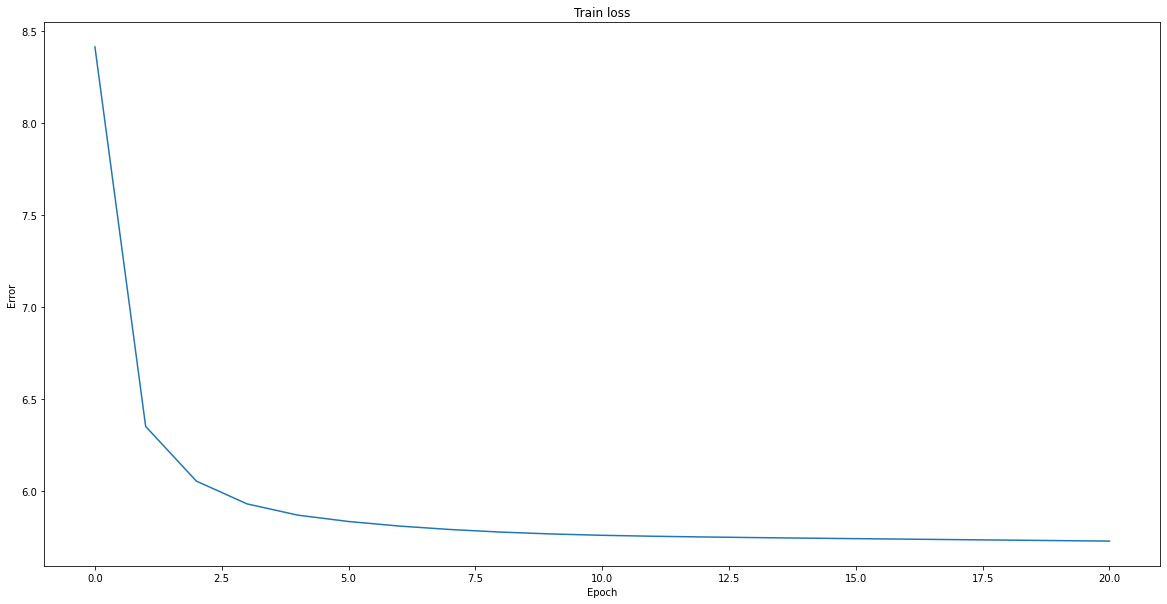

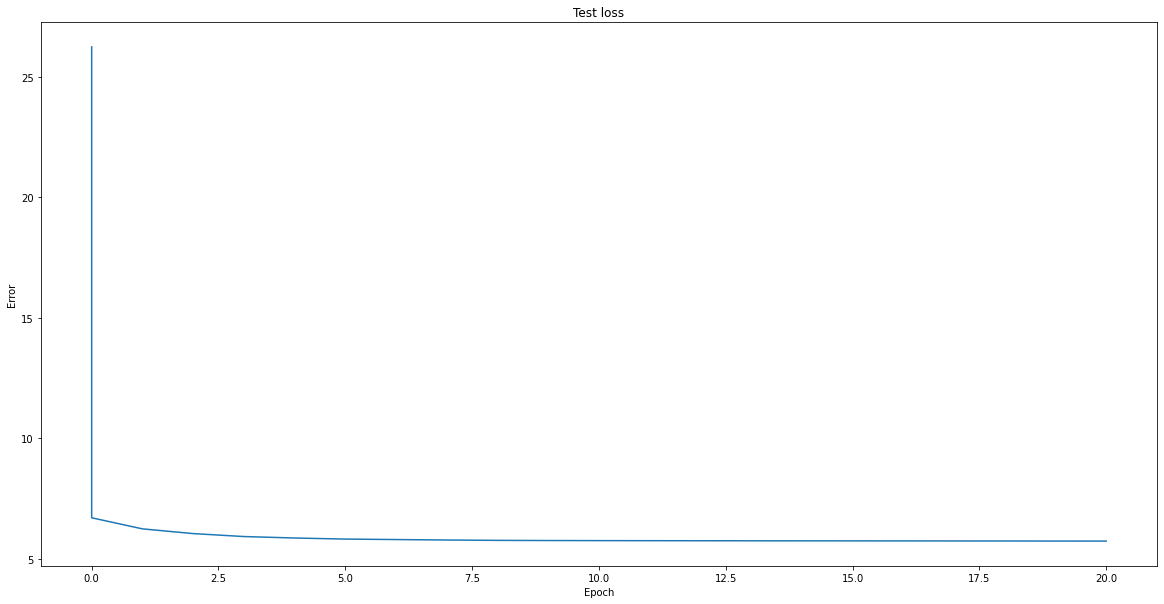

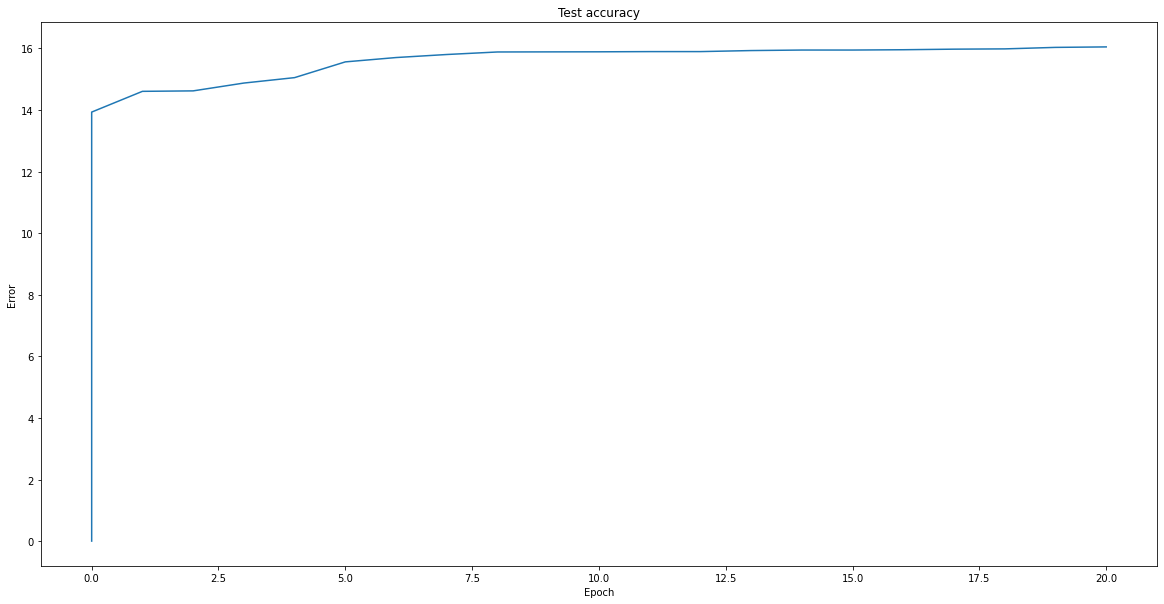

In [ ]:
# Reduce sequence length to 10
def main():
    SEQUENCE_LENGTH = 10
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log_words2.pkl'


    data_train = HarryPotterWordDataset(DATA_PATH + 'harry_potter_words_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterWordDataset(DATA_PATH + 'harry_potter_words_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_words2')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_words2/%03d.pt' % epoch)
            seed_words = 'Harry Potter and Voldemort'.split()
            generated_sentence = generate_language(model, device, seed_words, 20, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 20, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 20, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_words2/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

# Other Things 3: Using an LSTM instead of a GRU

In [ ]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, 2, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.lstm(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [ ]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        sample = output[0].argmax().long()
        outputs.append(sample)
        output, hidden = model.inference(sample, hidden, TEMPERATURE)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        sample = torch.multinomial(output[0], 1)[0].long()
        outputs.append(sample)
        output, hidden = model.inference(sample, hidden, TEMPERATURE)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beam = [([], output, hidden, 0)]
    # TODO
    for ii in range(sequence_length):
        new_beams = []
        for curr_beam in beam:
            for sample in torch.multinomial(curr_beam[1][0], beam_width, replacement=True):
                sample = sample.long()
                score = curr_beam[3] + torch.log(curr_beam[1][0][sample])
                output, hidden = model.inference(sample, curr_beam[2], TEMPERATURE)
                new_beams.append((curr_beam[0] + [sample], output, hidden, score))
        new_beams.sort(key = lambda b: b[3], reverse=True)
        beam = new_beams[:beam_width]
    outputs = beam[0][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

In [ ]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([89, 512]) = 0MB
lstm.weight_ih_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.weight_hh_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.bias_ih_l0 -> 	torch.Size([2048]) = 0MB
lstm.bias_hh_l0 -> 	torch.Size([2048]) = 0MB
lstm.weight_ih_l1 -> 	torch.Size([2048, 512]) = 4MB
lstm.weight_hh_l1 -> 	torch.Size([2048, 512]) = 4MB
lstm.bias_ih_l1 -> 	torch.Size([2048]) = 0MB
lstm.bias_hh_l1 -> 	torch.Size([2048]) = 0MB
decoder.weight -> 	torch.Size([89, 512]) = 0MB
decoder.bias -> 	torch.Size([89]) = 0MB

Restored all variables
No new variables
Restored /content/checkpoints/000.pt
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat todntttd segddd ttain.t the core  atask  "I ss tarre .  "e said  "Ion't sauky  tor,  said Har


Input	rossed the outer cave, and Harr

  1%|          | 1/195 [00:00<01:31,  2.12it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 1.490103


  6%|▌         | 11/195 [00:04<01:11,  2.56it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 1.867121


 11%|█         | 21/195 [00:08<01:06,  2.60it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 1.660509


 16%|█▌        | 31/195 [00:12<01:03,  2.58it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 1.591549


 21%|██        | 41/195 [00:15<00:59,  2.59it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 1.536450


 26%|██▌       | 51/195 [00:19<00:56,  2.57it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 1.499284


 31%|███▏      | 61/195 [00:23<00:51,  2.60it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 1.497580


 36%|███▋      | 71/195 [00:27<00:47,  2.61it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 1.486937


 42%|████▏     | 81/195 [00:31<00:43,  2.61it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 1.468837


 47%|████▋     | 91/195 [00:35<00:39,  2.61it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 1.471894


 52%|█████▏    | 101/195 [00:38<00:36,  2.60it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 1.493168


 57%|█████▋    | 111/195 [00:42<00:32,  2.60it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 1.452198


 62%|██████▏   | 121/195 [00:46<00:28,  2.61it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 1.475760


 67%|██████▋   | 131/195 [00:50<00:24,  2.63it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.488359


 72%|███████▏  | 141/195 [00:54<00:20,  2.61it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.459792


 77%|███████▋  | 151/195 [00:58<00:16,  2.63it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 1.454401


 83%|████████▎ | 161/195 [01:01<00:12,  2.62it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 1.459049


 88%|████████▊ | 171/195 [01:05<00:09,  2.61it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.442764


 93%|█████████▎| 181/195 [01:09<00:05,  2.61it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.422281


 98%|█████████▊| 191/195 [01:13<00:01,  2.62it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.444750


100%|██████████| 195/195 [01:14<00:00,  2.61it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoaat oughtond soavid ttain.t the case  ooask  "I sn aa r  .  "e said  "Iun't warry  Ior,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	aws d toe btt r oase  and tarry sa d d tumbledore wack tn o the cnt otat yed toat torl d toe boaaele


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd teanpeng tn the cogdle of the cork oagh anuuet on tagwmeade  "or tfe oiwrible torent oarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:33,  2.08it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.438604


  6%|▌         | 11/195 [00:04<01:09,  2.63it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.444169


 11%|█         | 21/195 [00:08<01:06,  2.62it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.431329


 16%|█▌        | 31/195 [00:11<01:03,  2.58it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.444884


 21%|██        | 41/195 [00:15<00:58,  2.62it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.460030


 26%|██▌       | 51/195 [00:19<00:55,  2.60it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.416506


 31%|███▏      | 61/195 [00:23<00:52,  2.58it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.419578


 36%|███▋      | 71/195 [00:27<00:47,  2.61it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.410986


 42%|████▏     | 81/195 [00:31<00:43,  2.60it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.406661


 47%|████▋     | 91/195 [00:34<00:39,  2.62it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.420945


 52%|█████▏    | 101/195 [00:38<00:36,  2.60it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.449733


 57%|█████▋    | 111/195 [00:42<00:32,  2.62it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.406917


 62%|██████▏   | 121/195 [00:46<00:28,  2.60it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.409029


 67%|██████▋   | 131/195 [00:50<00:24,  2.62it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.462150


 72%|███████▏  | 141/195 [00:54<00:20,  2.62it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.424114


 77%|███████▋  | 151/195 [00:57<00:16,  2.60it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.400531


 83%|████████▎ | 161/195 [01:01<00:12,  2.62it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.396692


 88%|████████▊ | 171/195 [01:05<00:09,  2.61it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.391676


 93%|█████████▎| 181/195 [01:09<00:05,  2.62it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.375971


 98%|█████████▊| 191/195 [01:13<00:01,  2.62it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.389086


100%|██████████| 195/195 [01:14<00:00,  2.61it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet sughtond seaved atain.t the case  eaask  "I dm aarr  .  "e said  "Iun't warky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	awsed the snt r oarer and tarry saap d humbledore aeck anto the cnt otar rer ahet horl d ihe caaaela


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ner ng atd seenpeng tn the caddle of the cark oashtanuuetson tagwmeade  "ir ane oewrible aorent oarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:33,  2.07it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.399273


  6%|▌         | 11/195 [00:04<01:10,  2.60it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.392629


 11%|█         | 21/195 [00:08<01:06,  2.62it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.423957


 16%|█▌        | 31/195 [00:11<01:03,  2.60it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.406070


 21%|██        | 41/195 [00:15<00:59,  2.59it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.390224


 26%|██▌       | 51/195 [00:19<00:55,  2.60it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.371440


 31%|███▏      | 61/195 [00:23<00:51,  2.60it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.385412


 36%|███▋      | 71/195 [00:27<00:47,  2.60it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.385453


 42%|████▏     | 81/195 [00:31<00:43,  2.62it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.375986


 47%|████▋     | 91/195 [00:35<00:40,  2.58it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.377169


 52%|█████▏    | 101/195 [00:38<00:36,  2.61it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.385020


 57%|█████▋    | 111/195 [00:42<00:32,  2.62it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.381949


 62%|██████▏   | 121/195 [00:46<00:28,  2.60it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.382515


 67%|██████▋   | 131/195 [00:50<00:24,  2.61it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.386125


 72%|███████▏  | 141/195 [00:54<00:20,  2.59it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.384140


 77%|███████▋  | 151/195 [00:57<00:16,  2.61it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.379577


 83%|████████▎ | 161/195 [01:01<00:13,  2.61it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.374491


 88%|████████▊ | 171/195 [01:05<00:09,  2.60it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.356516


 93%|█████████▎| 181/195 [01:09<00:05,  2.62it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.349975


 98%|█████████▊| 191/195 [01:13<00:01,  2.61it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.359124


100%|██████████| 195/195 [01:14<00:00,  2.61it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeet segntond totvid ttain.t the case  ooisk  "I sm terr  .  "e said  "Iun't sarky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the cnt r oarer and tarry saaded humbledore aeck tnto the cnk otar rer aoat horled the caaaela


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering atd seenpeng hn the caddle of the cark oaghtanuaetsan tagwmeade  "ir ane oewrible sorent harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:30,  2.14it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.371346


  6%|▌         | 11/195 [00:04<01:10,  2.62it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.381460


 11%|█         | 21/195 [00:08<01:06,  2.62it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.380144


 16%|█▌        | 31/195 [00:11<01:03,  2.60it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.380593


 21%|██        | 41/195 [00:15<00:59,  2.60it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.373608


 26%|██▌       | 51/195 [00:19<00:55,  2.61it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.353367


 31%|███▏      | 61/195 [00:23<00:51,  2.60it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.366144


 36%|███▋      | 71/195 [00:27<00:47,  2.60it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.361611


 42%|████▏     | 81/195 [00:31<00:43,  2.60it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.345949


 47%|████▋     | 91/195 [00:34<00:40,  2.60it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.359903


 52%|█████▏    | 101/195 [00:38<00:35,  2.62it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.359529


 57%|█████▋    | 111/195 [00:42<00:32,  2.61it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.370515


 62%|██████▏   | 121/195 [00:46<00:28,  2.60it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.370760


 67%|██████▋   | 131/195 [00:50<00:24,  2.61it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.373240


 72%|███████▏  | 141/195 [00:54<00:20,  2.63it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.382994


 77%|███████▋  | 151/195 [00:57<00:16,  2.61it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.362971


 83%|████████▎ | 161/195 [01:01<00:13,  2.61it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.375807


 88%|████████▊ | 171/195 [01:05<00:09,  2.62it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.335966


 93%|█████████▎| 181/195 [01:09<00:05,  2.60it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.336011


 98%|█████████▊| 191/195 [01:13<00:01,  2.63it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.346532


100%|██████████| 195/195 [01:14<00:00,  2.61it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat stgntond soavid atain.t the case  oaisl  "I sm te r  .  "e said  "Iun't sarky  Ihr," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the cnt r tare  and sarry saaped humbledore weck tnto the snk otat red aoat horled hhe cooaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring hnd sienpeng hn the saddle of the cark aagh anueet an tagwmeade  "ir ane oiwrible sorent harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:34,  2.05it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.353966


  6%|▌         | 11/195 [00:04<01:10,  2.60it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.380706


 11%|█         | 21/195 [00:08<01:06,  2.60it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.360478


 16%|█▌        | 31/195 [00:11<01:03,  2.60it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.367468


 21%|██        | 41/195 [00:15<00:58,  2.61it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.356944


 26%|██▌       | 51/195 [00:19<00:55,  2.60it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.338646


 31%|███▏      | 61/195 [00:23<00:51,  2.62it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.371772


 36%|███▋      | 71/195 [00:27<00:47,  2.63it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.352419


 42%|████▏     | 81/195 [00:31<00:43,  2.62it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.339229


 47%|████▋     | 91/195 [00:34<00:39,  2.61it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.350678


 52%|█████▏    | 101/195 [00:38<00:35,  2.63it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.346686


 57%|█████▋    | 111/195 [00:42<00:32,  2.62it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.369238


 62%|██████▏   | 121/195 [00:46<00:28,  2.61it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.356857


 67%|██████▋   | 131/195 [00:50<00:24,  2.61it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.363053


 72%|███████▏  | 141/195 [00:54<00:20,  2.63it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.357467


 77%|███████▋  | 151/195 [00:57<00:16,  2.62it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.350072


 83%|████████▎ | 161/195 [01:01<00:12,  2.63it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.362310


 88%|████████▊ | 171/195 [01:05<00:09,  2.60it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.326285


 93%|█████████▎| 181/195 [01:09<00:05,  2.63it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.334757


 98%|█████████▊| 191/195 [01:13<00:01,  2.63it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.342572


100%|██████████| 195/195 [01:14<00:00,  2.62it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat segntond sotvid atainst the sare  oaisl  "I sm se r  .  "e said  "Iun't wauky  Ihr," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the snt r tare  and sarry sa ded humbledore weck tnto the cnh wtat red aoat horl d hhe caoaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nireng hnd soenpeng hn the saddle of the sark aagh anueat an tagwmeade  "rr ane oewrible sorent harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:33,  2.07it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.356058


  6%|▌         | 11/195 [00:04<01:10,  2.60it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.359109


 11%|█         | 21/195 [00:08<01:06,  2.61it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.351629


 16%|█▌        | 31/195 [00:11<01:03,  2.59it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.362309


 21%|██        | 41/195 [00:15<00:58,  2.63it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.349193


 26%|██▌       | 51/195 [00:19<00:55,  2.60it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.330681


 31%|███▏      | 61/195 [00:23<00:51,  2.61it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.364521


 36%|███▋      | 71/195 [00:27<00:47,  2.59it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.338711


 42%|████▏     | 81/195 [00:31<00:43,  2.62it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.328686


 47%|████▋     | 91/195 [00:34<00:39,  2.63it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.342874


 52%|█████▏    | 101/195 [00:38<00:35,  2.62it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.344125


 57%|█████▋    | 111/195 [00:42<00:32,  2.60it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.344487


 62%|██████▏   | 121/195 [00:46<00:28,  2.61it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.349472


 67%|██████▋   | 131/195 [00:50<00:24,  2.61it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.365132


 72%|███████▏  | 141/195 [00:54<00:20,  2.61it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.358493


 77%|███████▋  | 151/195 [00:57<00:16,  2.62it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.344592


 83%|████████▎ | 161/195 [01:01<00:12,  2.62it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.345471


 88%|████████▊ | 171/195 [01:05<00:09,  2.60it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.315926


 93%|█████████▎| 181/195 [01:09<00:05,  2.62it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.325291


 98%|█████████▊| 191/195 [01:13<00:01,  2.62it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.336553


100%|██████████| 195/195 [01:14<00:00,  2.62it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat degntond soavid ttainst the care aoaisl  "I wm serr  .  "e said  "Iun't wauky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the dtt r tare  and tarry saaded humbledore aeck tn o the cnh wtat red aoat horl d hhe caoaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring and sienpeng hn the soddle of the cark aagh anueat an tagwmeade  "rr afe oewrible worent harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:33,  2.09it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.350744


  6%|▌         | 11/195 [00:04<01:10,  2.61it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.346578


 11%|█         | 21/195 [00:08<01:06,  2.62it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.348956


 16%|█▌        | 31/195 [00:11<01:03,  2.60it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.355162


 21%|██        | 41/195 [00:15<00:59,  2.60it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.341925


 26%|██▌       | 51/195 [00:19<00:55,  2.60it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.330556


 31%|███▏      | 61/195 [00:23<00:51,  2.61it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.356505


 36%|███▋      | 71/195 [00:27<00:47,  2.59it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.335249


 42%|████▏     | 81/195 [00:31<00:43,  2.61it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.321795


 47%|████▋     | 91/195 [00:34<00:39,  2.62it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.334618


 52%|█████▏    | 101/195 [00:38<00:36,  2.59it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.331656


 57%|█████▋    | 111/195 [00:42<00:32,  2.61it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.322787


 62%|██████▏   | 121/195 [00:46<00:28,  2.60it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.340051


 67%|██████▋   | 131/195 [00:50<00:24,  2.61it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.361164


 72%|███████▏  | 141/195 [00:54<00:20,  2.61it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.358558


 77%|███████▋  | 151/195 [00:57<00:16,  2.62it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.333921


 83%|████████▎ | 161/195 [01:01<00:13,  2.61it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.326387


 88%|████████▊ | 171/195 [01:05<00:09,  2.61it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.317211


 93%|█████████▎| 181/195 [01:09<00:05,  2.60it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.312791


 98%|█████████▊| 191/195 [01:13<00:01,  2.61it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.333546


100%|██████████| 195/195 [01:14<00:00,  2.61it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat dtlntond soan d ttain.t the care aoaisl  "I wm serr  .  "e said  "Iun't wauky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the snt r aare  and tarry saaped humbledore aeck tnto the cnh atat red aoat hrrl d hhe caoaeoa


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and soenpeng hn the coddle of the cark aagh anueat an tagwmeade  "rr ane oiwrible worent warr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:32,  2.11it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.345865


  6%|▌         | 11/195 [00:04<01:10,  2.61it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.340037


 11%|█         | 21/195 [00:08<01:06,  2.62it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.341002


 16%|█▌        | 31/195 [00:11<01:03,  2.59it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.345401


 21%|██        | 41/195 [00:15<00:59,  2.59it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.340148


 26%|██▌       | 51/195 [00:19<00:55,  2.59it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.317370


 31%|███▏      | 61/195 [00:23<00:51,  2.60it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.332471


 36%|███▋      | 71/195 [00:27<00:47,  2.60it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.329475


 42%|████▏     | 81/195 [00:31<00:44,  2.59it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.313395


 47%|████▋     | 91/195 [00:35<00:40,  2.59it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.331306


 52%|█████▏    | 101/195 [00:38<00:35,  2.61it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.328804


 57%|█████▋    | 111/195 [00:42<00:32,  2.62it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.316581


 62%|██████▏   | 121/195 [00:46<00:28,  2.62it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.331644


 67%|██████▋   | 131/195 [00:50<00:24,  2.63it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.351400


 72%|███████▏  | 141/195 [00:54<00:20,  2.61it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.347714


 77%|███████▋  | 151/195 [00:57<00:16,  2.62it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.330762


 83%|████████▎ | 161/195 [01:01<00:12,  2.62it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.332936


 88%|████████▊ | 171/195 [01:05<00:09,  2.61it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.306280


 93%|█████████▎| 181/195 [01:09<00:05,  2.60it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.306183


 98%|█████████▊| 191/195 [01:13<00:01,  2.61it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.319803


100%|██████████| 195/195 [01:14<00:00,  2.61it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeet stlntond sotn d atain.t the case aoaisl  "I wm serr  .  "e said  "Ion't wanky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the snt r aare  and sarry saaded humbledore aeck tnto the cnh wtat red aoat hrnl d hhe cooaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and soenpeng hn the coddle of the cork aagh anieat an tagwmeade  "rr ane oiwrible sorent warr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:34,  2.05it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.335628


  6%|▌         | 11/195 [00:04<01:10,  2.60it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.330507


 11%|█         | 21/195 [00:08<01:06,  2.62it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.333408


 16%|█▌        | 31/195 [00:11<01:03,  2.59it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.341799


 21%|██        | 41/195 [00:15<00:59,  2.60it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.331176


 26%|██▌       | 51/195 [00:19<00:55,  2.61it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.312366


 31%|███▏      | 61/195 [00:23<00:51,  2.62it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.326441


 36%|███▋      | 71/195 [00:27<00:47,  2.59it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.319158


 42%|████▏     | 81/195 [00:31<00:43,  2.61it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.314060


 47%|████▋     | 91/195 [00:35<00:39,  2.60it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.324938


 52%|█████▏    | 101/195 [00:38<00:36,  2.60it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.328618


 57%|█████▋    | 111/195 [00:42<00:32,  2.61it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.315792


 62%|██████▏   | 121/195 [00:46<00:28,  2.61it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.327539


 67%|██████▋   | 131/195 [00:50<00:24,  2.58it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.338558


 72%|███████▏  | 141/195 [00:54<00:20,  2.61it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.335078


 77%|███████▋  | 151/195 [00:58<00:16,  2.59it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.326098


 83%|████████▎ | 161/195 [01:01<00:13,  2.59it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.322203


 88%|████████▊ | 171/195 [01:05<00:09,  2.60it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.299519


 93%|█████████▎| 181/195 [01:09<00:05,  2.63it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.301038


 98%|█████████▊| 191/195 [01:13<00:01,  2.62it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.317263


100%|██████████| 195/195 [01:14<00:00,  2.61it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat stlntond soaned atainst the case aoaisl  "I wm serr  .  "e said  "Ion't sanky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	assed the str r aare  and sarry saaded humbledore aeck tnto the cnh wtat red aoat honl d hhe caoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and soenpeng hn the coddle of the sork aagh anieat an tagwmeade  "or ane oiwrible soment harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:35,  2.02it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.330782


  6%|▌         | 11/195 [00:04<01:10,  2.61it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.318968


 11%|█         | 21/195 [00:08<01:06,  2.62it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.326043


 16%|█▌        | 31/195 [00:11<01:03,  2.60it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.333939


 21%|██        | 41/195 [00:15<00:59,  2.58it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.320773


 26%|██▌       | 51/195 [00:19<00:55,  2.58it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.313883


 31%|███▏      | 61/195 [00:23<00:51,  2.60it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.325178


 36%|███▋      | 71/195 [00:27<00:47,  2.61it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.321708


 42%|████▏     | 81/195 [00:31<00:43,  2.61it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.303598


 47%|████▋     | 91/195 [00:34<00:40,  2.58it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.315613


 52%|█████▏    | 101/195 [00:38<00:35,  2.61it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.316756


 57%|█████▋    | 111/195 [00:42<00:32,  2.61it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.310659


 62%|██████▏   | 121/195 [00:46<00:28,  2.59it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.325158


 67%|██████▋   | 131/195 [00:50<00:24,  2.60it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.338982


 72%|███████▏  | 141/195 [00:54<00:20,  2.60it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.341066


 77%|███████▋  | 151/195 [00:57<00:17,  2.59it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.320227


 83%|████████▎ | 161/195 [01:01<00:13,  2.61it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.302632


 88%|████████▊ | 171/195 [01:05<00:09,  2.59it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.300566


 93%|█████████▎| 181/195 [01:09<00:05,  2.62it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.300610


 98%|█████████▊| 191/195 [01:13<00:01,  2.62it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.317556


100%|██████████| 195/195 [01:14<00:00,  2.61it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat stlntond soaned atain.t the case aoaisl  "I sm sarr  .  "e said  "Ion't sanky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eused the str r aare  and tarry saaded humbledore aeck tnto the cne btat red,aoan hrnl d hhe caoaeoi


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and sienping hn the caddle of the sark aagh anieat an tagwmeade  "rr ane oiwrible sorent harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:30,  2.13it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.328900


  6%|▌         | 11/195 [00:04<01:10,  2.60it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.315897


 11%|█         | 21/195 [00:08<01:07,  2.59it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.322550


 16%|█▌        | 31/195 [00:11<01:02,  2.63it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.329309


 21%|██        | 41/195 [00:15<00:59,  2.59it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.319525


 26%|██▌       | 51/195 [00:19<00:55,  2.57it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.307407


 31%|███▏      | 61/195 [00:23<00:51,  2.60it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.318333


 36%|███▋      | 71/195 [00:27<00:47,  2.61it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.309703


 42%|████▏     | 81/195 [00:31<00:43,  2.61it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.300940


 47%|████▋     | 91/195 [00:35<00:40,  2.59it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.307378


 52%|█████▏    | 101/195 [00:38<00:36,  2.59it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.315697


 57%|█████▋    | 111/195 [00:42<00:32,  2.62it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.296626


 62%|██████▏   | 121/195 [00:46<00:28,  2.61it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.311790


 67%|██████▋   | 131/195 [00:50<00:24,  2.61it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.329014


 72%|███████▏  | 141/195 [00:54<00:20,  2.59it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.334393


 77%|███████▋  | 151/195 [00:58<00:16,  2.60it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.312812


 83%|████████▎ | 161/195 [01:01<00:13,  2.61it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.306805


 88%|████████▊ | 171/195 [01:05<00:09,  2.61it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.299640


 93%|█████████▎| 181/195 [01:09<00:05,  2.60it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.296171


 98%|█████████▊| 191/195 [01:13<00:01,  2.62it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.310941


100%|██████████| 195/195 [01:14<00:00,  2.61it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsoeat stlntond soaned anainst the case aoaisl  "I sm sa r  .  "e said  "Iun't wanky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eused the str r aare  and tarry saaded humbledore aeck tnto the cne wtat red,aoat hrnl d the caoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	neling and sionpeng hn the caddle of the cark aagh anieat an tagwmeade  "or ane oawrible souent harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:33,  2.07it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.321898


  6%|▌         | 11/195 [00:04<01:10,  2.61it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.313964


 11%|█         | 21/195 [00:08<01:06,  2.62it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.320857


 16%|█▌        | 31/195 [00:11<01:02,  2.60it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.326214


 21%|██        | 41/195 [00:15<00:59,  2.61it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.314694


 26%|██▌       | 51/195 [00:19<00:54,  2.62it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.298584


 31%|███▏      | 61/195 [00:23<00:51,  2.62it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.316205


 36%|███▋      | 71/195 [00:27<00:47,  2.61it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.312184


 42%|████▏     | 81/195 [00:31<00:43,  2.61it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.306474


 47%|████▋     | 91/195 [00:34<00:39,  2.61it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.310124


 52%|█████▏    | 101/195 [00:38<00:36,  2.59it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.315460


 57%|█████▋    | 111/195 [00:42<00:32,  2.62it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.296930


 62%|██████▏   | 121/195 [00:46<00:28,  2.62it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.308429


 67%|██████▋   | 131/195 [00:50<00:24,  2.62it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.323275


 72%|███████▏  | 141/195 [00:53<00:20,  2.61it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.321948


 77%|███████▋  | 151/195 [00:57<00:16,  2.62it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.312002


 83%|████████▎ | 161/195 [01:01<00:13,  2.61it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.295446


 88%|████████▊ | 171/195 [01:05<00:09,  2.63it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.290958


 93%|█████████▎| 181/195 [01:09<00:05,  2.62it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.290991


 98%|█████████▊| 191/195 [01:13<00:01,  2.62it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.305143


100%|██████████| 195/195 [01:14<00:00,  2.62it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsoeat stlntond soaned atain.t the care aoaisl  "I dm sarr  .  "e said  "Iun't yauky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eused the str r aare  and tarry saaded humbledore aeck tnto the cnh btat red,aoan hrrl d the saoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and sienping hntthe caddle of the cark aagh anieat an tagwmeade  "ir ane oiwrible sament harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:34,  2.04it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.312000


  6%|▌         | 11/195 [00:04<01:10,  2.60it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.308736


 11%|█         | 21/195 [00:08<01:06,  2.61it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.316890


 16%|█▌        | 31/195 [00:11<01:03,  2.59it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.319877


 21%|██        | 41/195 [00:15<00:58,  2.61it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.310937


 26%|██▌       | 51/195 [00:19<00:55,  2.59it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.292227


 31%|███▏      | 61/195 [00:23<00:51,  2.60it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.315449


 36%|███▋      | 71/195 [00:27<00:47,  2.62it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.300715


 42%|████▏     | 81/195 [00:31<00:43,  2.63it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.292420


 47%|████▋     | 91/195 [00:34<00:40,  2.59it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.301949


 52%|█████▏    | 101/195 [00:38<00:36,  2.59it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.306365


 57%|█████▋    | 111/195 [00:42<00:32,  2.61it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.302208


 62%|██████▏   | 121/195 [00:46<00:28,  2.62it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.307094


 67%|██████▋   | 131/195 [00:50<00:24,  2.62it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.328687


 72%|███████▏  | 141/195 [00:54<00:20,  2.61it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.318492


 77%|███████▋  | 151/195 [00:57<00:16,  2.60it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.307888


 83%|████████▎ | 161/195 [01:01<00:13,  2.61it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.292868


 88%|████████▊ | 171/195 [01:05<00:09,  2.61it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.283049


 93%|█████████▎| 181/195 [01:09<00:05,  2.57it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.291021


 98%|█████████▊| 191/195 [01:13<00:01,  2.60it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.303414


100%|██████████| 195/195 [01:14<00:00,  2.61it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat salntond soaned atain.t the case aaaisls "I dm salr  .  "e said  "Ion'  yanry  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the str r aare  and tarry saaded humbledore aeck tnto the cnh wtal red,aoan hrnl d the saoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nering and sionping hn the caddle of the cark aagh anieat an tagwmeade  "ir ane oiwrible sament harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:32,  2.10it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.314795


  6%|▌         | 11/195 [00:04<01:10,  2.60it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.301826


 11%|█         | 21/195 [00:08<01:07,  2.59it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.307137


 16%|█▌        | 31/195 [00:11<01:03,  2.59it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.313102


 21%|██        | 41/195 [00:15<00:59,  2.60it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.304930


 26%|██▌       | 51/195 [00:19<00:55,  2.60it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.291336


 31%|███▏      | 61/195 [00:23<00:51,  2.62it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.313347


 36%|███▋      | 71/195 [00:27<00:47,  2.60it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.301541


 42%|████▏     | 81/195 [00:31<00:43,  2.61it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.287910


 47%|████▋     | 91/195 [00:35<00:40,  2.58it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.293523


 52%|█████▏    | 101/195 [00:38<00:36,  2.61it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.307179


 57%|█████▋    | 111/195 [00:42<00:32,  2.61it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.293348


 62%|██████▏   | 121/195 [00:46<00:28,  2.62it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.302876


 67%|██████▋   | 131/195 [00:50<00:24,  2.60it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.316607


 72%|███████▏  | 141/195 [00:54<00:20,  2.61it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.314278


 77%|███████▋  | 151/195 [00:57<00:16,  2.62it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.301880


 83%|████████▎ | 161/195 [01:01<00:13,  2.60it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.298038


 88%|████████▊ | 171/195 [01:05<00:09,  2.61it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.294674


 93%|█████████▎| 181/195 [01:09<00:05,  2.60it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.283604


 98%|█████████▊| 191/195 [01:13<00:01,  2.62it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.299685


100%|██████████| 195/195 [01:14<00:00,  2.61it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat stlntond soaned atain.t the case aoaisls "I sm salr  .  "e said  "Ion't sarky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eused the str r aare  and tarry saaded humbledore aeck tnto the cnh star red,aoat hrnled the caoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	neling and sionpeng hn the caddle of the cark aagh anieat an tagwmeade  "rr ane oilrible sarent harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:33,  2.08it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.310947


  6%|▌         | 11/195 [00:04<01:11,  2.58it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.299351


 11%|█         | 21/195 [00:08<01:07,  2.59it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.305317


 16%|█▌        | 31/195 [00:11<01:03,  2.60it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.313229


 21%|██        | 41/195 [00:15<00:59,  2.58it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.306485


 26%|██▌       | 51/195 [00:19<00:55,  2.59it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.291110


 31%|███▏      | 61/195 [00:23<00:51,  2.59it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.304080


 36%|███▋      | 71/195 [00:27<00:47,  2.60it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.294278


 42%|████▏     | 81/195 [00:31<00:44,  2.58it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.286862


 47%|████▋     | 91/195 [00:35<00:39,  2.61it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.294920


 52%|█████▏    | 101/195 [00:38<00:36,  2.61it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.307346


 57%|█████▋    | 111/195 [00:42<00:32,  2.62it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.285872


 62%|██████▏   | 121/195 [00:46<00:28,  2.62it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.307202


 67%|██████▋   | 131/195 [00:50<00:24,  2.60it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.316279


 72%|███████▏  | 141/195 [00:54<00:20,  2.60it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.312088


 77%|███████▋  | 151/195 [00:58<00:16,  2.61it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.301826


 83%|████████▎ | 161/195 [01:01<00:12,  2.62it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.287973


 88%|████████▊ | 171/195 [01:05<00:09,  2.61it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.286911


 93%|█████████▎| 181/195 [01:09<00:05,  2.61it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.282274


 98%|█████████▊| 191/195 [01:13<00:01,  2.60it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.293986


100%|██████████| 195/195 [01:14<00:00,  2.61it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtreet stlntond soaned atain.t the care  oaisl  "I tm salr  .  "e said  "Ion'  sanky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eused the str r tare  and tarry saaded humbledore aeck tnto the cnh btat red,aoat hrnl d the saoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	neling and sionping hn the caddle of the cark aagh anieat an tagwmeade  "rr tne oawrible sarent harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:38,  1.97it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.307028


  6%|▌         | 11/195 [00:04<01:10,  2.60it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.300146


 11%|█         | 21/195 [00:08<01:06,  2.60it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.306225


 16%|█▌        | 31/195 [00:12<01:02,  2.61it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.308122


 21%|██        | 41/195 [00:15<00:59,  2.60it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.305415


 26%|██▌       | 51/195 [00:19<00:55,  2.59it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.282821


 31%|███▏      | 61/195 [00:23<00:51,  2.59it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.297865


 36%|███▋      | 71/195 [00:27<00:47,  2.61it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.295047


 42%|████▏     | 81/195 [00:31<00:43,  2.62it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.293430


 47%|████▋     | 91/195 [00:35<00:39,  2.61it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.295812


 52%|█████▏    | 101/195 [00:38<00:36,  2.60it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.307158


 57%|█████▋    | 111/195 [00:42<00:32,  2.60it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.290235


 62%|██████▏   | 121/195 [00:46<00:28,  2.58it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.295701


 67%|██████▋   | 131/195 [00:50<00:24,  2.61it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.310024


 72%|███████▏  | 141/195 [00:54<00:20,  2.58it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.308138


 77%|███████▋  | 151/195 [00:58<00:16,  2.61it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.293356


 83%|████████▎ | 161/195 [01:01<00:13,  2.60it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.282665


 88%|████████▊ | 171/195 [01:05<00:09,  2.60it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.284471


 93%|█████████▎| 181/195 [01:09<00:05,  2.59it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.280762


 98%|█████████▊| 191/195 [01:13<00:01,  2.62it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.295335


100%|██████████| 195/195 [01:14<00:00,  2.61it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet stlntond soaned tnain.t the care  oaasl  "I dm salr  .  "e said  "Ion'  yarky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eused the str r tare  and tarry saaded humbledore aeck tnto the cnh btar red,aoat hrnl d the caoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	neling and sionping hn the caddle of the cark aagh anieet an tagwmeade  "rr tne walrible sarent harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:34,  2.05it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.313227


  6%|▌         | 11/195 [00:04<01:10,  2.60it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.296784


 11%|█         | 21/195 [00:08<01:07,  2.59it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.298122


 16%|█▌        | 31/195 [00:11<01:02,  2.61it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.308103


 21%|██        | 41/195 [00:15<00:59,  2.59it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.298859


 26%|██▌       | 51/195 [00:19<00:55,  2.59it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.277758


 31%|███▏      | 61/195 [00:23<00:51,  2.60it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.303295


 36%|███▋      | 71/195 [00:27<00:48,  2.58it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.292450


 42%|████▏     | 81/195 [00:31<00:44,  2.58it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.285760


 47%|████▋     | 91/195 [00:35<00:40,  2.60it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.288997


 52%|█████▏    | 101/195 [00:38<00:36,  2.61it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.297753


 57%|█████▋    | 111/195 [00:42<00:32,  2.60it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.289589


 62%|██████▏   | 121/195 [00:46<00:28,  2.61it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.321890


 67%|██████▋   | 131/195 [00:50<00:24,  2.62it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.312064


 72%|███████▏  | 141/195 [00:54<00:20,  2.61it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.305493


 77%|███████▋  | 151/195 [00:58<00:16,  2.61it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.293403


 83%|████████▎ | 161/195 [01:01<00:13,  2.60it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.277191


 88%|████████▊ | 171/195 [01:05<00:09,  2.62it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.281766


 93%|█████████▎| 181/195 [01:09<00:05,  2.61it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.275862


 98%|█████████▊| 191/195 [01:13<00:01,  2.60it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.290508


100%|██████████| 195/195 [01:14<00:00,  2.61it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet salntond soaned anain.t the care aoaisls "I tm salr  .  "e said  "Io '  yarky  Ihr," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the str r aare  and tarry saaded humbledore aeck tnto the cnh btar yed,aoat hrrl d the saoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	neling and sionping hntthe caddle of the cark aagh anieet an tagwmeade  "rr ane oilrible sament harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:34,  2.06it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.307880


  6%|▌         | 11/195 [00:04<01:10,  2.61it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.294094


 11%|█         | 21/195 [00:08<01:06,  2.60it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.298462


 16%|█▌        | 31/195 [00:11<01:03,  2.60it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.304024


 21%|██        | 41/195 [00:15<01:00,  2.56it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.294311


 26%|██▌       | 51/195 [00:19<00:55,  2.59it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.276817


 31%|███▏      | 61/195 [00:23<00:51,  2.60it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.300282


 36%|███▋      | 71/195 [00:27<00:47,  2.61it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.284894


 42%|████▏     | 81/195 [00:31<00:43,  2.59it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.281713


 47%|████▋     | 91/195 [00:35<00:40,  2.60it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.289675


 52%|█████▏    | 101/195 [00:38<00:36,  2.59it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.304121


 57%|█████▋    | 111/195 [00:42<00:32,  2.61it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.285336


 62%|██████▏   | 121/195 [00:46<00:28,  2.60it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.307363


 67%|██████▋   | 131/195 [00:50<00:24,  2.60it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.304953


 72%|███████▏  | 141/195 [00:54<00:20,  2.61it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.306615


 77%|███████▋  | 151/195 [00:58<00:16,  2.60it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.292349


 83%|████████▎ | 161/195 [01:01<00:12,  2.62it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.277907


 88%|████████▊ | 171/195 [01:05<00:09,  2.59it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.281530


 93%|█████████▎| 181/195 [01:09<00:05,  2.59it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.278883


 98%|█████████▊| 191/195 [01:13<00:01,  2.63it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.290956


100%|██████████| 195/195 [01:14<00:00,  2.60it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet salntond soaned anain.t the case  oaisls "I tm ailr  .  "e said  "Io 't yarky  Ihr," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eused the str r tare  and tarry saaded humbledore aeck tnto the cnh wtar red,ahan honl d the saoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	neling and sionping hn the caddle of the cark aagh anieet wn tagwmeade  "ir ane hiwrible sament harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:31,  2.12it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.306145


  6%|▌         | 11/195 [00:04<01:10,  2.60it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.292059


 11%|█         | 21/195 [00:08<01:06,  2.62it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.297096


 16%|█▌        | 31/195 [00:11<01:02,  2.61it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.304376


 21%|██        | 41/195 [00:15<00:59,  2.61it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.294046


 26%|██▌       | 51/195 [00:19<00:55,  2.59it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.277963


 31%|███▏      | 61/195 [00:23<00:51,  2.62it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.299968


 36%|███▋      | 71/195 [00:27<00:47,  2.60it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.291539


 42%|████▏     | 81/195 [00:31<00:43,  2.60it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.280064


 47%|████▋     | 91/195 [00:34<00:39,  2.62it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.285345


 52%|█████▏    | 101/195 [00:38<00:36,  2.59it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.296794


 57%|█████▋    | 111/195 [00:42<00:32,  2.61it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.273192


 62%|██████▏   | 121/195 [00:46<00:28,  2.62it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.288729


 67%|██████▋   | 131/195 [00:50<00:24,  2.63it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.310989


 72%|███████▏  | 141/195 [00:54<00:20,  2.61it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.300189


 77%|███████▋  | 151/195 [00:57<00:16,  2.61it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.296866


 83%|████████▎ | 161/195 [01:01<00:12,  2.62it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.277983


 88%|████████▊ | 171/195 [01:05<00:09,  2.60it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.273654


 93%|█████████▎| 181/195 [01:09<00:05,  2.60it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.272919


 98%|█████████▊| 191/195 [01:13<00:01,  2.61it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.284595


100%|██████████| 195/195 [01:14<00:00,  2.61it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rtoeet selntond toaved tnain.t the care  oaisls "I tm salr  .  "e said  "Io 't yarky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the str r tare  and tarry saaded humbledore aeck tnto the cnh btar yed,aoat honl d the cooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	neling and sionping hn the caddle of the cork aagh anieet wn tagwmeade  "ir ane oiwrible soment harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<02:09,  1.50it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.297915


  6%|▌         | 11/195 [00:04<01:10,  2.59it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.291780


 11%|█         | 21/195 [00:08<01:06,  2.62it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.304275


 16%|█▌        | 31/195 [00:12<01:02,  2.61it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.302725


 21%|██        | 41/195 [00:15<00:59,  2.61it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.298064


 26%|██▌       | 51/195 [00:19<00:55,  2.61it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.276921


 31%|███▏      | 61/195 [00:23<00:51,  2.60it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.290395


 36%|███▋      | 71/195 [00:27<00:47,  2.59it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.287217


 42%|████▏     | 81/195 [00:31<00:43,  2.61it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.280774


 47%|████▋     | 91/195 [00:35<00:39,  2.63it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.284987


 52%|█████▏    | 101/195 [00:38<00:36,  2.60it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.298237


 57%|█████▋    | 111/195 [00:42<00:32,  2.59it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.279456


 62%|██████▏   | 121/195 [00:46<00:28,  2.61it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.291829


 67%|██████▋   | 131/195 [00:50<00:24,  2.58it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.305756


 72%|███████▏  | 141/195 [00:54<00:20,  2.61it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.299603


 77%|███████▋  | 151/195 [00:58<00:16,  2.63it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.288913


 83%|████████▎ | 161/195 [01:01<00:13,  2.61it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.278697


 88%|████████▊ | 171/195 [01:05<00:09,  2.61it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.276970


 93%|█████████▎| 181/195 [01:09<00:05,  2.60it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.267674


 98%|█████████▊| 191/195 [01:13<00:01,  2.62it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.285090


100%|██████████| 195/195 [01:14<00:00,  2.60it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet salntond soavid anain.t the case  oaasls "I tm salrl .  "e said  "Ion't yarky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the str r tare  and tarry saaded humbledore aeck tnto the snh btar.yer.aoat hrrl d the saoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	neling and sianping hntthe caddle of the cark aagh anieet an tagwmeade  "rr ane oilrible sament harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:37,  1.99it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.294931


  6%|▌         | 11/195 [00:04<01:10,  2.61it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.295226


 11%|█         | 21/195 [00:08<01:06,  2.61it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.296547


 16%|█▌        | 31/195 [00:11<01:03,  2.59it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.301398


 21%|██        | 41/195 [00:15<00:59,  2.59it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.289962


 26%|██▌       | 51/195 [00:19<00:55,  2.58it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.274371


 31%|███▏      | 61/195 [00:23<00:51,  2.59it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.295398


 36%|███▋      | 71/195 [00:27<00:47,  2.62it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.287288


 42%|████▏     | 81/195 [00:31<00:43,  2.60it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.280387


 47%|████▋     | 91/195 [00:35<00:40,  2.60it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.286170


 52%|█████▏    | 101/195 [00:38<00:35,  2.61it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.296540


 57%|█████▋    | 111/195 [00:42<00:32,  2.62it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.275845


 62%|██████▏   | 121/195 [00:46<00:28,  2.61it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.282930


 67%|██████▋   | 131/195 [00:50<00:24,  2.59it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.304706


 72%|███████▏  | 141/195 [00:54<00:20,  2.60it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.296680


 77%|███████▋  | 151/195 [00:58<00:16,  2.61it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.293079


 83%|████████▎ | 161/195 [01:01<00:12,  2.62it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.271571


 88%|████████▊ | 171/195 [01:05<00:09,  2.61it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.273076


 93%|█████████▎| 181/195 [01:09<00:05,  2.60it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.269198


 98%|█████████▊| 191/195 [01:13<00:01,  2.60it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.282962


100%|██████████| 195/195 [01:14<00:00,  2.61it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet stlntond soavid anain.t the sase  oaasls "I tm aalrl .  "e said  "Io 't yarky  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the str r tare  and tarry saaded humbledore aeck tnto the snh btat.yer,aoat hrnl d the saoaele


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	neding and sionping hntthe saddle of the cork aagh anieet wn tagwmeade  "rr ane oiwrible sament warr


Input	 help, but there was nobody to be see

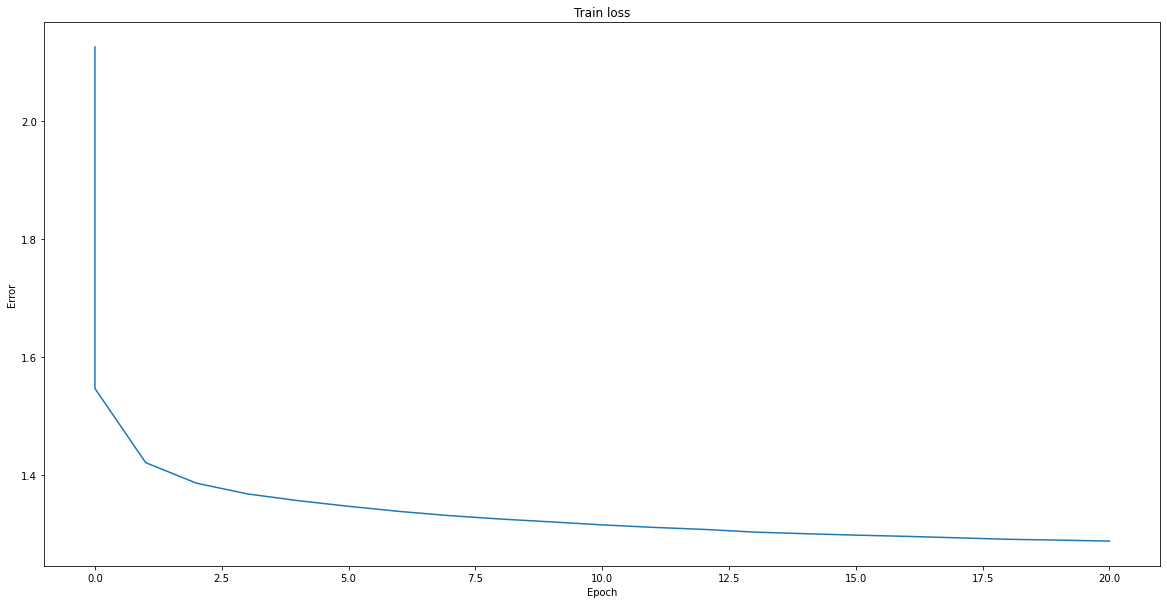

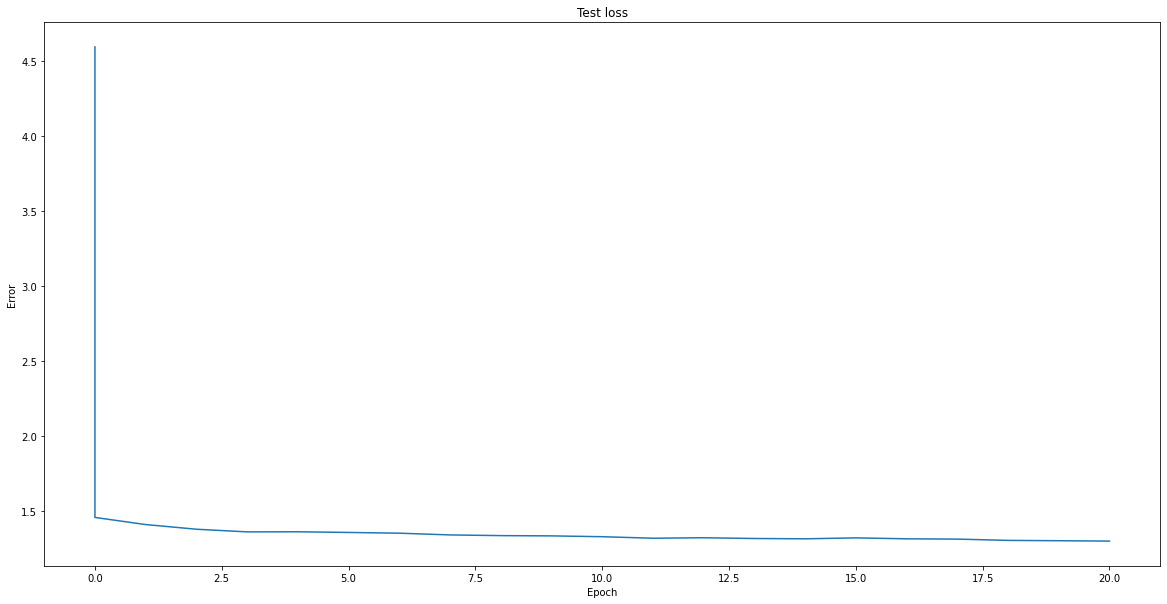

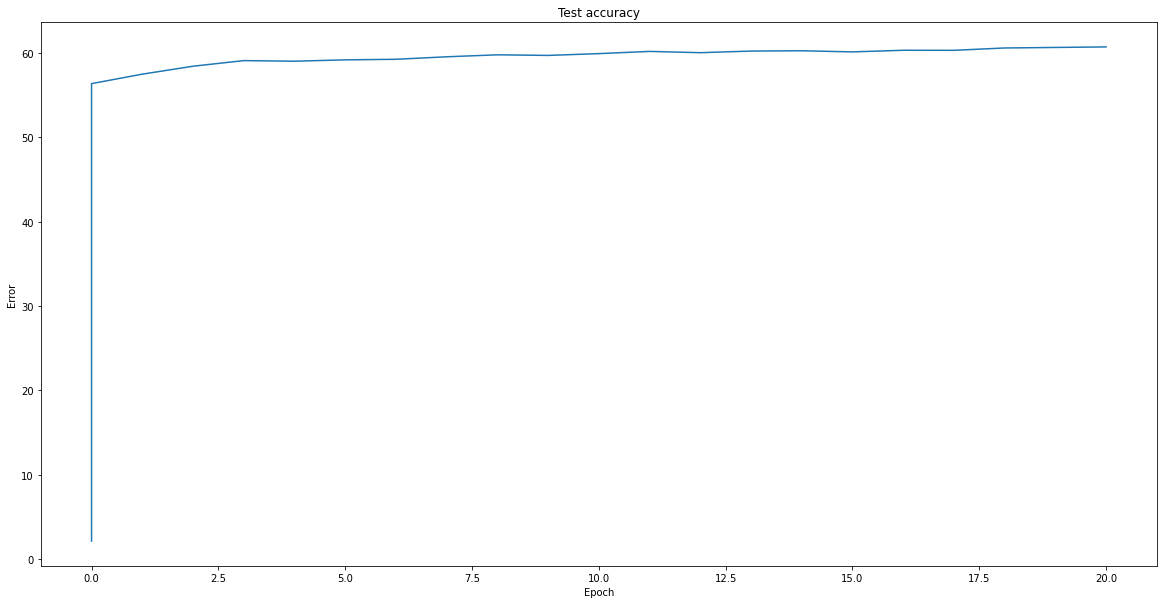

In [ ]:
# TODO: add code for redefining HarryPotterNet with LSTM instead of GRU
# the rest of the training and testing code to produce plots and samples is exactly the same

def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry looked over his shoulder and saw '
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry looked over his shoulder and saw the stands of the stairs and the stairs and the stairs were still standing to the stairs and the stands of the stairs and the stairs and the stairs were still standing to the stairs and the stands of 
generated with sample	 Harry looked over his shoulder and saw that she had been the only before to get on the shadow. "In the letter to him the first and in the green way and the says we have all been to hear the book of the hands of the corridors said to the pr
generated with sample	 Harry looked over his shoulder and saw something and still glanced at the door. "He's got to leave the Chair of magical lights and to the game and the stone was still the one, but the sign with a second, who was still still and said, "He s
generated with sample	 Harry looked over his shoulder and saw the day before he had been staring and said in and flashing his jone. "I've been sure you go get into the some so that's the one who had already got a b

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    

## New Corpus

## Words

## LSTM 

What new difficulties did you run into while training?
While training, we noticed that the loss and accuracy skyrocket in the first few iterations, but then the improvements taper off very quickly. We played around with the number of layers our LSTM consisted of to help combat this but did not identify too much of a difference altogether. 

Were results better than the GRU? Provide training and testing plots.

Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
